In [1]:
source("https://bioconductor.org/biocLite.R")
#biocLite("scran")

ERROR: Error: With R version 3.5 or greater, install Bioconductor packages using BiocManager; see https://bioconductor.org/install


In [ ]:
biocLite("qvalue")

In [2]:
## load useful libraries
suppressWarnings(suppressPackageStartupMessages(library(rhdf5)))
suppressWarnings(suppressPackageStartupMessages(library(qvalue)))
suppressWarnings(suppressPackageStartupMessages(library(dplyr)))
suppressWarnings(suppressPackageStartupMessages(library(tidyverse)))
suppressWarnings(suppressPackageStartupMessages(library(ggbeeswarm)))
suppressWarnings(suppressPackageStartupMessages(library(scater)))
suppressWarnings(suppressPackageStartupMessages(library(SingleCellExperiment)))
suppressWarnings(suppressPackageStartupMessages(library(edgeR)))
# suppressWarnings(suppressPackageStartupMessages(library(scQTLs)))
suppressWarnings(suppressPackageStartupMessages(library(limma)))

ERROR: Error: package or namespace load failed for ‘tidyverse’ in loadNamespace(j <- i[[1L]], c(lib.loc, .libPaths()), versionCheck = vI[[j]]):
 there is no package called ‘lubridate’


In [ ]:
## define known marker genes
pluri_markers <- c("ENSG00000111704_NANOG", "ENSG00000204531_POU5F1", 
                   "ENSG00000164362_TERT", "ENSG00000181449_SOX2",
                   "ENSG00000121570_DPPA4")
pluri_markers_select <- c("ENSG00000111704_NANOG", "ENSG00000204531_POU5F1", 
                          "ENSG00000181449_SOX2", "ENSG00000121570_DPPA4")
mesendo_markers <- c("ENSG00000164458_T", "ENSG00000163508_EOMES",
                     "ENSG00000185155_MIXL1")
defendo_markers <- c("ENSG00000121966_CXCR4", "ENSG00000136574_GATA4",
                     "ENSG00000141448_GATA6", "ENSG00000125798_FOXA2",
                     "ENSG00000164736_SOX17", "ENSG00000133937_GSC",
                     "ENSG00000147869_CER1", "ENSG00000132130_LHX1")
defendo_markers_select <- c("ENSG00000121966_CXCR4", "ENSG00000136574_GATA4",
                            "ENSG00000164736_SOX17", "ENSG00000141448_GATA6",
                            "ENSG00000147869_CER1", "ENSG00000132130_LHX1",
                           "ENSG00000133937_GSC")
later_markers <- c("ENSG00000152804_HHEX", "ENSG00000170608_FOXA3")
diff_genes <- c(pluri_markers, mesendo_markers, defendo_markers, later_markers)

pluri_gene_info <- read.table("/hps/nobackup/hipsci/scratch/singlecell_endodiff/resources/plurinet_gene_info.txt", header = T)

In [3]:
GetResults <- function(results.folder) {
  observed.features <- 0
  results <- NULL
  files.to.read <- list.files(results.folder,pattern = "qtl_results.*h5", full.names = T)
  #print(files.to.read)
  for ( i in files.to.read ) {
    tmp <- h5dump(file = i)
    if ( length(tmp) > 0 ) {
      for ( j in names(tmp) ) { tmp[[j]][["feature"]] <- j }
      observed.features = observed.features + length(tmp)
      df <- bind_rows(tmp)
      if ( nrow(df) > 0 ) { 
          df <- df[,!(colnames(df) %in% c("group","name", "otype", "dclass",  "dim"))]
          results = rbind(results,df) }
    }
  }
  H5close()
#   if ( length(which(is.na(results$empirical_feature_p_value))) != 0 ) {
#     results <- results[-which(is.na(results$empirical_feature_p_value)),]
#   }
  H5close()
#   results <- results[order(results$empirical_feature_p_value, results$p_value ),]
#   snp_info = as_data_frame(do.call("rbind", lapply(strsplit(results$snp_id, "_"), function(x) t(as.data.frame(x)))))
#   colnames(snp_info) = c("chrom","pos","ref_allele","alt_allele")
#   results = cbind(results,snp_info)
#   results$chrom = as.integer(results$chrom)
#   results$pos = as.integer(results$pos)
  results
}

In [4]:
GetPerms <- function(results.folder) {
  observed.features <- 0
  perms <- NULL
  files.to.read <- list.files(results.folder,pattern = "perm_results.*h5", full.names = T)
  for ( i in files.to.read ) {
    tmp <- h5dump(file = i)
    if ( length(tmp) > 0 ) {
      for ( j in names(tmp) ) { tmp[[j]][["feature"]] <- j }
      observed.features = observed.features + length(tmp)
      df <- bind_rows(tmp)
      if ( nrow(df) > 0 ) { perms = rbind(perms,df) }
    }
  }
  H5close()
  perms
}

In [5]:
GetTopResults <- function(results.folder, multiple.testing.global = "ST") {
  observed.features <- 0
  results <- NULL
  files.to.read <- list.files(results.folder,pattern = "qtl_results.*h5", full.names = T)
 # print(files.to.read)
    for ( i in files.to.read ) {
    tmp <- h5dump(file = i)
    if ( length(tmp) > 0 ) {
      for ( j in names(tmp) ) { tmp[[j]][["feature"]] <- j }
      observed.features = observed.features + length(tmp)
      df <- bind_rows(tmp)
 #   print (head(df))
      if ( nrow(df) > 0 ) { 
          df <- df[,!(colnames(df) %in% c("group","name", "otype", "dclass",  "dim"))]
          results = rbind(results,df) }
    }
  }
  H5close()
  if ( length(which(is.na(results$empirical_feature_p_value))) != 0 ) {
    results <- results[-which(is.na(results$empirical_feature_p_value)),]
  }
  ##Multiple testing
  if ( multiple.testing.global == "ST" ) {
    results <- results[order(results$empirical_feature_p_value, results$p_value ),]
    #get best SNP per feature
    results <- results[-which(duplicated(results$feature)),]
    
    results["global_corr_p_value"] <- qvalue(results$empirical_feature_p_value)$qvalues
      
  } else if ( multiple.testing.global == "BF" ) {
    results["global_corr_p_value"] <- results$empirical_feature_p_value*observed.features
    results$global_corr_p_value[results$global_corr_p_value > 1] <- 1
  }
  results <- results[order(results$global_corr_p_value, results$empirical_feature_p_value, results$p_value ),]
  snp_info = as_data_frame(do.call("rbind", lapply(strsplit(results$snp_id, "_"), function(x) t(as.data.frame(x)))))
  colnames(snp_info) = c("chrom","pos","ref_allele","alt_allele")
  results = cbind(results,snp_info)
  results$chrom = as.integer(results$chrom)
  results$pos = as.integer(results$pos)
  results
}

In [7]:
bulk_matched_folder = "/hps/nobackup/hipsci/scratch/ComparingQtlMapping/Bulk/BulkDay0Healthy_PCA20_88_206/"
leads = GetTopResults(bulk_matched_folder)

ERROR: Error in H5Fopen(file, native = native): HDF5. File accessibilty. Unable to open file.


In [3]:
day1_folder = "/nfs/leia/research/stegle/acuomo/mean/day1"
day1 = GetResults(day1_folder)
head(day1,2)

beta        beta_se   empirical_feature_p_value p_value   snp_id         
1 0.002374071 0.1008585 1.0000000                 0.9812206 1_100335455_A_T
2 0.115354415 0.1144658 0.9987322                 0.3135683 1_100335788_A_G
  feature                
1 ENSG00000117620_SLC35A3
2 ENSG00000117620_SLC35A3

In [4]:
write.csv(day1, "/nfs/leia/research/stegle/acuomo/mean/day1/allresults.csv")

In [5]:
day3_folder = "/nfs/leia/research/stegle/acuomo/mean/day3"
day3 = GetResults(day3_folder)
head(day3,2)

beta       beta_se    empirical_feature_p_value p_value   snp_id         
1 0.03005915 0.09728709 1.0000000                 0.7573415 1_100335455_A_T
2 0.16179688 0.11578164 0.9300339                 0.1622839 1_100335788_A_G
  feature                
1 ENSG00000117620_SLC35A3
2 ENSG00000117620_SLC35A3

In [6]:
write.csv(day3, "/nfs/leia/research/stegle/acuomo/mean/day3/allresults.csv")

In [7]:
leads.ips = GetTopResults("/nfs/leia/research/stegle/acuomo/mean/ips/")

In [8]:
nrow(leads.ips[leads.ips$global_corr_p_value < 0.1,])

[1] 1689

In [10]:
nrow(leads.ips)

[1] 10788

In [9]:
write.csv(leads.ips, "/nfs/leia/research/stegle/acuomo/mean/ips/leads.csv")

In [6]:
PlotQQ <- function(results.df,  col = c("cornflowerblue","black")) {
  # plot qqplot
  x = sort(-log10(runif(dim(results.df)[1], min = 0, max = 1)))
  y1 = sort(-log10(results.df$p_value))
  plot(x, y1, xlab = "-log10(expected pvalues)", ylab = "-log10(observed pvalues)",
       frame.plot = FALSE, cex = 0.6, col = col[1])
  # add axes
  axis(side = 2)
  # add permutation qqplot
  y2 = sort(-log10(results.df$permutation_9))
  points(x , y2, cex = 0.6, col = col[2])
#   y3 = sort(-log10(results.df$permutation_1))
#   points(x , y3, cex = 0.6, col = col[2])
#   y4 = sort(-log10(results.df$permutation_2))
#   points(x , y4, cex = 0.6, col = col[2])
  lines(x = c(0,7), y = c(0,7), col='firebrick')
}


In [7]:
PlotQQ_1snp <- function(results.df,  col = c("cornflowerblue","black")) {
  # plot qqplot
  res_to_plot = results.df %>% group_by(feature) %>% do(sample_n(.,1))
  x = sort(-log10(runif(dim(res_to_plot)[1], min = 0, max = 1)))
  y1 = sort(-log10(res_to_plot$p_value))
  plot(x, y1, xlab = "-log10(expected pvalues)", ylab = "-log10(observed pvalues)",
       frame.plot = FALSE, cex = 0.6, col = col[1])
  # add axes
  axis(side = 2)
  # add permutation qqplot
  y2 = sort(-log10(res_to_plot$permutation_9))
  points(x , y2, cex = 0.6, col = col[2])
  lines(x = c(0,7), y = c(0,7), col='firebrick')
}


In [8]:
H5close()

In [12]:
folder <- "/nfs/leia/research/stegle/acuomo/interactions/alldays/pseudotime_pc1_top500hvgs_10expanded_pcs_517donor_expt_day_leads/"
leads <- GetResults(folder)
leads$q_value <- qvalue(leads$p_value)$qvalues
leads = leads[order(leads$q_value),]
leads_int = leads

In [13]:
c(dim(leads_int)[1], dim(leads_int[leads_int$q_value < 0.1,])[1]) # 45.5%

[1] 4575 2083

In [14]:
perms_int <- GetPerms(folder)
leads.int <- left_join(leads_int, perms_int, by = c("snp_id", "feature"))
head(leads.int)

beta         beta_se      empirical_feature_p_value p_value      
1  0.018005365 0.0004796591 1.695918e-265             2.225074e-308
2  0.009039670 0.0002987581 1.058322e-275             4.157883e-201
3 -0.008310438 0.0002796289  3.377560e-98             4.296329e-194
4  0.009182742 0.0003092793 1.105827e-274             1.010196e-193
5 -0.008257883 0.0002821760 1.604960e-273             2.892813e-188
6 -0.009648271 0.0003593896 3.160214e-249             9.323958e-159
  snp_id          feature                  q_value       permutation_0
1 6_31132414_G_A  ENSG00000204531_POU5F1   4.570625e-305 0.08683873   
2 9_136227260_A_G ENSG00000148291_SURF2    4.270447e-198 0.30849754   
3 6_32609105_G_A  ENSG00000179344_HLA-DQB1 2.941761e-191 0.09171435   
4 16_31522723_T_C ENSG00000169877_AHSP     5.187722e-191 0.90055654   
5 12_7947017_T_C  ENSG00000176654_NANOGP1  1.188452e-185 0.51579523   
6 9_72435713_C_G  ENSG00000204711_C9orf135 3.192127e-156 0.39297347   
  permutation_1 permutation_2 permutation_3 permutation_4 permutation_5
1 0.20228729    0.01805851    0.64629149    0.8500650     0.11866473   
2 0.94194852    0.84583116    0.24553056    0.7333828     0.08642106   
3 0.81044405    0.02409451    0.03169218    0.9445275     0.09696779   
4 0.05654622    0.70563777    0.30056765    0.4701013     0.39237430   
5 0.42894044    0.63436667    0.81458854    0.6226684     0.26465161   
6 0.34314520    0.96785730    0.53771888    0.2067191     0.90789493   
  permutation_6 permutation_7 permutation_8 permutation_9
1 0.3453547     0.2147723     0.2516837     0.71948376   
2 0.9288628     0.5649899     0.5283931     0.53952780   
3 0.3062120     0.8226571     0.2971701     0.02297102   
4 0.7486262     0.9200517     0.4032005     0.50461063   
5 0.3254984     0.4133823     0.9939927     0.26041595   
6 0.9034233     0.3744154     0.7414129     0.37722796

In [19]:
write.csv(leads.int, "/nfs/leia/research/stegle/acuomo/interactions/alldays/pseudotime_pc1_top500hvgs_10expanded_pcs_517donor_expt_day_leads/leads.csv")

Warning message:
“Removed 22 rows containing missing values (geom_point).”

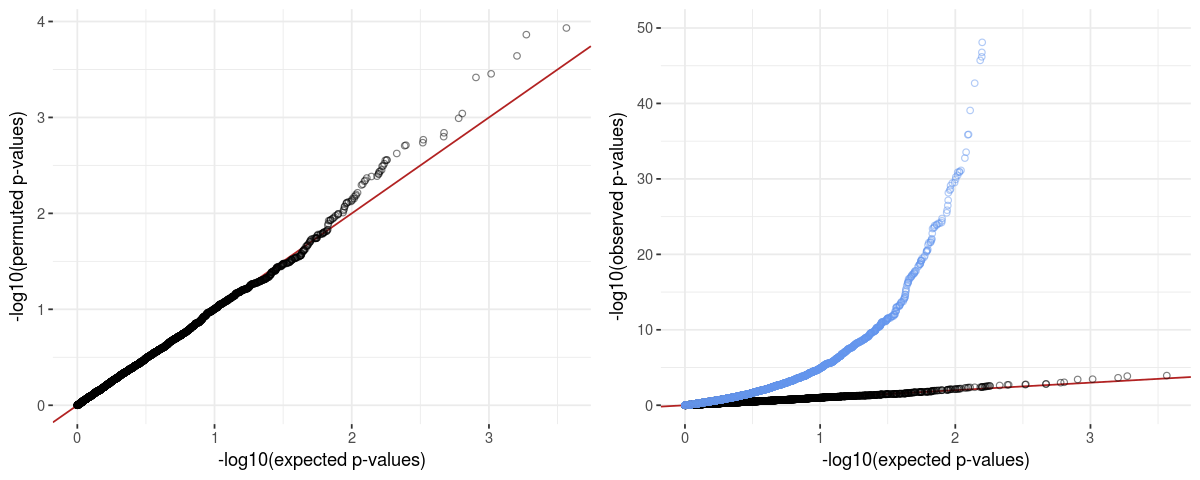

In [18]:
df = leads.int
df$pv_uniform = runif(dim(df)[1], min = 0, max = 1)
p1 = ggplot(df, aes(x = sort(-log10(pv_uniform)), y = sort(-log10(permutation_0)))) + 
        geom_abline(slope = 1, intercept = 0, col = "firebrick") +
        geom_point(alpha = 0.5, pch = 1) + xlab("-log10(expected p-values)") + ylab("-log10(permuted p-values)") +
        theme_bw() + 
        theme(legend.position="none", panel.border = element_blank())
p2 = ggplot(df) + 
        geom_abline(slope = 1, intercept = 0, col = "firebrick") +
        geom_point(alpha = 0.5, pch = 1, aes(x = sort(-log10(pv_uniform)), y = sort(-log10(permutation_0)))) +
        geom_point(color = "cornflowerblue", alpha = 0.5, pch = 1, 
                   aes(x = sort(-log10(pv_uniform)), y = sort(-log10(p_value)))) + 
        xlab("-log10(expected p-values)") + ylab("-log10(observed p-values)") + 
        theme_bw() + ylim(c(0,50)) +
        theme(legend.position="none", panel.border = element_blank())
options(repr.plot.width = 10, repr.plot.height = 4) 
library(cowplot)
plot_grid(p1, p2, ncol = 2)

In [7]:
folder <- "/nfs/leia/research/stegle/acuomo/mean/bulk_ipsc/"
# leads <- GetTopResults(folder)
# dim(leads)
# dim(leads[leads$global_corr_p_value < 0.1,])
# leads_bulk = leads
res <- GetResults(folder)
res_bulk = res

In [8]:
# write.csv(leads_bulk,"/nfs/leia/research/stegle/acuomo/mean/bulk_ipsc/leads.csv")
write.csv(res_bulk,"/nfs/leia/research/stegle/acuomo/mean/bulk_ipsc/allresults.csv")

In [8]:
folder <- "/nfs/leia/research/stegle/acuomo/mean/day1/"
leads <- GetTopResults(folder)
dim(leads)
dim(leads[leads$global_corr_p_value < 0.1,])
leads_day1 = leads

[1] 10787    11

[1] 1181   11

In [11]:
write.csv(leads_day1, "/nfs/leia/research/stegle/acuomo/mean/day1/leads.csv")

In [9]:
folder <- "/nfs/leia/research/stegle/acuomo/mean/day3/"
leads <- GetTopResults(folder)
dim(leads)
dim(leads[leads$global_corr_p_value < 0.1,])
leads_day3 = leads

[1] 10765    11

[1] 631  11

In [12]:
write.csv(leads_day3, "/nfs/leia/research/stegle/acuomo/mean/day3/leads.csv")

In [21]:
folder0 <- "/nfs/leia/research/stegle/acuomo/mean_day3_chr1/logcounts_all_107don_expt_defendo/" # all 
leads0 <- GetTopResults(folder0)
folder1 <- "/nfs/leia/research/stegle/acuomo/mean_day3_chr1/logcounts_all_107don_expt_defendo_gtex_pancreas/" # endo
leads1 <- GetTopResults(folder1)
folder2 <- "/nfs/leia/research/stegle/acuomo/mean_day3_chr1/logcounts_all_107don_expt_defendo_gtex_heart/" # meso
leads2 <- GetTopResults(folder2)
folder3 <- "/nfs/leia/research/stegle/acuomo/mean_day3_chr1/logcounts_all_107don_expt_defendo_leads/" # iPSC
leads3 <- GetTopResults(folder3)
folder4 <- "/nfs/leia/research/stegle/acuomo/mean_day3_chr1/logcounts_all_107don_expt_defendo_gtex_liver/" # endo
leads4 <- GetTopResults(folder4)

In [11]:
leads = leads0 # discoveries
leads$q_value <- qvalue(leads$empirical_feature_p_value)$qvalues # discoveries, need to use adjusted pvalues
leads = leads[order(leads$q_value),]
c(dim(leads)[1], dim(leads[leads$q_value < 0.1,])[1]) # 2.7 %

[1] 11301   302

In [18]:
leads = leads1  # leads pancreas (endo)
leads$q_value <- qvalue(leads$p_value)$qvalues
leads = leads[order(leads$q_value),]
c(dim(leads)[1], dim(leads[leads$q_value < 0.1,])[1]) #  16.7%

[1] 2353  392

In [19]:
leads = leads2 # leads heart (meso)
leads$q_value <- qvalue(leads$p_value)$qvalues
leads = leads[order(leads$q_value),]
c(dim(leads)[1], dim(leads[leads$q_value < 0.1,])[1]) # 15.1%

[1] 2498  377

In [20]:
leads = leads3 # leads iPSC 
leads$q_value <- qvalue(leads$p_value)$qvalues
leads = leads[order(leads$q_value),]
c(dim(leads)[1], dim(leads[leads$q_value < 0.1,])[1]) # 14.8%

[1] 4439  657

In [22]:
leads = leads4 # leads liver (endo)
leads$q_value <- qvalue(leads$p_value)$qvalues
leads = leads[order(leads$q_value),]
c(dim(leads)[1], dim(leads[leads$q_value < 0.1,])[1]) # 23.2%

[1] 1150  267

In [60]:
myfile = "/hps/nobackup/stegle/users/mjbonder/tools/hipsci_pipeline/geuvadis_CEU_test_data/limix_QTL_results_kinship_covs_interaction_copy/qtl_results_1.h5"

In [61]:
results <- NULL
tmp <- h5dump(file = myfile)
if ( length(tmp) > 0 ) {
    for ( j in names(tmp) ) { tmp[[j]][["feature"]] <- j }
      df <- bind_rows(tmp)
      if ( nrow(df) > 0 ) { 
          df <- df[,!(colnames(df) %in% c("group","name", "otype", "dclass",  "dim"))]
          results = rbind(results,df) }}

In [59]:
results1 = results[order(results$p_value),]

In [62]:
results2 = results[order(results$p_value),]

In [63]:
join = inner_join(results1, results2, by = c("feature","snp_id"),suffix = c(".1",".2"))

In [65]:
cor(join$p_value.1, join$p_value.2)

[1] 1

In [42]:
# folderint <- "/nfs/leia/research/stegle/acuomo/interactions/alldays/pseudotime_pc1_top500hvgs_10expanded_pcs_517donor_expt_day_leads/"
# leadsint <- GetResults(folderint)

In [26]:
head(leadsint)

NULL

In [21]:
leadsint$q_value <- qvalue(leadsint$p_value)$qvalues
leadsint = leadsint[order(leadsint$q_value),]

Warning message in is.na(p):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in min(p):
“no non-missing arguments to min; returning Inf”Warning message in max(p):
“no non-missing arguments to max; returning -Inf”Warning message in is.na(p):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in min(p):
“no non-missing arguments to min; returning Inf”Warning message in max(p):
“no non-missing arguments to max; returning -Inf”

ERROR: Error in smooth.spline(lambda, pi0, df = smooth.df): missing or infinite values in inputs are not allowed


In [22]:
sum(leadsint$p_value)

[1] 0

In [5]:
folderint <- "/nfs/leia/research/stegle/acuomo/interactions/alldays/pseudotime_slalom_10expanded_pcs_435donor_expt_day_leads//"
leadsint <- GetTopResults(folderint)

In [6]:
leadsint$q_value <- qvalue(leadsint$p_value)$qvalues
leadsint = leadsint[order(leadsint$q_value),]

In [7]:
dim(leadsint[leadsint$q_value < 0.1,])

[1] 1903   12

In [48]:
permsint <- GetPerms(folderint)
leads_int <- left_join(leadsint, permsint, by = c("snp_id", "feature"))
head(leads_int)

In [71]:
write.csv(leads_int, "/nfs/leia/research/stegle/acuomo/interactions/alldays/results/leads_pseudotime_slalom_10expanded_pcs_435donor_expt_day_leads.csv", row.names=FALSE)

In [57]:
a = read.csv("/nfs/leia/research/stegle/acuomo/interactions/alldays/results/leads_pseudotime_slalom_10expanded_pcs_435donor_expt_day_leads.csv")
head(a)

beta       beta_se     empirical_feature_p_value p_value      
1 -0.3234132 0.008615658  0.000000e+00             2.225074e-308
2 -0.1878077 0.010102182  3.599160e-95              3.814263e-77
3  0.1681653 0.009338797 2.640395e-108              1.711740e-72
4  0.1775486 0.010274734 1.551025e-100              6.640818e-67
5 -0.1505985 0.009408523  1.117025e-88              1.149126e-57
6  0.1432611 0.009680062  4.380611e-84              1.473453e-49
  snp_id          feature  global_corr_p_value chrom pos       ref_allele ⋯
1 6_31132414_G_A  POU5F1    0.000000e+00        6     31132414 G          ⋯
2 9_136227260_A_G SURF2     1.906890e-92        9    136227260 A          ⋯
3 6_32609105_G_A  HLA-DQB1 2.448114e-105        6     32609105 G          ⋯
4 8_144124512_T_C C8orf31   9.587167e-98        8    144124512 T          ⋯
5 16_31522723_T_C AHSP      4.142719e-86       16     31522723 T          ⋯
6 12_7947017_T_C  NANOGP1   1.476946e-81       12      7947017 T          ⋯
  permutation_0 permutation_1 permutation_2 permutation_3 permutation_4
1 0.5085450     0.6522448     0.4354568     0.9202535     0.3202897    
2 0.9184653     0.1241377     0.5969161     0.5385222     0.5716370    
3 0.5697422     0.4302006     0.7231238     0.5171807     0.6840758    
4 0.9462936     0.9538675     0.9377459     0.5875881     0.3573222    
5 0.2841232     0.7048835     0.4835038     0.9656566     0.7342550    
6 0.9749212     0.8404390     0.3599055     0.3233809     0.7872071    
  permutation_5 permutation_6 permutation_7 permutation_8 permutation_9
1 0.3773946     0.66423110    0.7091934     0.6109344     0.4446003    
2 0.7310207     0.04781364    0.7878427     0.5620658     0.2465766    
3 0.6930863     0.03387237    0.4131565     0.1204733     0.6694462    
4 0.1821545     0.28182220    0.9266597     0.5736801     0.8751325    
5 0.1306706     0.48668143    0.9603731     0.6129893     0.5012756    
6 0.7432527     0.32913354    0.2929436     0.5113648     0.3257044

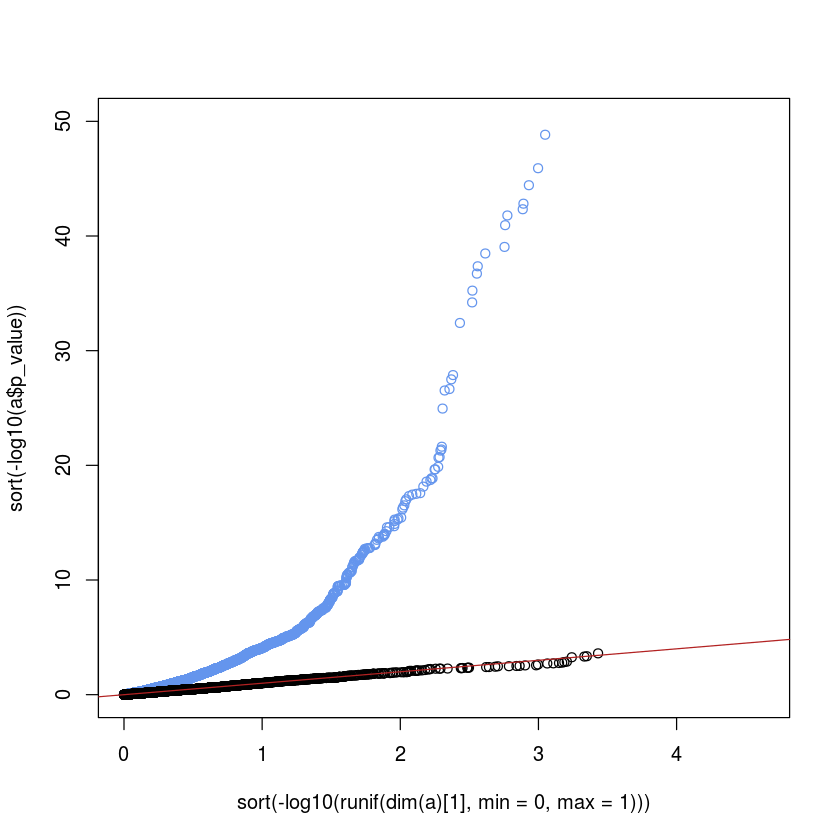

In [94]:
plot(sort(-log10(runif(dim(a)[1], min = 0, max = 1))), sort(-log10(a$p_value)),
    col = "cornflowerblue", ylim = c(0,50))
points(sort(-log10(runif(dim(a)[1], min = 0, max = 1))), sort(-log10(a$permutation_9)))
abline(0,1, col = "firebrick")

In [58]:
leadsint = a
dim(leadsint)
dim(leadsint[leadsint$q_value < 0.1,])
head(leadsint)

[1] 4563   22

[1] 1947   22

beta       beta_se     empirical_feature_p_value p_value      
1 -0.3234132 0.008615658  0.000000e+00             2.225074e-308
2 -0.1878077 0.010102182  3.599160e-95              3.814263e-77
3  0.1681653 0.009338797 2.640395e-108              1.711740e-72
4  0.1775486 0.010274734 1.551025e-100              6.640818e-67
5 -0.1505985 0.009408523  1.117025e-88              1.149126e-57
6  0.1432611 0.009680062  4.380611e-84              1.473453e-49
  snp_id          feature  global_corr_p_value chrom pos       ref_allele ⋯
1 6_31132414_G_A  POU5F1    0.000000e+00        6     31132414 G          ⋯
2 9_136227260_A_G SURF2     1.906890e-92        9    136227260 A          ⋯
3 6_32609105_G_A  HLA-DQB1 2.448114e-105        6     32609105 G          ⋯
4 8_144124512_T_C C8orf31   9.587167e-98        8    144124512 T          ⋯
5 16_31522723_T_C AHSP      4.142719e-86       16     31522723 T          ⋯
6 12_7947017_T_C  NANOGP1   1.476946e-81       12      7947017 T          ⋯
  permutation_0 permutation_1 permutation_2 permutation_3 permutation_4
1 0.5085450     0.6522448     0.4354568     0.9202535     0.3202897    
2 0.9184653     0.1241377     0.5969161     0.5385222     0.5716370    
3 0.5697422     0.4302006     0.7231238     0.5171807     0.6840758    
4 0.9462936     0.9538675     0.9377459     0.5875881     0.3573222    
5 0.2841232     0.7048835     0.4835038     0.9656566     0.7342550    
6 0.9749212     0.8404390     0.3599055     0.3233809     0.7872071    
  permutation_5 permutation_6 permutation_7 permutation_8 permutation_9
1 0.3773946     0.66423110    0.7091934     0.6109344     0.4446003    
2 0.7310207     0.04781364    0.7878427     0.5620658     0.2465766    
3 0.6930863     0.03387237    0.4131565     0.1204733     0.6694462    
4 0.1821545     0.28182220    0.9266597     0.5736801     0.8751325    
5 0.1306706     0.48668143    0.9603731     0.6129893     0.5012756    
6 0.7432527     0.32913354    0.2929436     0.5113648     0.3257044

In [50]:
folderm3 <- "/nfs/leia/research/stegle/acuomo/means/day3/mean_day3_1000perms_10pcs_103don_expt/"
leadsm3 <- GetTopResults(folderm3)

dim(leadsm3[leadsm3$global_corr_p_value < 0.1,])

In [53]:
dim(leadsm3)

[1] 11301    11

In [6]:
# plot(sort(-log10(runif(dim(leadsm3)[1], min = 0, max = 1))), sort(-log10(leadsm3$p_value)),
#     col = "cornflowerblue")
# abline(0,1, col = "firebrick")

In [56]:
write.csv(leadsm3,"/nfs/leia/research/stegle/acuomo/means/day3/results/mean_day3_1000perms_10pcs_103don_expt_leads.csv")

In [15]:
# folder_g2m <- "/nfs/leia/research/stegle/acuomo/interactions/day0/g2m_slalom_10expanded_pcs_donor_expt_no19_20_24_leads/"
# leads_g2m <- GetResults(folder_g2m)

In [9]:
# folder1 <- "/nfs/leia/research/stegle/acuomo/mean_day3_chr1/mnn_all_103don_expt/"
# leads1 <- GetTopResults(folder1)
# #
# folder2 <- "/nfs/leia/research/stegle/acuomo/mean_day3_chr1/mnn_all_96don_noexpt27_28/"
# leads2 <- GetTopResults(folder2)
# #
# folder3 <- "/nfs/leia/research/stegle/acuomo/mean_day3_chr1/mnn_all_77don_noexpt19_27_28_30/"
# leads3 <- GetTopResults(folder3)
# #
# folder4 <- "/nfs/leia/research/stegle/acuomo/mean_day3_chr1/logcounts_all_103don_expt/"
# leads4 <- GetTopResults(folder4)
# #
# # folder5 <- "/nfs/leia/research/stegle/acuomo/mean_day3_chr1/logcounts_all_96don_noexpt27_28/"
# # leads5 <- GetTopResults(folder5)
# #
# folder6 <- "/nfs/leia/research/stegle/acuomo/mean_day3_chr1/logcounts_all_77don_noexpt19_27_28_30/"
# leads6 <- GetTopResults(folder6)
#
folder7 <- "/nfs/leia/research/stegle/acuomo/mean_day3_chr1/logcounts_all_107don_expt_defendo/"
leads7 <- GetTopResults(folder7)

In [ ]:
folder8 <- "/nfs/leia/research/stegle/acuomo/mean_day3_chr1/logcounts_all_107don_expt_defendo_gtex_pancreas/"
leads8 <- GetTopResults(folder8)

In [10]:
folder9 <- "/nfs/leia/research/stegle/acuomo/mean_day3_chr1/logcounts_all_107don_expt_defendo_gwas/"
leads9 <- GetTopResults(folder9)

In [11]:
# c(dim(leads1)[1], dim(leads1[leads1$global_corr_p_value < 0.1,])[1]) # day3 mnn all
# c(dim(leads2)[1], dim(leads2[leads2$global_corr_p_value < 0.1,])[1]) # day3 all-(expt27, expt28)
# c(dim(leads3)[1], dim(leads3[leads3$global_corr_p_value < 0.1,])[1]) # day3 mnn all-(expt19, expt27, expt28, expt30)
# c(dim(leads4)[1], dim(leads4[leads4$global_corr_p_value < 0.1,])[1]) # day3 logcounts all
# c(dim(leads5)[1], dim(leads5[leads5$global_corr_p_value < 0.1,])[1]) # day3 logcounts all-(expt27, expt28)
# c(dim(leads6)[1], dim(leads6[leads6$global_corr_p_value < 0.1,])[1]) # day3 logcounts all-(expt19, expt27, expt28, expt30)
# c(dim(leads7)[1], dim(leads7[leads7$global_corr_p_value < 0.1,])[1]) # defendo logcounts all  # 3%
# c(dim(leads8)[1], dim(leads8[leads8$global_corr_p_value < 0.1,])[1]) # defendo logcounts GTEx pancreas # 14%
c(dim(leads9)[1], dim(leads9[leads9$global_corr_p_value < 0.1,])[1]) # defendo logcounts GWAS hits # % 2.2 %

[1] 6869  154

In [63]:
leads5[leads5$global_corr_p_value < 0.1,]

beta       beta_se   empirical_feature_p_value p_value     
304715 -1.7686493 0.3260557 0.0001100033              5.815687e-08
336614 -0.5548533 0.1168758 0.0002790040              2.060727e-06
144108  0.5435208 0.1336999 0.0003041310              4.798536e-05
       snp_id          feature global_corr_p_value chrom pos       ref_allele
304715 1_24170131_C_T  SPTY2D1 0.08515667          1      24170131 C         
336614 1_247371918_T_C TRIM14  0.08515667          1     247371918 T         
144108 1_205753877_C_A INTS4   0.08515667          1     205753877 C         
       alt_allele
304715 T         
336614 C         
144108 A

In [89]:
head(leads7[leads7$global_corr_p_value < 0.1,])

beta       beta_se    empirical_feature_p_value p_value     
2036451 -1.2344111 0.13100726 1.512997e-20              4.406264e-21
3428866 -1.5320238 0.16081731 5.773362e-13              1.626972e-21
3444870 -0.9389422 0.12183732 3.131984e-12              1.292912e-14
1607037 -0.8342633 0.09478987 9.475605e-12              1.353773e-18
3145121 -0.6928017 0.08772365 1.567837e-11              2.844450e-15
306492  -1.0411148 0.12458840 4.346681e-11              6.464248e-17
        snp_id          feature global_corr_p_value chrom pos       ref_allele
2036451 19_8387207_G_A  RPS28   1.228705e-16        19      8387207 G         
3428866 6_31239722_A_C  HLA-C   2.344273e-09         6     31239722 A         
3444870 6_32145707_A_C  AGPAT1  8.478279e-09         6     32145707 A         
1607037 17_7207964_A_C  EIF5A   1.923785e-08        17      7207964 A         
3145121 5_149808764_C_G RPS14   2.546481e-08         5    149808764 C         
306492  1_75189847_T_C  CRYZ    4.868198e-08         1     75189847 T         
        alt_allele
2036451 A         
3428866 C         
3444870 C         
1607037 C         
3145121 G         
306492  C

In [90]:
write.csv(leads7, "/nfs/leia/research/stegle/acuomo/means/defendo/results/leads_defendo_logcounts_10pcs.csv", row.names=FALSE)

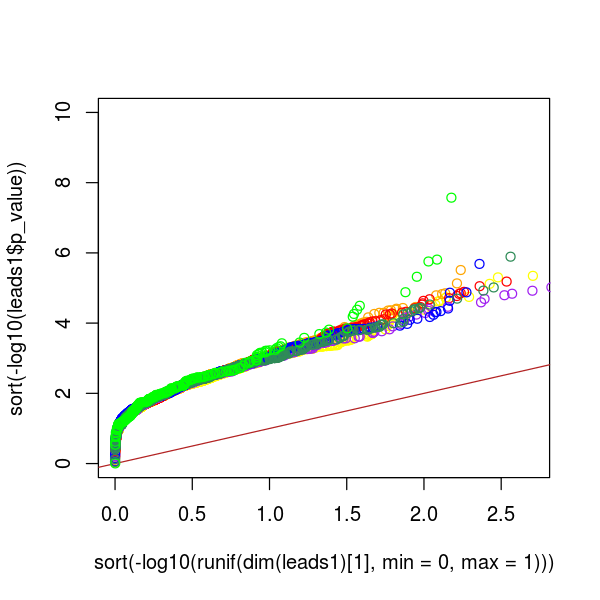

In [65]:
par(mfrow=c(1,1))
options(repr.plot.width = 5, repr.plot.height = 5)
plot(sort(-log10(runif(dim(leads1)[1], min = 0, max = 1))), sort(-log10(leads1$p_value)), col = "yellow", ylim = c(0,10))
abline(0,1, col = "firebrick")
points(sort(-log10(runif(dim(leads2)[1], min = 0, max = 1))), sort(-log10(leads2$p_value)), col = "orange")
points(sort(-log10(runif(dim(leads3)[1], min = 0, max = 1))), sort(-log10(leads3$p_value)), col = "red")
points(sort(-log10(runif(dim(leads4)[1], min = 0, max = 1))), sort(-log10(leads4$p_value)), col = "purple")
points(sort(-log10(runif(dim(leads5)[1], min = 0, max = 1))), sort(-log10(leads5$p_value)), col = "blue")
points(sort(-log10(runif(dim(leads6)[1], min = 0, max = 1))), sort(-log10(leads6$p_value)), col = "seagreen")
points(sort(-log10(runif(dim(leads7)[1], min = 0, max = 1))), sort(-log10(leads7$p_value)), col = "green")

In [18]:
# alpha day0
folder_v = "/nfs/leia/research/stegle/acuomo/variances/alpha/day0_1000perms_10pcs/"
# resv <- GetResults(folder_v)

In [19]:
leadsv <- GetTopResults(folder_v)

In [ ]:
dim(leadsv)
dim(leadsv[leadsv$global_corr_p_value < 0.1,])

In [62]:
# early alpha results
folder_a = "/nfs/leia/research/stegle/acuomo/alphas/62samples_day0_hvgs_tf_0pcscells_0pcslines/"
resa <- GetResults(folder_a)
leadsa <- GetTopResults(folder_a)

In [72]:
dim(leadsa)
dim(leadsa[leadsa$global_corr_p_value < 0.1,])

[1] 4500   12

[1] 26 12

In [76]:
write.csv(leadsa, "/hps/nobackup/stegle/users/acuomo/singlecell_endodiff/variance_eqtls/old_alpha_results.csv")

In [74]:
#leadsa[leadsa$global_corr_p_value < 0.1,]

In [13]:
folderm = "/nfs/leia/research/stegle/acuomo/mean/mesendo_est_June20_perms/"
res_m <- GetResults(folderm)
perms_m <- GetPerms(folderm)

In [9]:
folderm = "/nfs/leia/research/stegle/acuomo/mean/mesendo_est_June20/"
leads_m <- GetTopResults(folderm)

In [10]:
dim(leads_m[leads_m$global_corr_p_value < 0.1,]) # 16%

[1] 1679   11

In [12]:
dim(leads_m)

[1] 10788    11

In [14]:
leads <- left_join(leads_m, perms_m, by = c("snp_id", "feature"))
results <- left_join(res_m, perms_m, by = c("snp_id", "feature"))

In [15]:
write.csv(results, "/nfs/leia/research/stegle/acuomo/mean/mesendo_est_June20/allresults.csv")
write.csv(leads, "/nfs/leia/research/stegle/acuomo/mean/mesendo_est_June20/leads.csv")

In [17]:
folderm = "/nfs/leia/research/stegle/acuomo/mean/defendo_est_June20_perms/"
res_m <- GetResults(folderm)
perms_m <- GetPerms(folderm)

In [18]:
folderm = "/nfs/leia/research/stegle/acuomo/mean/defendo_est_June20/"
leads_m <- GetTopResults(folderm)

In [19]:
dim(leads_m[leads_m$global_corr_p_value < 0.1,]) # 12%
dim(leads_m)

[1] 1322   11

[1] 10788    11

In [20]:
leads <- left_join(leads_m, perms_m, by = c("snp_id", "feature"))
results <- left_join(res_m, perms_m, by = c("snp_id", "feature"))

In [21]:
write.csv(results, "/nfs/leia/research/stegle/acuomo/mean/defendo_est_June20/allresults.csv")
write.csv(leads, "/nfs/leia/research/stegle/acuomo/mean/defendo_est_June20/leads.csv")

In [19]:
folderm = "/nfs/leia/research/stegle/acuomo/mean/day0/expts_from27_perms/"
res_m <- GetResults(folderm)
perms_m <- GetPerms(folderm)

In [20]:
folderm = "/nfs/leia/research/stegle/acuomo/mean/day0/expts_from27/"
leads_m <- GetTopResults(folderm)

In [21]:
dim(leads_m[leads_m$global_corr_p_value < 0.1,])

[1] 1375   11

In [23]:
leads <- left_join(leads_m, perms_m, by = c("snp_id", "feature"))
results <- left_join(res_m, perms_m, by = c("snp_id", "feature"))

In [24]:
write.csv(results, "/nfs/leia/research/stegle/acuomo/mean/day0/expts_from27/allresults.csv")
write.csv(leads, "/nfs/leia/research/stegle/acuomo/mean/day0/expts_from27/leads.csv")

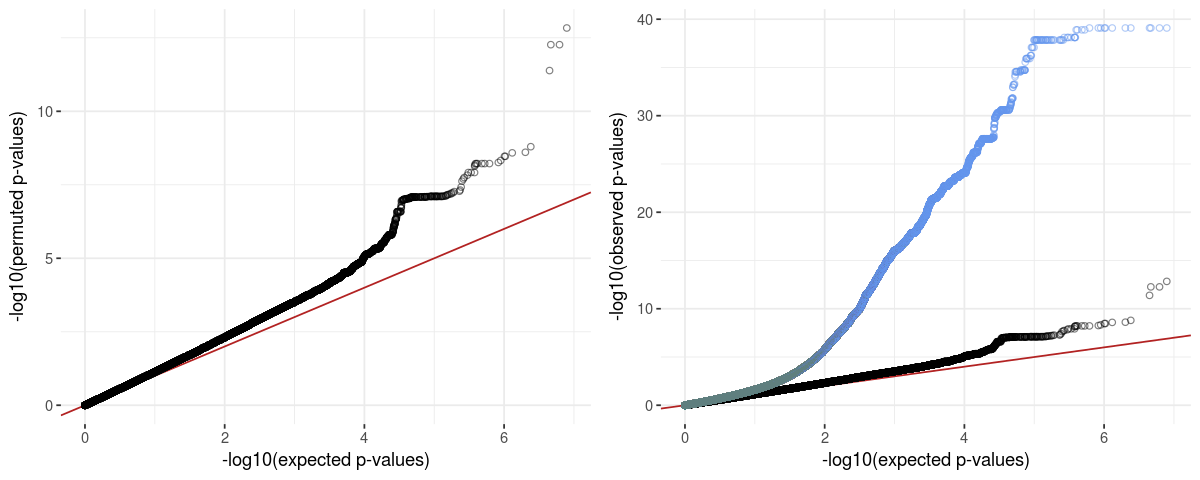

In [13]:
df = results
df$pv_uniform = runif(dim(df)[1], min = 0, max = 1)
p1 = ggplot(df, aes(x = sort(-log10(pv_uniform)), y = sort(-log10(permutation_3)))) + 
        geom_abline(slope = 1, intercept = 0, col = "firebrick") +
        geom_point(alpha = 0.5, pch = 1) + xlab("-log10(expected p-values)") + ylab("-log10(permuted p-values)") +
        theme_bw() + 
        theme(legend.position="none", panel.border = element_blank())
p2 = ggplot(df) + 
        geom_abline(slope = 1, intercept = 0, col = "firebrick") +
        geom_point(alpha = 0.5, pch = 1, aes(x = sort(-log10(pv_uniform)), y = sort(-log10(permutation_3)))) +
        geom_point(color = "cornflowerblue", alpha = 0.5, pch = 1, 
                   aes(x = sort(-log10(pv_uniform)), y = sort(-log10(p_value)))) + 
        xlab("-log10(expected p-values)") + ylab("-log10(observed p-values)") + 
        theme_bw() + 
        theme(legend.position="none", panel.border = element_blank())
options(repr.plot.width = 10, repr.plot.height = 4) 
library(cowplot)
plot_grid(p1, p2, ncol = 2)

In [10]:
folderm = "/nfs/leia/research/stegle/acuomo/mean/day0/all_expts_perms/"
res_m <- GetResults(folderm)
perms_m <- GetPerms(folderm)

In [11]:
folderm = "/nfs/leia/research/stegle/acuomo/mean/day0/all_expts/"
leads_m <- GetTopResults(folderm)

In [12]:
dim(leads_m[leads_m$global_corr_p_value < 0.1,])

[1] 1823   11

In [13]:
leads <- left_join(leads_m, perms_m, by = c("snp_id", "feature"))

In [14]:
results <- left_join(res_m, perms_m, by = c("snp_id", "feature"))

In [16]:
head(leads)

beta       beta_se    empirical_feature_p_value p_value      snp_id         
1 -1.0048674 0.08005311 3.631688e-34              3.851118e-36 5_149826526_C_T
2 -0.9881017 0.08648823 2.432216e-26              3.147553e-30 11_57283988_C_T
3 -0.8408477 0.07424087 3.349038e-26              9.762508e-30 12_56401085_G_A
4 -1.0706501 0.08926800 4.722792e-26              3.835702e-33 17_79634162_T_G
5 -1.1430440 0.08765845 6.913686e-26              7.269794e-39 6_31486901_T_C 
6 -1.4578537 0.10202454 9.536615e-26              2.553619e-46 4_39446549_G_A 
  feature                global_corr_p_value chrom pos       ref_allele ⋯
1 ENSG00000164587_RPS14  2.880363e-30         5    149826526 C          ⋯
2 ENSG00000134809_TIMM10 8.853960e-23        11     57283988 C          ⋯
3 ENSG00000197728_RPS26  8.853960e-23        12     56401085 G          ⋯
4 ENSG00000214087_ARL16  9.364347e-23        17     79634162 T          ⋯
5 ENSG00000198563_DDX39B 1.096676e-22         6     31486901 T          ⋯
6 ENSG00000163682_RPL9   1.260613e-22         4     39446549 G          ⋯
  permutation_0 permutation_1 permutation_2 permutation_3 permutation_4
1 0.243115910   0.58674150    0.56508683    0.62964575    0.004683908  
2 0.483310391   0.10935482    0.08194005    0.68972605    0.683497330  
3 0.107322700   0.41005731    0.23164373    0.71630027    0.538610967  
4 0.161680879   0.36695014    0.72872843    0.85009167    0.939250380  
5 0.720166096   0.89405572    0.95763092    0.05611457    0.324275368  
6 0.007481996   0.02499141    0.65163891    0.46817225    0.383334373  
  permutation_5 permutation_6 permutation_7 permutation_8 permutation_9
1 0.51595915    0.77340279    0.6450821     0.60012089    0.987664638  
2 0.51375107    0.78775720    0.6064095     0.54198610    0.565444092  
3 0.21066157    0.95163870    0.8791886     0.53991793    0.006102551  
4 0.24618455    0.50471966    0.2533529     0.12566441    0.010889631  
5 0.17382894    0.54062651    0.5728666     0.59261689    0.085712979  
6 0.05690061    0.02657527    0.2945979     0.02514148    0.708832480

In [17]:
write.csv(results, "/nfs/leia/research/stegle/acuomo/mean/day0/all_expts/allresults.csv")
write.csv(leads, "/nfs/leia/research/stegle/acuomo/mean/day0/all_expts/leads.csv")


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



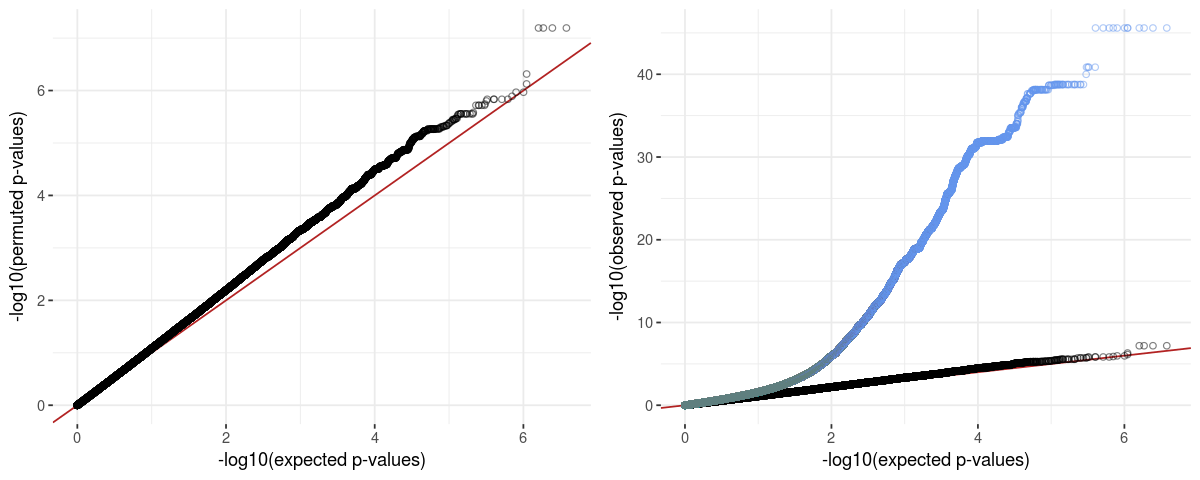

In [18]:
df = results
df$pv_uniform = runif(dim(df)[1], min = 0, max = 1)
p1 = ggplot(df, aes(x = sort(-log10(pv_uniform)), y = sort(-log10(permutation_3)))) + 
        geom_abline(slope = 1, intercept = 0, col = "firebrick") +
        geom_point(alpha = 0.5, pch = 1) + xlab("-log10(expected p-values)") + ylab("-log10(permuted p-values)") +
        theme_bw() + 
        theme(legend.position="none", panel.border = element_blank())
p2 = ggplot(df) + 
        geom_abline(slope = 1, intercept = 0, col = "firebrick") +
        geom_point(alpha = 0.5, pch = 1, aes(x = sort(-log10(pv_uniform)), y = sort(-log10(permutation_3)))) +
        geom_point(color = "cornflowerblue", alpha = 0.5, pch = 1, 
                   aes(x = sort(-log10(pv_uniform)), y = sort(-log10(p_value)))) + 
        xlab("-log10(expected p-values)") + ylab("-log10(observed p-values)") + 
        theme_bw() + 
        theme(legend.position="none", panel.border = element_blank())
options(repr.plot.width = 10, repr.plot.height = 4) 
library(cowplot)
plot_grid(p1, p2, ncol = 2)

In [85]:
dim(leads_v)
dim(leads_v[leads_v$global_corr_p_value < 0.1,])

[1] 4565   11

[1]  7 11

In [81]:
leads_v[leads_v$global_corr_p_value < 0.1,]

beta       beta_se    empirical_feature_p_value p_value     
1501462 -4.4806809 0.63506597 6.565995e-08              1.720339e-12
1855224  3.7688366 0.47336136 2.707345e-07              1.694732e-15
2048267  3.6746233 0.69845544 1.581809e-06              1.432191e-07
1854298 -1.1441528 0.23350498 2.766668e-06              9.588180e-07
733244  -3.9185631 0.56257335 1.080993e-05              3.274115e-12
836517   0.2875824 0.05454763 2.349242e-05              1.348472e-07
14894    3.2122198 0.69375177 4.223365e-05              3.652864e-06
        snp_id          feature                 global_corr_p_value chrom
1501462 3_39451516_A_G  ENSG00000168028_RPSA    0.0002997377         3   
1855224 6_30516458_T_C  ENSG00000204569_PPP1R10 0.0006179514         6   
2048267 8_109114261_G_A ENSG00000104408_EIF3E   0.0024069863         8   
1854298 6_30798324_C_G  ENSG00000137331_IER3    0.0031574597         6   
733244  16_58148584_G_A ENSG00000070770_CSNK2A2 0.0098694637        16   
836517  17_5380167_G_C  ENSG00000108559_NUP88   0.0178738182        17   
14894   1_113501545_C_G ENSG00000155380_SLC16A1 0.0275423718         1   
        pos       ref_allele alt_allele
1501462  39451516 A          G         
1855224  30516458 T          C         
2048267 109114261 G          A         
1854298  30798324 C          G         
733244   58148584 G          A         
836517    5380167 G          C         
14894   113501545 C          G

In [78]:
write.csv(leads_v, "/nfs/leia/research/stegle/acuomo/variances/var_mean/day0_noexpts19_20_24_10pcs_leads.csv", row.names=FALSE)

In [57]:
#folder = "/nfs/leia/research/stegle/acuomo/mean_day3_chr1/logcounts_all_107don_expt_defendo_perms/"
folder1 = "/nfs/leia/research/stegle/acuomo/mean/mesendo_est/"
folder2 = "/nfs/leia/research/stegle/acuomo/mean/defendo_est/"

In [58]:
leads1 = GetTopResults(folder1)

In [60]:
leads2 = GetTopResults(folder2)

In [59]:
dim(leads1)
dim(leads1[leads1$global_corr_p_value < 0.1,])

[1] 10743    11

[1] 1445   11

In [62]:
write.csv(leads1, "/nfs/leia/research/stegle/acuomo/mean/mesendo_est/leads.csv")

In [61]:
dim(leads2)
dim(leads2[leads2$global_corr_p_value < 0.1,])

[1] 10764    11

[1] 1581   11

In [63]:
write.csv(leads2, "/nfs/leia/research/stegle/acuomo/mean/defendo_est/leads.csv")

In [66]:
folder = "/nfs/leia/research/stegle/acuomo/mean/mesendo_est_perms/"

In [67]:
res = GetResults(folder)

In [68]:
head(res)

beta        beta_se    empirical_feature_p_value p_value     snp_id         
1  0.14173611 0.09599833 0.85552464                0.139824903 1_100335455_A_T
2  0.30398309 0.10481592 0.02949359                0.003729706 1_100335788_A_G
3 -0.07860599 0.09262461 0.99904252                0.396075375 1_100335883_A_G
4  0.14173611 0.09599833 0.85552464                0.139824903 1_100336361_C_T
5  0.13230783 0.09407437 0.89536808                0.159600231 1_100338055_A_G
6  0.14173611 0.09599833 0.85552464                0.139824903 1_100338335_A_G
  feature                
1 ENSG00000117620_SLC35A3
2 ENSG00000117620_SLC35A3
3 ENSG00000117620_SLC35A3
4 ENSG00000117620_SLC35A3
5 ENSG00000117620_SLC35A3
6 ENSG00000117620_SLC35A3

In [69]:
perms <- GetPerms(folder)
head(perms)

permutation_0 permutation_1 permutation_2 permutation_3 permutation_4
1 0.7808808     0.21171006    0.4770136     0.1436553     0.3100414    
2 0.4376731     0.15386223    0.5686989     0.8250995     0.3284163    
3 0.9042612     0.01977627    0.6094596     0.3316684     0.8084876    
4 0.7808808     0.21171006    0.4770136     0.1436553     0.3100414    
5 0.7396484     0.39268361    0.3040676     0.2555443     0.1854912    
6 0.7808808     0.21171006    0.4770136     0.1436553     0.3100414    
  permutation_5 permutation_6 permutation_7 permutation_8 permutation_9
1 0.9587869     0.7487644     0.1589454     0.1504915     0.007722802  
2 0.7828538     0.3831378     0.2687147     0.2112059     0.358622451  
3 0.5880556     0.7860322     0.4488280     0.5698328     0.081593114  
4 0.9587869     0.7487644     0.1589454     0.1504915     0.007722802  
5 0.9498632     0.7917051     0.1485932     0.2584397     0.011225571  
6 0.9587869     0.7487644     0.1589454     0.1504915     0.007722802  
  snp_id          feature                
1 1_100335455_A_T ENSG00000117620_SLC35A3
2 1_100335788_A_G ENSG00000117620_SLC35A3
3 1_100335883_A_G ENSG00000117620_SLC35A3
4 1_100336361_C_T ENSG00000117620_SLC35A3
5 1_100338055_A_G ENSG00000117620_SLC35A3
6 1_100338335_A_G ENSG00000117620_SLC35A3

In [70]:
results <- left_join(res, perms, by = c("snp_id", "feature"))

In [71]:
write.csv(results, "/nfs/leia/research/stegle/acuomo/mean/mesendo_est/allresults.csv")

In [38]:
library(cowplot)

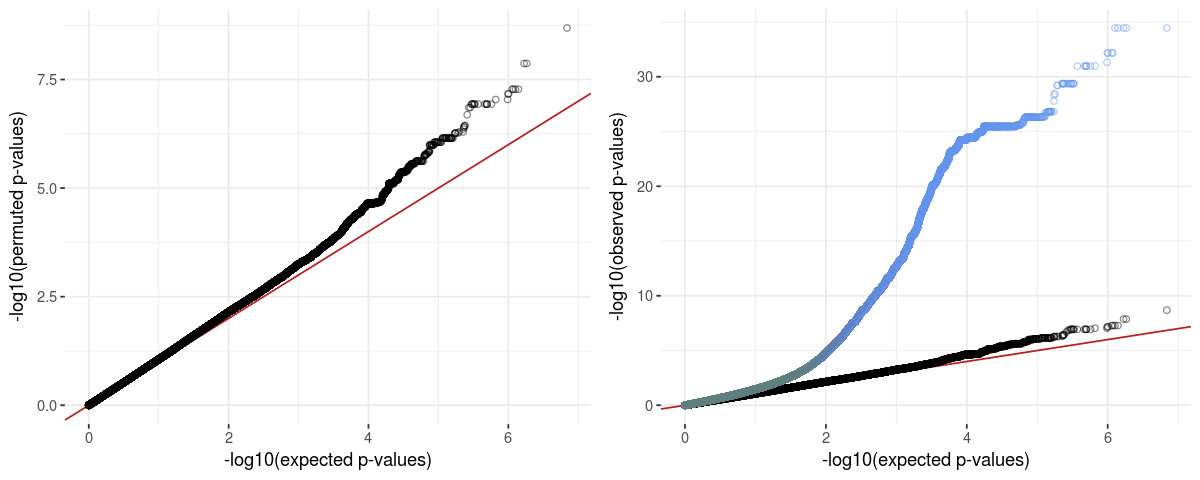

In [39]:
# defendo (est) (pseudotime, all ~35k cells in toal, ~10k used here)
df = results
df$pv_uniform = runif(dim(df)[1], min = 0, max = 1)
p1 = ggplot(df, aes(x = sort(-log10(pv_uniform)), y = sort(-log10(permutation_3)))) + 
        geom_abline(slope = 1, intercept = 0, col = "firebrick") +
        geom_point(alpha = 0.5, pch = 1) + xlab("-log10(expected p-values)") + ylab("-log10(permuted p-values)") +
        theme_bw() + 
        theme(legend.position="none", panel.border = element_blank())
p2 = ggplot(df) + 
        geom_abline(slope = 1, intercept = 0, col = "firebrick") +
        geom_point(alpha = 0.5, pch = 1, aes(x = sort(-log10(pv_uniform)), y = sort(-log10(permutation_3)))) +
        geom_point(color = "cornflowerblue", alpha = 0.5, pch = 1, 
                   aes(x = sort(-log10(pv_uniform)), y = sort(-log10(p_value)))) + 
        xlab("-log10(expected p-values)") + ylab("-log10(observed p-values)") + 
        theme_bw() + 
        theme(legend.position="none", panel.border = element_blank())
options(repr.plot.width = 10, repr.plot.height = 4) 
plot_grid(p1, p2, ncol = 2)

In [64]:
head(results)

beta        beta_se    empirical_feature_p_value p_value   snp_id         
1  0.03412296 0.07613702 0.9999999                 0.6540246 1_100335455_A_T
2  0.14702598 0.09110296 0.8278505                 0.1065612 1_100335788_A_G
3 -0.02765390 0.06921498 1.0000000                 0.6894981 1_100335883_A_G
4  0.03412296 0.07613702 0.9999999                 0.6540246 1_100336361_C_T
5  0.04309677 0.07276242 0.9999956                 0.5536535 1_100338055_A_G
6  0.03412296 0.07613702 0.9999999                 0.6540246 1_100338335_A_G
  feature                 permutation_0 permutation_1 permutation_2
1 ENSG00000117620_SLC35A3 0.8616946     0.8419733     0.4869730    
2 ENSG00000117620_SLC35A3 0.3565063     0.7814559     0.3960738    
3 ENSG00000117620_SLC35A3 0.7849302     0.4885688     0.6830646    
4 ENSG00000117620_SLC35A3 0.8616946     0.8419733     0.4869730    
5 ENSG00000117620_SLC35A3 0.6766096     0.7772251     0.3139400    
6 ENSG00000117620_SLC35A3 0.8616946     0.8419733     0.4869730    
  permutation_3 permutation_4 permutation_5 permutation_6 permutation_7
1 0.10874539    0.2808583     0.6493111     0.5232885     0.1540986    
2 0.45019344    0.2115690     0.6318434     0.4873161     0.2994196    
3 0.61824845    0.8619718     0.8230625     0.4933272     0.9204891    
4 0.10874539    0.2808583     0.6493111     0.5232885     0.1540986    
5 0.09893439    0.2422253     0.9782145     0.5304780     0.1768934    
6 0.10874539    0.2808583     0.6493111     0.5232885     0.1540986    
  permutation_8 permutation_9
1 0.6850777     0.4877673    
2 0.8521555     0.2844064    
3 0.7659574     0.3061544    
4 0.6850777     0.4877673    
5 0.6506061     0.4012163    
6 0.6850777     0.4877673

In [65]:
write.csv(results, "/nfs/leia/research/stegle/acuomo/mean/defendo_est/allresults.csv")

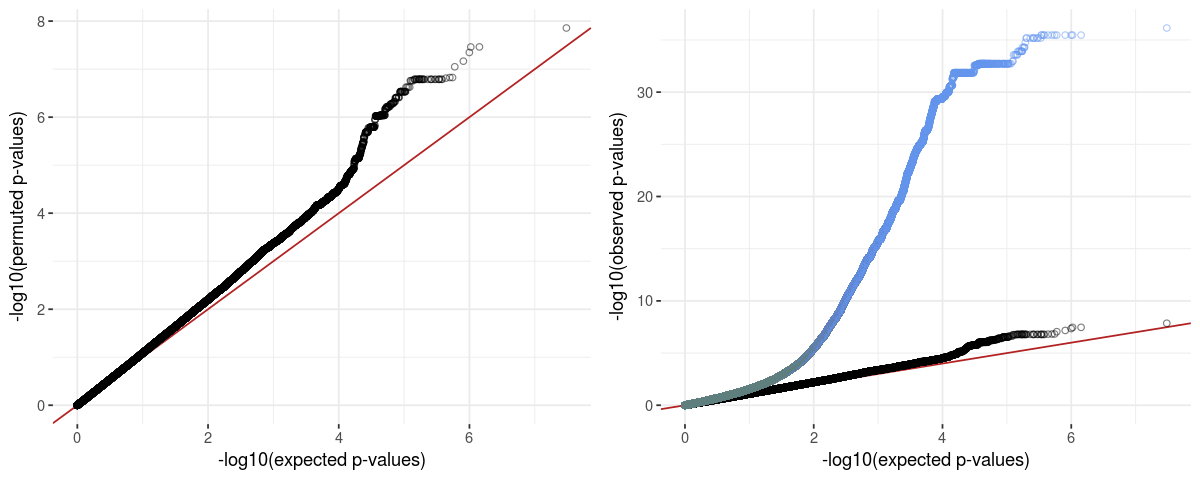

In [23]:
# mesendo (T + pseudotime, all ~35k cells in toal, ~10k used here)
df = results
df$pv_uniform = runif(dim(df)[1], min = 0, max = 1)
p1 = ggplot(df, aes(x = sort(-log10(pv_uniform)), y = sort(-log10(permutation_3)))) + 
        geom_abline(slope = 1, intercept = 0, col = "firebrick") +
        geom_point(alpha = 0.5, pch = 1) + xlab("-log10(expected p-values)") + ylab("-log10(permuted p-values)") +
        theme_bw() + 
        theme(legend.position="none", panel.border = element_blank())
p2 = ggplot(df) + 
        geom_abline(slope = 1, intercept = 0, col = "firebrick") +
        geom_point(alpha = 0.5, pch = 1, aes(x = sort(-log10(pv_uniform)), y = sort(-log10(permutation_3)))) +
        geom_point(color = "cornflowerblue", alpha = 0.5, pch = 1, 
                   aes(x = sort(-log10(pv_uniform)), y = sort(-log10(p_value)))) + 
        xlab("-log10(expected p-values)") + ylab("-log10(observed p-values)") + 
        theme_bw() + 
        theme(legend.position="none", panel.border = element_blank())
options(repr.plot.width = 10, repr.plot.height = 4) 
plot_grid(p1, p2, ncol = 2)

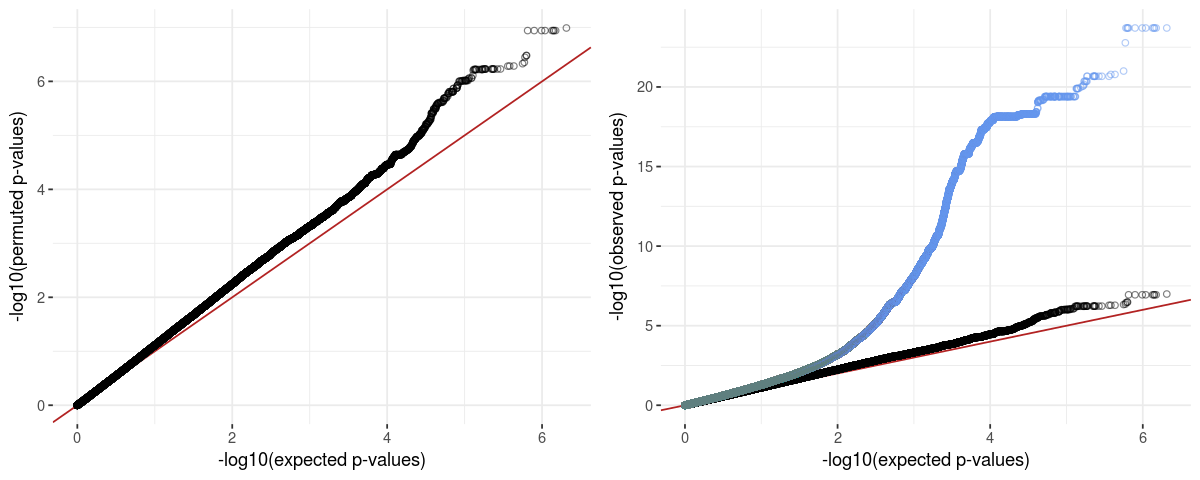

In [16]:
# defendo (CXCR4 pos, before last expts ~20k cells in toal, ~2.5k used here)
df = results
df$pv_uniform = runif(dim(df)[1], min = 0, max = 1)
p1 = ggplot(df, aes(x = sort(-log10(pv_uniform)), y = sort(-log10(permutation_3)))) + 
        geom_abline(slope = 1, intercept = 0, col = "firebrick") +
        geom_point(alpha = 0.5, pch = 1) + xlab("-log10(expected p-values)") + ylab("-log10(permuted p-values)") +
        theme_bw() + 
        theme(legend.position="none", panel.border = element_blank())
p2 = ggplot(df) + 
        geom_abline(slope = 1, intercept = 0, col = "firebrick") +
        geom_point(alpha = 0.5, pch = 1, aes(x = sort(-log10(pv_uniform)), y = sort(-log10(permutation_3)))) +
        geom_point(color = "cornflowerblue", alpha = 0.5, pch = 1, 
                   aes(x = sort(-log10(pv_uniform)), y = sort(-log10(p_value)))) + 
        xlab("-log10(expected p-values)") + ylab("-log10(observed p-values)") + 
        theme_bw() + 
        theme(legend.position="none", panel.border = element_blank())
options(repr.plot.width = 10, repr.plot.height = 4) 
plot_grid(p1, p2, ncol = 2)

In [1]:
# cc int day0
folderint = "/nfs/leia/research/stegle/acuomo/interactions/day0/g2m_slalom_10expanded_pcs_donor_expt_no19_20_24_leads/"

In [10]:
leadsint <- GetTopResults(folderint)

In [11]:
leadsint$q_value <- qvalue(leadsint$p_value)$qvalues
leadsint = leadsint[order(leadsint$q_value),]
dim(leadsint)
dim(leadsint[leadsint$q_value < 0.1,]) # 

[1] 8543   12

[1] 31 12

In [12]:
permsint <- GetPerms(folderint)
leads_int <- left_join(leadsint, permsint, by = c("snp_id", "feature"))

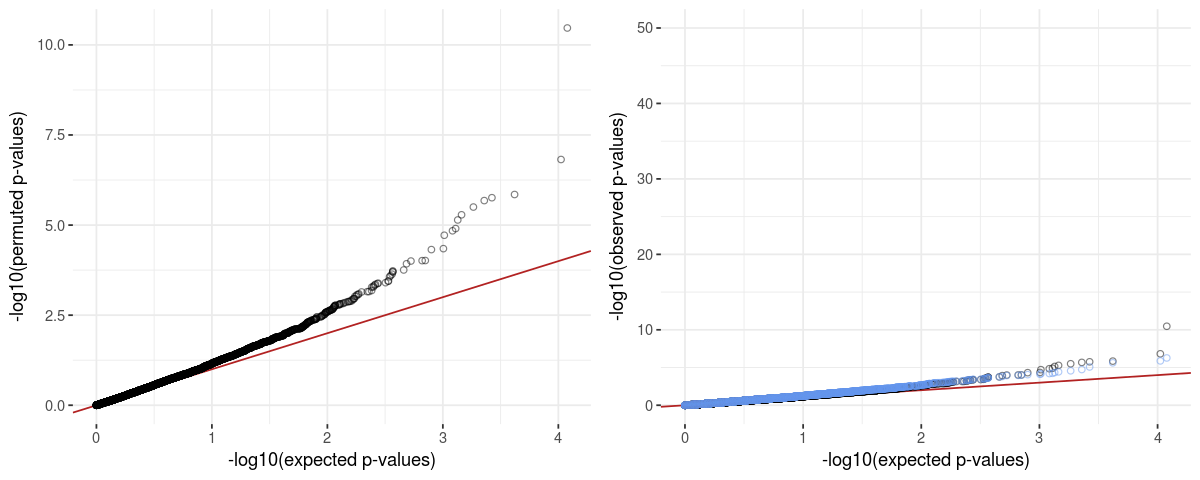

In [15]:
df = leads_int
df$pv_uniform = runif(dim(df)[1], min = 0, max = 1)
p1 = ggplot(df, aes(x = sort(-log10(pv_uniform)), y = sort(-log10(permutation_3)))) + 
        geom_abline(slope = 1, intercept = 0, col = "firebrick") +
        geom_point(alpha = 0.5, pch = 1) + xlab("-log10(expected p-values)") + ylab("-log10(permuted p-values)") +
        theme_bw() + 
        theme(legend.position="none", panel.border = element_blank())
p2 = ggplot(df) + 
        geom_abline(slope = 1, intercept = 0, col = "firebrick") +
        geom_point(alpha = 0.5, pch = 1, aes(x = sort(-log10(pv_uniform)), y = sort(-log10(permutation_3)))) +
        geom_point(color = "cornflowerblue", alpha = 0.5, pch = 1, 
                   aes(x = sort(-log10(pv_uniform)), y = sort(-log10(p_value)))) + 
        xlab("-log10(expected p-values)") + ylab("-log10(observed p-values)") + 
        theme_bw() + ylim(c(0,50)) +
        theme(legend.position="none", panel.border = element_blank())
options(repr.plot.width = 10, repr.plot.height = 4) 
plot_grid(p1, p2, ncol = 2)

In [14]:
library(cowplot)


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



In [11]:
folderint <- "/nfs/leia/research/stegle/acuomo/interactions/alldays/pseudotime_pc1_top500hvgs_10expanded_pcs_517donor_expt_day_leads_allstages/"
leadsint <- GetTopResults(folderint)

In [12]:
leadsint$q_value <- qvalue(leadsint$p_value)$qvalues
leadsint = leadsint[order(leadsint$q_value),]
dim(leadsint)
dim(leadsint[leadsint$q_value < 0.1,]) # 56%

[1] 3130   12

[1] 2032   12

In [29]:
dim(leadsint)

[1] 3130   12

In [27]:
write.csv(leadsint, "/nfs/leia/research/stegle/acuomo/interactions/alldays/pseudotime_pc1_top500hvgs_10expanded_pcs_517donor_expt_day_leads_allstages/leads.csv")

In [14]:
## iPSC (day0)
leads.ips = read.csv("/nfs/leia/research/stegle/acuomo/mean/day0/all_expts/leads.csv", row.names = 1)
leads.ips.sign = leads.ips[leads.ips$global_corr_p_value < 0.1,]
## mesendo
leads.mes = read.csv("/nfs/leia/research/stegle/acuomo/mean/mesendo_est_June20/leads.csv", row.names = 1)
leads.mes.sign = leads.mes[leads.mes$global_corr_p_value < 0.1,]
## defendo
leads.defendo = read.csv("/nfs/leia/research/stegle/acuomo/mean/defendo_est_June20/leads.csv", row.names = 1)
leads.defendo.sign = leads.defendo[leads.defendo$global_corr_p_value < 0.1,]

In [19]:
df1 = as.data.frame(cbind(leads.ips.sign[,c("snp_id","feature")],"ips"))
colnames(df1) = c("snp_id","feature","stage")
df2 = as.data.frame(cbind(leads.mes.sign[,c("snp_id","feature")],"mesendo"))
colnames(df2) = c("snp_id","feature","stage")
df3 = as.data.frame(cbind(leads.defendo.sign[,c("snp_id","feature")],"defendo"))
colnames(df3) = c("snp_id","feature","stage")
df = rbind(df1,df2,df3)
dim(df1)
dim(df2)
dim(df3)

[1] 1833    3

[1] 1702    3

[1] 1342    3

In [20]:
keep_leads = left_join(leadsint,df, by = c("snp_id","feature"))
dim(keep_leads)
head(keep_leads)

[1] 3460   13

beta         beta_se      empirical_feature_p_value p_value      
1 -0.014912210 0.0003972581 2.407100e-207             2.225074e-308
2 -0.014912210 0.0003972581 2.407100e-207             2.225074e-308
3 -0.014912210 0.0003972581 2.407100e-207             2.225074e-308
4  0.017999188 0.0004794945 9.305039e-188             2.225074e-308
5  0.009027511 0.0002988020  0.000000e+00             1.630308e-200
6  0.009027511 0.0002988020  0.000000e+00             1.630308e-200
  snp_id          feature                  global_corr_p_value chrom pos      
1 6_32634922_A_G  ENSG00000179344_HLA-DQB1 3.750683e-205       6      32634922
2 6_32634922_A_G  ENSG00000179344_HLA-DQB1 3.750683e-205       6      32634922
3 6_32634922_A_G  ENSG00000179344_HLA-DQB1 3.750683e-205       6      32634922
4 6_31132414_G_A  ENSG00000204531_POU5F1   1.242761e-185       6      31132414
5 9_136227260_A_G ENSG00000148291_SURF2     0.000000e+00       9     136227260
6 9_136227260_A_G ENSG00000148291_SURF2     0.000000e+00       9     136227260
  ref_allele alt_allele q_value       stage  
1 A          G          1.184094e-305 ips    
2 A          G          1.184094e-305 mesendo
3 A          G          1.184094e-305 defendo
4 G          A          1.184094e-305 ips    
5 A          G          5.783893e-198 ips    
6 A          G          5.783893e-198 mesendo

In [21]:
stages = c("ips","mesendo","defendo")

In [22]:
for (i in 1:length(stages)){
    res = keep_leads[keep_leads$stage == stages[i],]
    print(c(dim(res)[1], dim(res[res$q_value < 0.1,])[1],stages[i]))
}

[1] "1601" "1072" "ips" 
[1] "1021"    "559"     "mesendo"
[1] "838"     "618"     "defendo"


In [15]:
# ips 1,023 out of 1,597 (64%)
# mesendo 508 out of 991 (51%)
# defendo 598 out of 841 (71%)

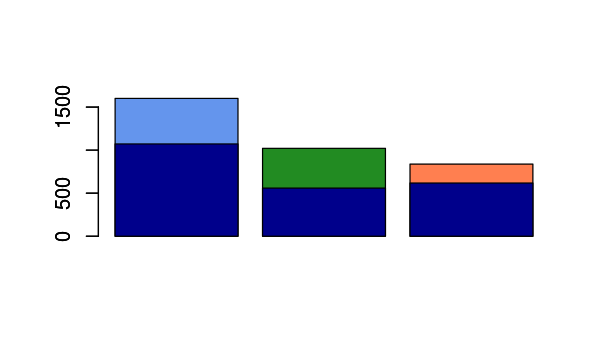

In [26]:
options(repr.plot.width = 5, repr.plot.height = 3)
barplot(c(1601,1021,838), col = c("cornflowerblue","forestgreen","coral"), axes = 3)
barplot(c(1072,559,618), col = c("darkblue","darkblue","darkblue"), add = T)

In [ ]:
# canva_palettes

In [42]:
folderint <- "/nfs/leia/research/stegle/acuomo/interactions/alldays/pseudotime_slalom_10expanded_pcs_435donor_expt_day_gwas/"
leadsint <- GetTopResults(folderint)

In [234]:
dim(leadsint[leadsint$global_corr_p_value < 0.1,])

[1] 8054   11

In [34]:
leadsint$q_value <- qvalue(leadsint$p_value)$qvalues
leadsint = leadsint[order(leadsint$q_value),]
dim(leadsint)
dim(leadsint[leadsint$q_value < 0.1,]) # 35%

[1] 119902     11

[1] 41536    11

In [43]:
permsint <- GetPerms(folderint)
leads_int <- left_join(leadsint, permsint, by = c("snp_id", "feature"))

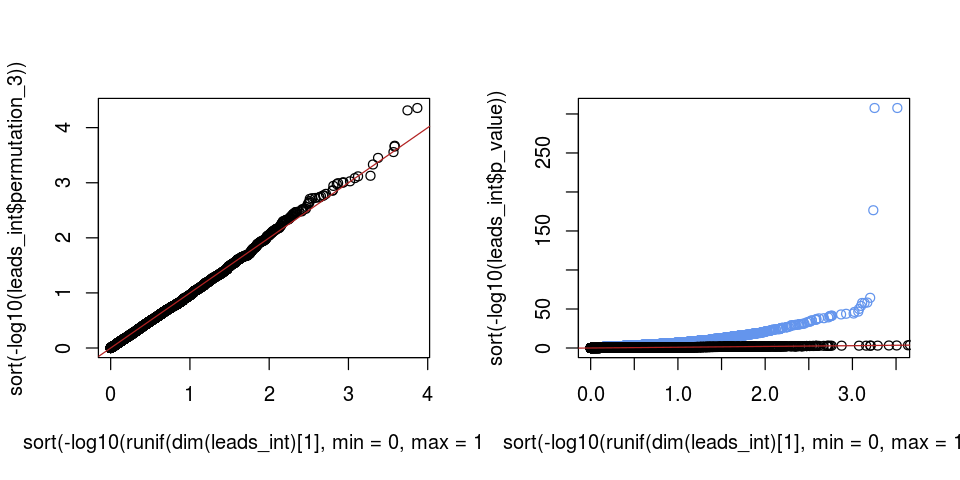

In [50]:
par(mfrow=c(1,2))
options(repr.plot.width = 8, repr.plot.height = 4)
# calibration
plot(sort(-log10(runif(dim(leads_int)[1], min = 0, max = 1))), sort(-log10(leads_int$permutation_3)))
abline(0,1, col = "firebrick")
# signal
plot(sort(-log10(runif(dim(leads_int)[1], min = 0, max = 1))), sort(-log10(leads_int$p_value)),
    col = "cornflowerblue")
points(sort(-log10(runif(dim(leads_int)[1], min = 0, max = 1))), sort(-log10(leads_int$permutation_0)))
abline(0,1, col = "firebrick")

Warning message:
“Removed 9 rows containing missing values (geom_point).”

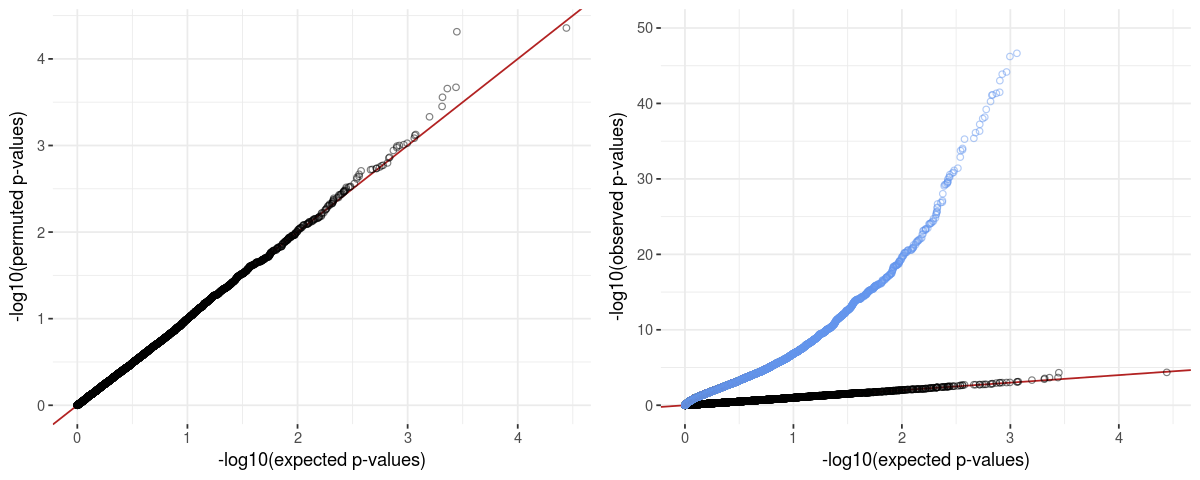

In [51]:
df = leads_int
df$pv_uniform = runif(dim(df)[1], min = 0, max = 1)
p1 = ggplot(df, aes(x = sort(-log10(pv_uniform)), y = sort(-log10(permutation_3)))) + 
        geom_abline(slope = 1, intercept = 0, col = "firebrick") +
        geom_point(alpha = 0.5, pch = 1) + xlab("-log10(expected p-values)") + ylab("-log10(permuted p-values)") +
        theme_bw() + 
        theme(legend.position="none", panel.border = element_blank())
p2 = ggplot(df) + 
        geom_abline(slope = 1, intercept = 0, col = "firebrick") +
        geom_point(alpha = 0.5, pch = 1, aes(x = sort(-log10(pv_uniform)), y = sort(-log10(permutation_3)))) +
        geom_point(color = "cornflowerblue", alpha = 0.5, pch = 1, 
                   aes(x = sort(-log10(pv_uniform)), y = sort(-log10(p_value)))) + 
        xlab("-log10(expected p-values)") + ylab("-log10(observed p-values)") + 
        theme_bw() + ylim(c(0,50)) +
        theme(legend.position="none", panel.border = element_blank())
options(repr.plot.width = 10, repr.plot.height = 4) 
plot_grid(p1, p2, ncol = 2)

In [40]:
library(cowplot)


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



In [15]:
write.csv(leads_int, "/nfs/leia/research/stegle/acuomo/interactions/alldays/results/leads_pseudotime_slalom_10expanded_pcs_435donor_expt_day_gwas.csv", row.names=FALSE)

In [83]:
head(leads_int)

beta       beta_se     empirical_feature_p_value p_value       snp_id        
1 -0.2620149 0.006980020 4.172853e-315             2.225074e-308 6_31107187_G_A
2 -0.2805493 0.007473774 4.172853e-315             2.225074e-308 6_31107258_T_C
3 -0.2714020 0.007230091 4.172853e-315             2.225074e-308 6_31116526_A_G
4 -0.3055406 0.008139536 4.172853e-315             2.225074e-308 6_31136453_A_G
5 -0.3027732 0.008065813 4.172853e-315             2.225074e-308 6_31136714_T_C
6 -0.3013244 0.008027219 4.172853e-315             2.225074e-308 6_31197514_C_G
  feature chrom pos      ref_allele alt_allele ⋯ permutation_0 permutation_1
1 POU5F1  6     31107187 G          A          ⋯ 0.07094050    0.9868944    
2 POU5F1  6     31107258 T          C          ⋯ 0.58530879    0.9134802    
3 POU5F1  6     31116526 A          G          ⋯ 0.38532565    0.9601130    
4 POU5F1  6     31136453 A          G          ⋯ 0.18839935    0.7736445    
5 POU5F1  6     31136714 T          C          ⋯ 0.19179210    0.6971673    
6 POU5F1  6     31197514 C          G          ⋯ 0.05388317    0.4370065    
  permutation_2 permutation_3 permutation_4 permutation_5 permutation_6
1 0.4532088     0.1549680     0.3522538     0.8720578     0.7357032    
2 0.3865067     0.3351652     0.1683205     0.3701194     0.7976081    
3 0.3282089     0.3277361     0.1581405     0.3377629     0.9746976    
4 0.5949806     0.4504014     0.1119789     0.7904821     0.8562602    
5 0.5979160     0.4623481     0.1141692     0.8132571     0.8692259    
6 0.9967865     0.2984509     0.2625232     0.6310779     0.8031193    
  permutation_7 permutation_8 permutation_9
1 0.4012277     0.5396598     0.6457690    
2 0.2658368     0.3022064     0.7619000    
3 0.3870667     0.2098478     0.8821739    
4 0.2262612     0.1208252     0.9369618    
5 0.2035658     0.1324980     0.9308545    
6 0.5506135     0.2293045     0.6749250

In [86]:
# Load the library
library(qqman)


For example usage please run: vignette('qqman')

Citation appreciated but not required:
Turner, S.D. qqman: an R package for visualizing GWAS results using Q-Q and manhattan plots. biorXiv DOI: 10.1101/005165 (2014).



In [87]:
gwasResults = leads_int[,c("chrom","pos","snp_id","p_value")]
gwasResults = as.data.frame(gwasResults)
colnames(gwasResults) = c("CHR", "BP", "SNP", "P")

In [93]:
# manhattan(gwasResults, chr = "CHR", bp = "BP", snp = "SNP", p = "P" )
don <- gwasResults %>% 
    # Compute chromosome size
  group_by(CHR) %>% 
  summarise(chr_len=max(BP)) %>% 
  # Calculate cumulative position of each chromosome
  dplyr::mutate(tot=cumsum(chr_len)-chr_len) %>%
  select(-chr_len) %>%
  # Add this info to the initial dataset
  left_join(gwasResults, ., by=c("CHR"="CHR")) %>%
  # Add a cumulative position of each SNP
  dplyr::arrange(CHR, BP) %>%
  dplyr::mutate( BPcum=BP+tot)

Warning message:
“Removed 143 rows containing missing values (geom_point).”

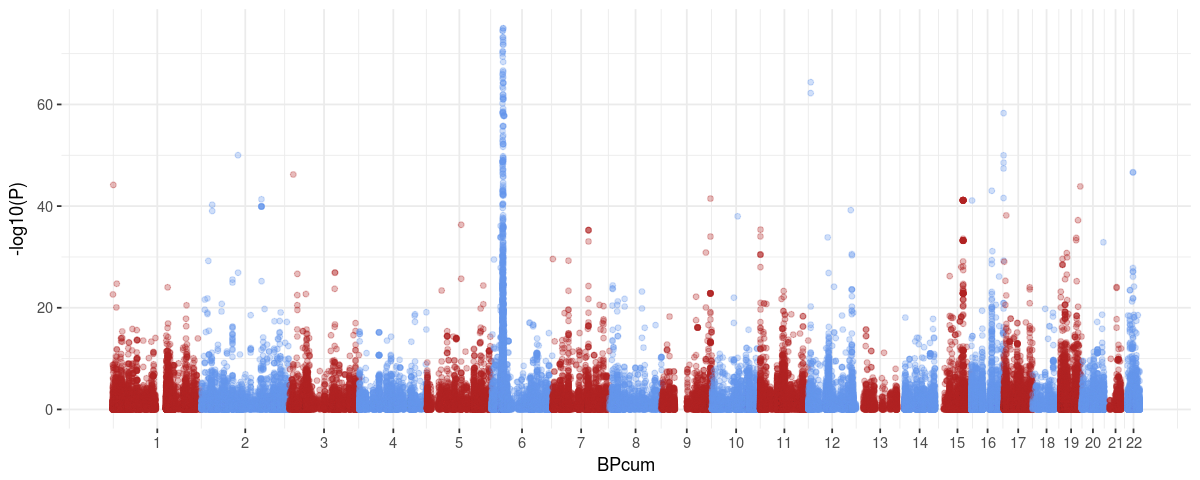

In [126]:
axisdf = don %>% group_by(CHR) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 )
options(repr.plot.width = 10, repr.plot.height = 4)
ggplot(don, aes(x = BPcum, y = -log10(P))) +
    ylim(c(0,75)) +
    geom_point(aes(color = as.factor(CHR)), alpha = 0.3, size = 1.3) +
    scale_color_manual(values = rep(c("firebrick", "cornflowerblue"), 22 )) +
    scale_x_continuous( label = axisdf$CHR, breaks= axisdf$center ) +
    theme_bw() +
    theme( 
      legend.position="none",
      panel.border = element_blank())

In [22]:
folderint <- "/nfs/leia/research/stegle/acuomo/interactions/day0/g2m_slalom_10expanded_pcs_donor_expt_no19_20_24_leads/"
leadsint <- GetResults(folderint)

In [23]:
head(leadsint)

NULL

In [34]:
folderint <- "/nfs/leia/research/stegle/acuomo/interactions/days01/pseudotime_slalom_10expanded_pcs_245donor_expt_days01_leads/"
leadsint <- GetResults(folderint)

In [35]:
leadsint$q_value <- qvalue(leadsint$p_value)$qvalues
leadsint = leadsint[order(leadsint$q_value),]
dim(leadsint)
dim(leadsint[leadsint$q_value < 0.1,]) # ~38%

[1] 7659   11

[1] 2899   11

In [36]:
permsint <- GetPerms(folderint)
leads_int <- left_join(leadsint, permsint, by = c("snp_id", "feature"))

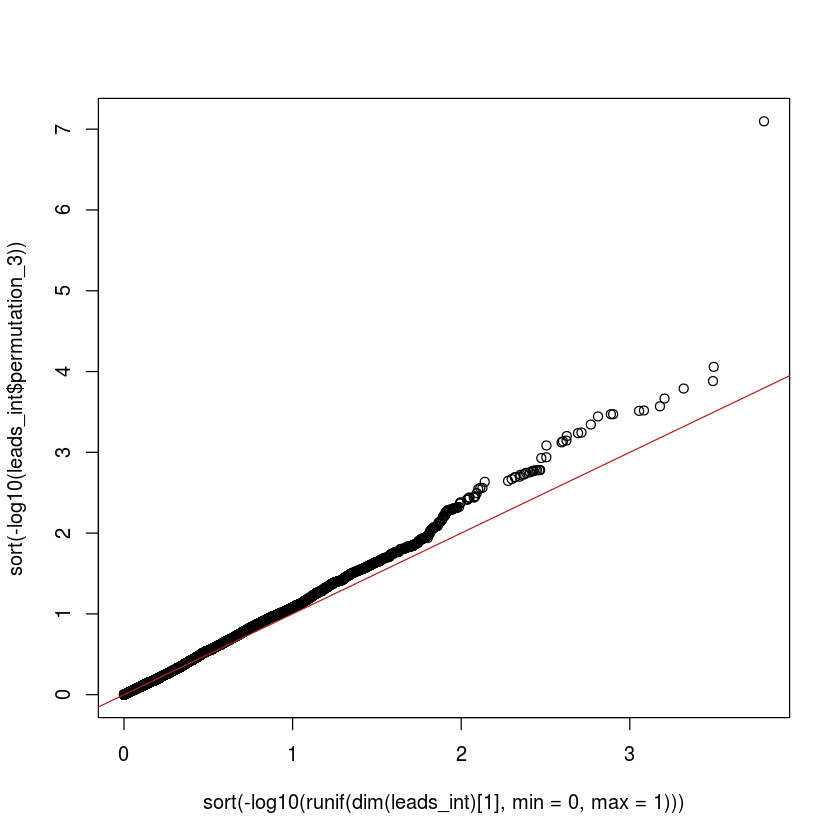

In [45]:
plot(sort(-log10(runif(dim(leads_int)[1], min = 0, max = 1))), sort(-log10(leads_int$permutation_3)))
abline(0,1, col = "firebrick")

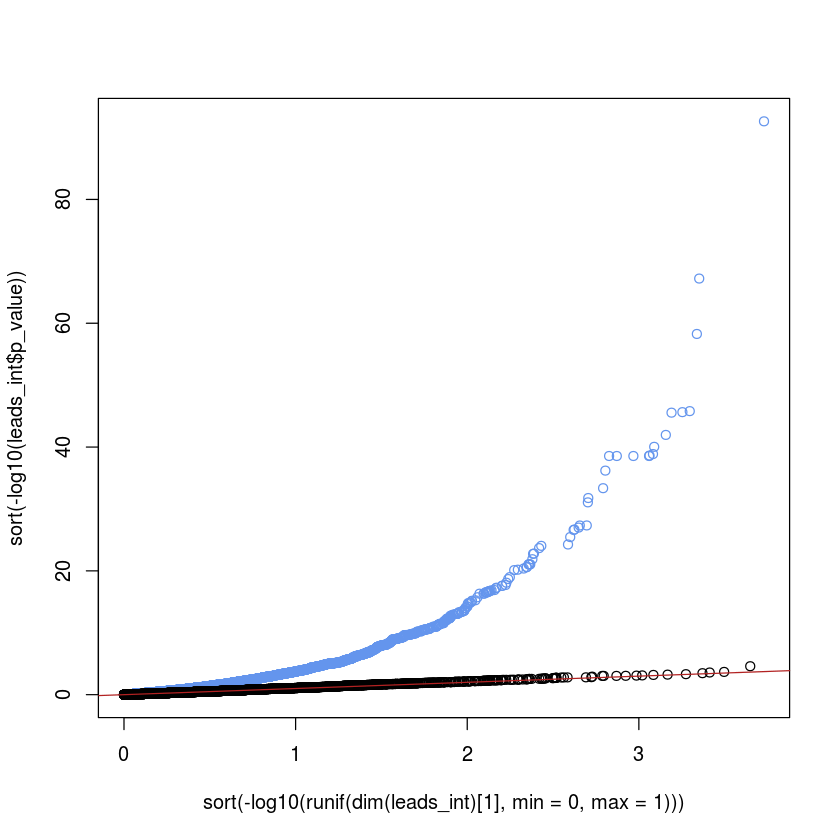

In [37]:
plot(sort(-log10(runif(dim(leads_int)[1], min = 0, max = 1))), sort(-log10(leads_int$p_value)),
    col = "cornflowerblue")
points(sort(-log10(runif(dim(leads_int)[1], min = 0, max = 1))), sort(-log10(leads_int$permutation_0)))
abline(0,1, col = "firebrick")

In [46]:
write.csv(leads_int, "/nfs/leia/research/stegle/acuomo/interactions/days01/results/leads_pseudotime_slalom_10expanded_pcs_245donor_expt_days01_leads.csv", row.names=FALSE)

In [48]:
head(leads_int[order(leads_int$permutation_1),])

beta        beta_se    empirical_feature_p_value p_value     
3857 -0.04752568 0.03339605 6.335112e-01              1.547093e-01
2369 -0.06406685 0.02885359 6.087783e-01              2.639084e-02
71    0.21274946 0.02725146 2.008522e-02              5.861095e-15
1635 -0.12540805 0.04522551 2.131431e-01              5.555074e-03
171   0.18249776 0.02880268 9.954065e-05              2.355961e-10
173   0.18249776 0.02880268 3.802740e-03              2.355961e-10
     snp_id          feature  chrom pos       ref_allele alt_allele ⋯
3857 17_7092704_G_A  GABARAP  17      7092704 G          A          ⋯
2369 5_142403090_G_T ARHGAP26  5    142403090 G          T          ⋯
71   12_53353508_C_A KRT8     12     53353508 C          A          ⋯
1635 1_161008535_C_G TSTD1     1    161008535 C          G          ⋯
171  3_8571110_G_A   LMCD1     3      8571110 G          A          ⋯
173  3_8571110_G_A   LMCD1     3      8571110 G          A          ⋯
     permutation_0 permutation_1 permutation_2 permutation_3 permutation_4
3857 0.0279515280  3.622321e-06  2.591284e-01  0.0801121736  0.007573781  
2369 0.3068128189  1.421315e-05  1.901166e-02  0.0016641555  0.120894945  
71   0.0006456973  2.753299e-05  3.940443e-08  0.0003068663  0.382229179  
1635 0.2770413303  4.701837e-05  7.260948e-04  0.3430756498  0.982882187  
171  0.0942826836  5.611028e-05  8.307658e-01  0.6035857903  0.001030239  
173  0.0942826836  5.611028e-05  8.307658e-01  0.6035857903  0.001030239  
     permutation_5 permutation_6 permutation_7 permutation_8 permutation_9
3857 0.177325946   4.064069e-01  2.586754e-01  0.49100755    1.337502e-01 
2369 0.001626691   2.978028e-02  1.252295e-05  0.03529051    9.470873e-03 
71   0.698496202   1.248576e-08  4.182379e-01  0.98906180    5.717542e-05 
1635 0.756290626   1.918735e-01  6.061599e-01  0.03689093    9.423503e-04 
171  0.187504543   4.472152e-03  1.280511e-03  0.74897594    1.377072e-02 
173  0.187504543   4.472152e-03  1.280511e-03  0.74897594    1.377072e-02

In [62]:
leadsint <- GetResults(folderint)
head(leadsint)

beta       beta_se    empirical_feature_p_value p_value     
6295  0.2618117 0.03178424 2.459414e-124             1.763519e-16
6975 -0.1057458 0.07275068  3.116408e-98             1.460747e-01
6294  0.2441693 0.02555765  2.574582e-55             1.251847e-21
2791  0.1532268 0.07141860  8.321388e-44             3.191495e-02
3586 -0.4725600 0.04383754  8.395071e-41             4.288077e-27
4445 -0.1176375 0.06622885  8.124519e-40             7.569554e-02
     snp_id          feature chrom pos       ref_allele alt_allele
6295 6_31237124_T_C  HLA-C    6     31237124 T          C         
6975 8_49838908_T_G  SNAI2    8     49838908 T          G         
6294 6_31132414_G_A  POU5F1   6     31132414 G          A         
2791 16_54351735_C_T IRX3    16     54351735 C          T         
3586 19_13054781_G_T CALR    19     13054781 G          T         
4445 2_241469519_C_G ANKMY1   2    241469519 C          G

In [58]:
folderint <- "/nfs/leia/research/stegle/acuomo/interactions/day0/notG1_cyclone_10expanded_pcs_126donor_expt_day0_leads/"
# leadsint <- GetTopResults(folderint)

In [63]:
leadsint$q_value <- qvalue(leadsint$p_value)$qvalues
leadsint = leadsint[order(leadsint$q_value),]
# permsint <- GetPerms(folderint)
# leads_int <- left_join(leadsint, permsint, by = c("snp_id", "feature"))
# head(leads_int)

In [66]:
length(unique(leadsint$snp_id))

[1] 7050

In [64]:
dim(leadsint)
dim(leadsint[leadsint$q_value < 0.1,])

[1] 7296   11

[1] 707  11

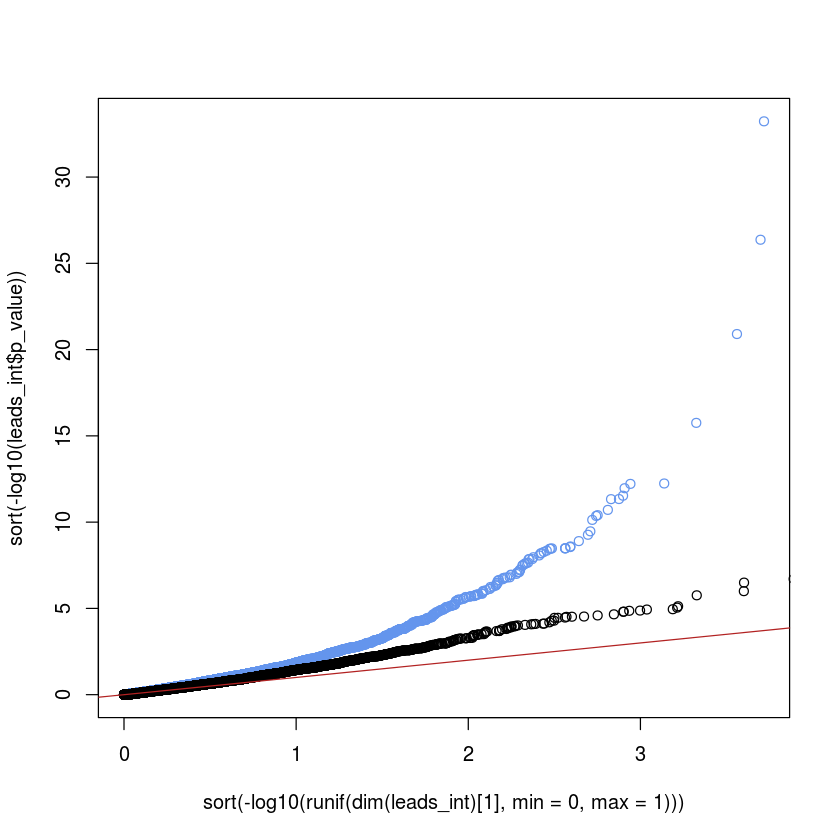

In [40]:
plot(sort(-log10(runif(dim(leads_int)[1], min = 0, max = 1))), sort(-log10(leads_int$p_value)),
    col = "cornflowerblue")
points(sort(-log10(runif(dim(leads_int)[1], min = 0, max = 1))), sort(-log10(leads_int$permutation_9)))
abline(0,1, col = "firebrick")

In [45]:
fvf_genenames <- read.table("/hps/nobackup/stegle/users/acuomo/singlecell_endodiff/interaction_eqtls/day0/feature_variant_filter_iPSC_leads_MAF05_in_notG1_group_genes_insce.tsv", header = T, sep = "\t")

In [53]:
dim(fvf_genenames)
# head(fvf_genenames)

[1] 8949    2

In [54]:
dim(leads_int)
# head(leads_int)

[1] 7297   22

In [55]:
# sum(leads_int$snp_id %in% fvf_genenames$snp_id)
# sum(fvf_genenames$snp_id %in% leads_int$snp_id)
# sum(leads_int$feature %in% fvf_genenames$feature)
# sum(fvf_genenames$feature %in% leads_int$feature)

In [98]:
write.csv(leads_int, "/nfs/leia/research/stegle/acuomo/interactions/day0/results/leads_notG1_cyclone_10expanded_pcs_126donor_expt_day0_leads.csv", row.names=FALSE)

In [42]:
write.csv(leads_int, "/nfs/leia/research/stegle/acuomo/interactions/day0/results/leads_notG1_cyclone_10expanded_pcs_126donor_expt_day0_all_leads.csv", row.names=FALSE)

In [100]:
#b = read.csv("/nfs/leia/research/stegle/acuomo/interactions/day0/results/leads_notG1_cyclone_10expanded_pcs_126donor_expt_day0_leads.csv")
dim(b)

[1] 4564   22

In [111]:
genos = read.table("/hps/nobackup/hipsci/scratch/genotypes/imputed/2017-03-27/selectionAnna_April21.dosages.txt", header = T, row.names = 1)

Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
“number of items read is not a multiple of the number of columns”

In [112]:
dim(genos)
head(genos)

[1] 146  96

HPSI0913i.eika_2 HPSI1014i.quls_2 HPSI0414i.oaqd_3
13_36875496_T_G 0.000            0.000            1.000           
13_52714837_C_A 1.000            0.000            1.000           
13_75882930_G_A 1.996            1.001            0.002           
13_76088638_G_A 2.000            2.000            0.997           
13_96295824_T_C 2.000            1.000            1.000           
13_98087096_T_C 0.140            0.002            0.000           
                HPSI0514i.puie_5 HPSI0214i.feec_2 HPSI0414i.naju_1
13_36875496_T_G 0                1.000            0.000           
13_52714837_C_A 1                2.000            2.000           
13_75882930_G_A 1                0.003            1.000           
13_76088638_G_A 1                2.000            1.000           
13_96295824_T_C 1                2.000            2.000           
13_98087096_T_C 1                0.000            0.982           
                HPSI0914i.kajh_3 HPSI0614i.paab_4 HPSI0114i.iisa_3
13_36875496_T_G 1.000            2.000            1               
13_52714837_C_A 1.000            1.000            0               
13_75882930_G_A 1.008            0.005            2               
13_76088638_G_A 2.000            2.000            2               
13_96295824_T_C 2.000            2.000            2               
13_98087096_T_C 0.997            0.000            0               
                HPSI0214i.wibj_2 ⋯ HPSI0414i.walu_1 HPSI0614i.guyj_2
13_36875496_T_G 2.000            ⋯ 0                0               
13_52714837_C_A 1.000            ⋯ 1                2               
13_75882930_G_A 0.999            ⋯ 1                2               
13_76088638_G_A 2.000            ⋯ 2                2               
13_96295824_T_C 2.000            ⋯ 2                2               
13_98087096_T_C 0.999            ⋯ 0                0               
                HPSI0514i.pulk_1 HPSI0614i.dixh_2 HPSI0714i.fasu_2
13_36875496_T_G 0.000            0.000            1.000           
13_52714837_C_A 1.000            2.000            2.000           
13_75882930_G_A 1.997            1.997            1.998           
13_76088638_G_A 2.000            2.000            1.000           
13_96295824_T_C 1.000            1.000            2.000           
13_98087096_T_C 1.997            0.000            0.000           
                HPSI0414i.eevy_7 HPSI0414i.fuai_1 HPSI0714i.oojs_1
13_36875496_T_G 0.000            0.000            0               
13_52714837_C_A 1.000            2.000            1               
13_75882930_G_A 1.945            0.999            2               
13_76088638_G_A 2.000            1.798            2               
13_96295824_T_C 2.000            1.570            2               
13_98087096_T_C 0.954            0.994            1               
                HPSI0614i.koqx_1 HPSI0414i.tout_1
13_36875496_T_G 1                1               
13_52714837_C_A 2                0               
13_75882930_G_A 2                2               
13_76088638_G_A 2                2               
13_96295824_T_C 2                2               
13_98087096_T_C 0                0

In [117]:
folderint <- "/nfs/leia/research/stegle/acuomo/interactions/day3/notG1_cyclone_10expanded_pcs_103donor_expt_day3_leads/"
leadsint <- GetTopResults(folderint)

In [118]:
leadsint$q_value <- qvalue(leadsint$p_value)$qvalues
leadsint = leadsint[order(leadsint$q_value),]
permsint <- GetPerms(folderint)
leads_int <- left_join(leadsint, permsint, by = c("snp_id", "feature"))
head(leads_int)

beta       beta_se    empirical_feature_p_value p_value      snp_id         
1 -0.4096773 0.08393630 1.978299e-06              1.056498e-06 12_6864411_A_G 
2  0.5572122 0.12298320 4.738169e-04              5.876097e-06 3_49991585_T_A 
3  0.3433150 0.07857972 4.054038e-27              1.248152e-05 1_201110963_C_T
4  0.2574000 0.05902428 3.642156e-09              1.295180e-05 20_43533286_T_G
5 -0.4394081 0.10382271 1.714601e-13              2.313214e-05 5_159846074_A_G
6  0.1677076 0.04012231 1.461910e-30              2.916250e-05 6_31237124_T_C 
  feature global_corr_p_value chrom pos       ref_allele ⋯ permutation_0
1 MLF2    1.856654e-04        12      6864411 A          ⋯ 0.9104589    
2 CAMKV   1.259040e-02         3     49991585 T          ⋯ 0.1481095    
3 TMEM9   5.960788e-24         1    201110963 C          ⋯ 0.7730215    
4 YWHAB   8.032774e-07        20     43533286 T          ⋯ 0.2916284    
5 PTTG1   7.563106e-11         5    159846074 A          ⋯ 0.7860719    
6 HLA-C   3.224243e-27         6     31237124 T          ⋯ 0.6348715    
  permutation_1 permutation_2 permutation_3 permutation_4 permutation_5
1 0.1235798     0.07936142    0.7371775     0.08175844    0.5686984    
2 0.9503554     1.00000000    0.7321085     0.32669892    0.6830575    
3 0.7356583     0.97554478    0.7997668     0.79565584    0.7447063    
4 0.9348665     0.84892306    0.6253492     0.46074597    0.5601658    
5 0.9500855     0.69194943    0.2393337     0.91862731    0.9843877    
6 0.6186777     0.60058070    0.8853196     0.50055545    0.8531383    
  permutation_6 permutation_7 permutation_8 permutation_9
1 0.3644996     0.2349984     0.1578620     0.5638880    
2 1.0000000     0.9248482     0.5780755     0.9485554    
3 0.5227261     0.6176834     0.4938569     0.7559760    
4 0.3084492     0.2278711     0.2344688     0.4104439    
5 0.6787820     0.6801209     0.6504931     0.7437287    
6 0.8766061     0.8067688     0.8021078     0.9320933

In [119]:
dim(leadsint)
dim(leadsint[leadsint$q_value < 0.1,])

[1] 4411   12

[1] 15 12

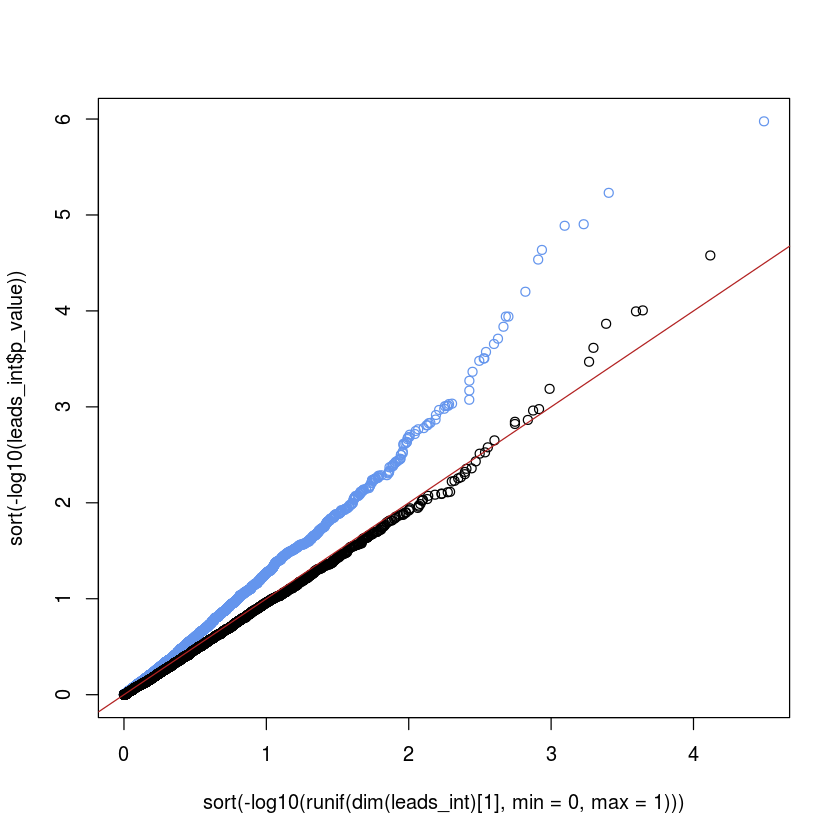

In [120]:
plot(sort(-log10(runif(dim(leads_int)[1], min = 0, max = 1))), sort(-log10(leads_int$p_value)),
    col = "cornflowerblue")
points(sort(-log10(runif(dim(leads_int)[1], min = 0, max = 1))), sort(-log10(leads_int$permutation_9)))
abline(0,1, col = "firebrick")

In [121]:
write.csv(leads_int, "/nfs/leia/research/stegle/acuomo/interactions/day3/results/leads_notG1_cyclone_10expanded_pcs_103donor_expt_day3_leads.csv", row.names=FALSE)

In [23]:
#folderm0 <- "/nfs/leia/research/stegle/acuomo/donor_expt_day/day0/126donor_expt_mean_10pcs/"
folderm0 <- "/nfs/leia/research/stegle/acuomo/donor_expt/108donor_expt_noexpt19expt20expt24_mean_10pcs"
#resm0 <- GetResults(folderm0)
leadsm0 <- GetTopResults(folderm0)

In [24]:
dim(leadsm0[leadsm0$global_corr_p_value < 0.1,])

[1] 1279   11

In [9]:
folderm1 <- "/nfs/leia/research/stegle/acuomo/donor_expt_day/day1/119donor_expt_mean_10pcs/"
#resm1 <- GetResults(folderm1)
leadsm1 <- GetTopResults(folderm1)

In [12]:
leadsm1[leadsm1$global_corr_p_value < 0.1,]

beta     beta_se  empirical_feature_p_value p_value      snp_id         
484993 1.045923 0.225039 5.222933e-06              3.355931e-06 10_53976957_C_T
       feature global_corr_p_value chrom pos      ref_allele alt_allele
484993 DDX3Y   0.05802678          10    53976957 C          T

In [11]:
folderm2 <- "/nfs/leia/research/stegle/acuomo/donor_expt_day/day2/87donor_expt_mean_10pcs/"
#resm2 <- GetResults(folderm2)
leadsm2 <- GetTopResults(folderm2)

In [13]:
dim(leadsm2[leadsm2$global_corr_p_value < 0.1,])

[1]  0 11

In [14]:
folderm3 <- "/nfs/leia/research/stegle/acuomo/donor_expt_day/day3/103donor_expt_mean_10pcs/"
#resm3 <- GetResults(folderm3)
leadsm3 <- GetTopResults(folderm3)

In [17]:
head(leadsm3[order(leadsm3$global_corr_p_value),])

beta      beta_se   empirical_feature_p_value p_value     
3196531 1.5879947 0.2570977 1.206470e-05              6.548911e-10
5360838 0.6958688 0.1393253 5.459163e-05              5.896907e-07
1070123 0.7737021 0.1421096 1.083378e-04              5.197954e-08
1165354 1.1545312 0.2150029 1.787560e-04              7.880695e-08
1941540 0.9850269 0.2084895 1.973262e-04              2.305825e-06
1649128 1.3582417 0.2655530 2.563508e-04              3.141290e-07
        snp_id           feature global_corr_p_value chrom pos       ref_allele
3196531 2_99923604_C_G   ZNF454  0.1343405            2     99923604 C         
5360838 9_15355480_T_G   PUS10   0.3039389            9     15355480 T         
1070123 12_93410629_G_T  CHPF    0.4021139           12     93410629 G         
1165354 12_102228549_A_G KLHL26  0.4394454           12    102228549 A         
1941540 16_1976625_A_T   RNASET2 0.4394454           16      1976625 A         
1649128 15_59264999_C_T  LOXL3   0.4681676           15     59264999 C         
        alt_allele
3196531 G         
5360838 G         
1070123 T         
1165354 G         
1941540 T         
1649128 T

In [10]:
folder_int_pn_bulkleads <- "/nfs/leia/research/stegle/acuomo/interactions/marcs/bulk_leads_126samples_day0_10pcscells_interactions_pn/w_perms/"

In [8]:
res_ip <- GetResults(folder_int_pn_bulkleads)

In [11]:
leads_ip <- GetTopResults(folder_int_pn_bulkleads)

Warning message in min(p):
“no non-missing arguments to min; returning Inf”Warning message in max(p):
“no non-missing arguments to max; returning -Inf”Warning message in min(p):
“no non-missing arguments to min; returning Inf”Warning message in max(p):
“no non-missing arguments to max; returning -Inf”

ERROR: Error in smooth.spline(lambda, pi0, df = smooth.df): missing or infinite values in inputs are not allowed


In [25]:
head(res_ip)

beta         beta_se     empirical_feature_p_value p_value    
1524  0.008143724 0.003648533 2.806562e-05              0.025611371
1026  0.006583740 0.003283698 1.291143e-04              0.044965511
739  -0.004182580 0.002734844 1.379249e-04              0.126173601
265  -0.007157451 0.002753835 2.641109e-04              0.009347263
7     0.013232325 0.005616882 4.828800e-04              0.018482207
1395  0.007971891 0.003443824 1.194496e-03              0.020621852
     snp_id          feature                  chrom pos       ref_allele
1524 8_132920372_A_G ENSG00000132294_EFR3A     8    132920372 A         
1026 2_230749158_G_A ENSG00000153832_FBXO36    2    230749158 G         
739  17_8431453_T_C  ENSG00000133026_MYH10    17      8431453 T         
265  12_49519185_A_G ENSG00000123416_TUBA1B   12     49519185 A         
7    1_119600175_G_A ENSG00000116874_WARS2     1    119600175 G         
1395 6_2926298_A_T   ENSG00000124570_SERPINB6  6      2926298 A         
     alt_allele
1524 G         
1026 A         
739  C         
265  G         
7    A         
1395 T

In [ ]:
head(leads_ip)

In [26]:
res_ip$global_pv <- res_ip$empirical_feature_p_value*dim(res_ip)[1]
res_ip$global_pv[res_ip$global_pv > 1] <- 1

In [27]:
dim(res_ip[res_ip$global_pv < 0.1,])

[1]  1 11

In [29]:
folder_int_pn_bulkleads <- "/nfs/leia/research/stegle/acuomo/interactions/marcs/bulk_leads_126samples_day0_10pcscells_interactions_pn/"
res_ip <- GetResults(folder_int_pn_bulkleads)

In [36]:
res_ip$global_pv <- qvalue(res_ip$p_value)$qvalues
res_ip$global_pv[res_ip$global_pv > 1] <- 1

In [16]:
res_ip$global_pv <- res_ip$empirical_feature_p_value*dim(res_ip)[1]
res_ip$global_pv[res_ip$global_pv > 1] <- 1

In [37]:
head(res_ip)

beta         beta_se     empirical_feature_p_value p_value    
2544  0.010713689 0.003592472 1.988566e-31              0.002861281
125   0.001837040 0.002286021 3.894820e-22              0.421629679
2177  0.010449801 0.003538952 3.772844e-17              0.003149104
2444 -0.003251052 0.002962507 1.304707e-14              0.272467077
1848 -0.008581294 0.003687872 1.433715e-12              0.019970821
2827  0.006713267 0.002886121 1.913951e-12              0.020015772
     snp_id          feature                 chrom pos      ref_allele
2544 2_70119469_T_C  ENSG00000087338_GMCL1    2    70119469 T         
125  1_46014313_T_C  ENSG00000117448_AKR1A1   1    46014313 T         
2177 19_39939665_G_A ENSG00000090924_PLEKHG2 19    39939665 G         
2444 19_21936885_A_G ENSG00000197020_ZNF100  19    21936885 A         
1848 17_5318168_T_C  ENSG00000108559_NUP88   17     5318168 T         
2827 20_25277244_A_G ENSG00000100997_ABHD12  20    25277244 A         
     alt_allele global_pv
2544 C          0.7281304
125  C          0.9507754
2177 A          0.7281304
2444 G          0.9444691
1848 C          0.9064161
2827 G          0.9064161

In [38]:
res_ip[res_ip$global_pv < 0.1,]

beta beta_se empirical_feature_p_value p_value snp_id feature chrom pos
     ref_allele alt_allele global_pv

In [9]:
folder_bulk_resampled <- "/nfs/leia/research/stegle/acuomo/62samples_day0_hvgs_resampled_20pcs_bulk_logcpm/"
# resrs <- GetResults(folder_bulk_resampled)
# permsrs <- GetPerms(folder_bulk_resampled)
# leadsrs <- GetTopResults(folder_bulk_resampled)
results_rs <- inner_join(permsrs, resrs, by = c("feature","snp_id"))
leads_rs <- inner_join(permsrs, leadsrs, by = c("feature","snp_id"))

In [12]:
dim(leads_rs)

[1] 4500   22

In [10]:
dim(leads_rs[leads_rs$global_corr_p_value < 0.1,])

[1] 653  22

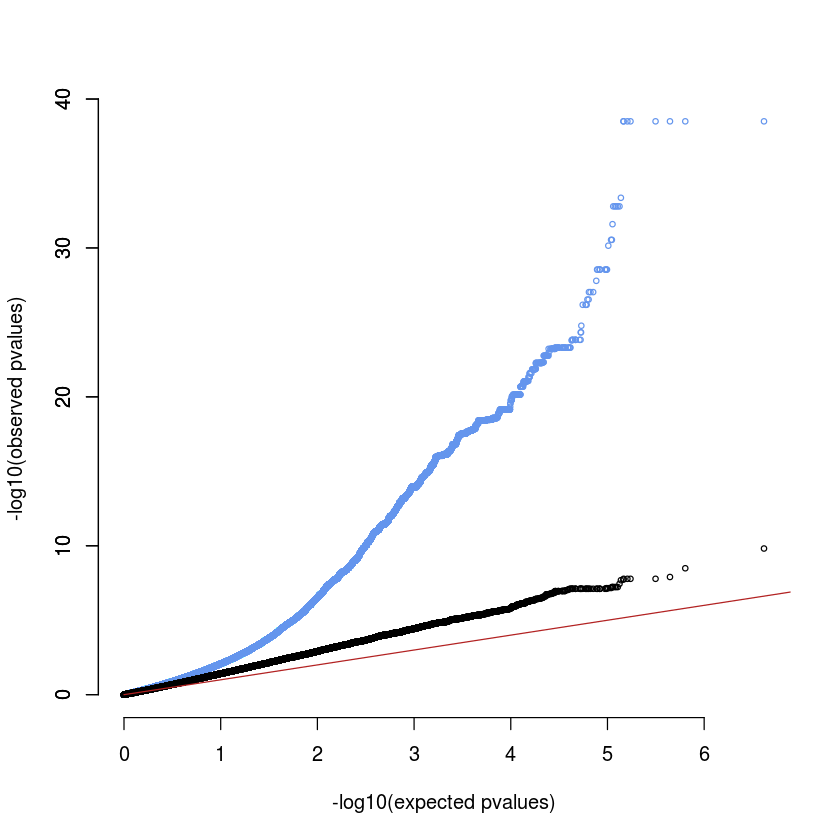

In [11]:
PlotQQ(results_rs)

In [13]:
folder_bulkNB <- "/nfs/leia/research/stegle/acuomo/62samples_day0_hvgs_resampled_NB_20pcs_bulk_logcpm/"
resbnb <- GetResults(folder_bulkNB)
permsbnb <- GetPerms(folder_bulkNB)
leadsbnb <- GetTopResults(folder_bulkNB)
results_bnb <- inner_join(permsbnb, resbnb, by = c("feature","snp_id"))
leads_bnb <- inner_join(permsbnb, leadsbnb, by = c("feature","snp_id"))

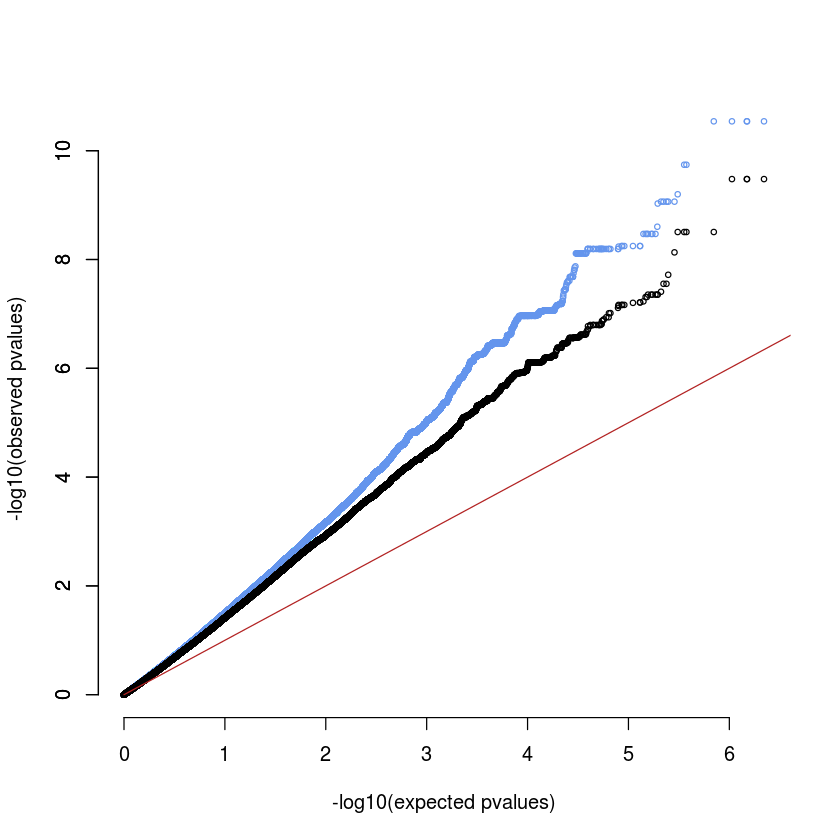

In [14]:
PlotQQ(results_bnb)

In [80]:
head(leads_bnb[order(leads_bnb$p_value),])

permutation_0 snp_id          feature                 beta      
2517 0.30123053    19_8387207_G_A  ENSG00000233927_RPS28   -0.9785499
2830 0.70664811    2_61395721_C_T  ENSG00000237651_C2orf74  0.6319739
3941 0.50601284    6_31128552_A_C  ENSG00000204531_POU5F1  -0.9678729
2560 0.14794233    2_101558904_T_C ENSG00000071082_RPL31   -0.4850438
2679 0.18830688    2_127893981_G_A ENSG00000136717_BIN1    -0.7638818
3668 0.01016629    5_56271185_G_A  ENSG00000155542_SETD9    0.7519304
     beta_se    empirical_feature_p_value n_samples p_value     
2517 0.14709689 0.0001595964              62        2.883180e-11
2830 0.09911011 0.0002199225              62        1.812008e-10
3941 0.15782228 0.0045037008              62        8.641305e-10
2560 0.07925660 0.0011365679              62        9.362433e-10
2679 0.13119241 0.0025570338              62        5.793667e-09
3668 0.13021442 0.0019486085              62        7.715650e-09
     global_corr_p_value chrom pos       ref_allele alt_allele
2517 0.4691183           19      8387207 G          A         
2830 0.4691183            2     61395721 C          T         
3941 0.8007491            6     31128552 A          C         
2560 0.8007491            2    101558904 T          C         
2679 0.8007491            2    127893981 G          A         
3668 0.8007491            5     56271185 G          A

In [15]:
dim(leads_bnb[leads_bnb$global_corr_p_value < 0.1,])

[1]  0 13

In [65]:
folder_dxe2_qng <- "/nfs/leia/research/stegle/acuomo/donor_expt/qn_genes/80donor_expt_mean_2pcs/"
resdxe2_qng <- GetResults(folder_dxe2_qng)
permsdxe2_qng <- GetPerms(folder_dxe2_qng)
leadsdxe2_qng <- GetTopResults(folder_dxe2_qng)
results_dxe2_qng <- inner_join(permsdxe2_qng, resdxe2_qng, by = c("feature","snp_id"))
leads_dxe2_qng <- inner_join(permsdxe2_qng, leadsdxe2_qng, by = c("feature","snp_id"))

In [66]:
write.csv(results_dxe2_qng,"/nfs/leia/research/stegle/acuomo/donor_expt/qn_genes/allresults_donor_expt_80_mean_2pcs.csv")
write.csv(leads_dxe2_qng,"/nfs/leia/research/stegle/acuomo/donor_expt/qn_genes/leads_donor_expt_80_mean_2pcs.csv")

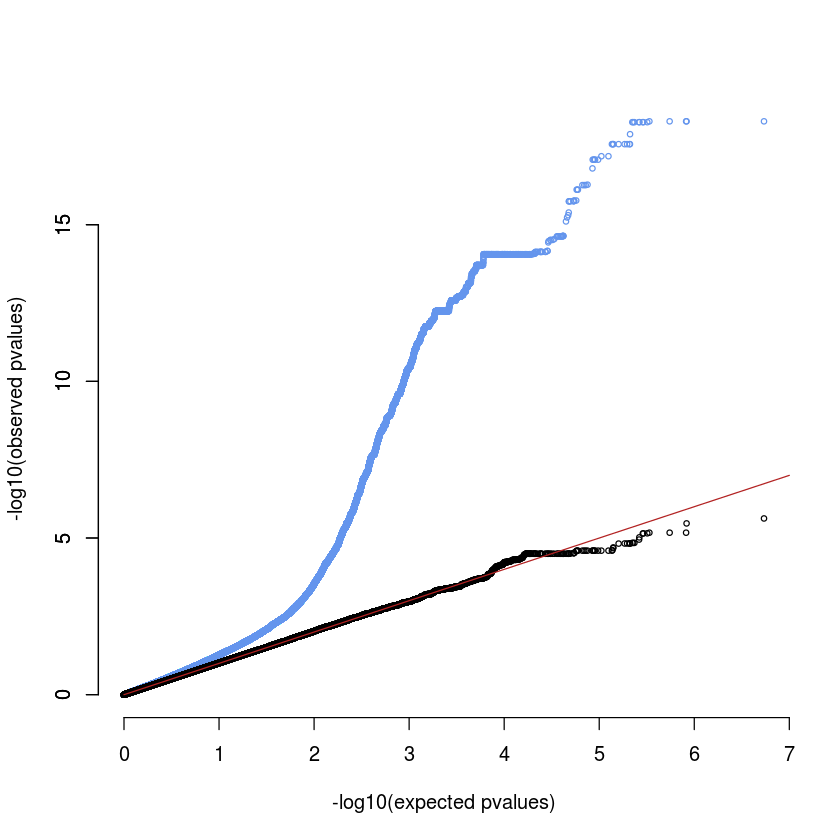

In [11]:
PlotQQ(results_dxe2_qng)

In [9]:
dim(leads_dxe2_qng[leads_dxe2_qng$global_corr_p_value < 0.1,])

[1] 199  21

In [59]:
folder_dxe2v <- "/nfs/leia/research/stegle/acuomo/donor_expt/80donor_expt_var_mean_2pcs/"
resdxe2v <- GetResults(folder_dxe2v)
permsdxe2v <- GetPerms(folder_dxe2v)
leadsdxe2v <- GetTopResults(folder_dxe2v)
results_dxe2v <- inner_join(permsdxe2v, resdxe2v, by = c("feature","snp_id"))
leads_dxe2v <- inner_join(permsdxe2v, leadsdxe2v, by = c("feature","snp_id"))

In [60]:
PlotQQ(results_dxe2v)

ERROR: Error in PlotQQ(results_dxe2v): could not find function "PlotQQ"


In [61]:
write.csv(results_dxe2v,"/nfs/leia/research/stegle/acuomo/donor_expt/allresults_donor_expt_80_var_mean_2pcs.csv")
write.csv(leads_dxe2v,"/nfs/leia/research/stegle/acuomo/donor_expt/leads_donor_expt_80_var_mean_2pcs.csv")

In [49]:
top <- leads_dxe2v[leads_dxe2v$global_corr_p_value < 0.1,]

In [55]:
PlotManhattan <- function(snp_id, feature){
    res.mean <- results_dxe10_qng[results_dxe10_qng$feature == feature,]
    res.var <- results_dxe2v[results_dxe2v$feature == feature,]
    m <- min(min(res.mean$p_value),min(res.var$p_value))
    plot(res.var$pos, -log10(res.var$p_value), col = "cornflowerblue", main = paste0(feature, ", ", snp_id),
        ylim = c(0, -log10(m)))
    points(res.mean$pos, -log10(res.mean$p_value), col = "forestgreen")
    points(res.var$pos, -log10(res.var$permutation_0), col = "black")
    abline(v = res.var[res.var$snp_id == snp_id,]$pos, col="cornflowerblue")
}

In [ ]:
dim(top)[1]

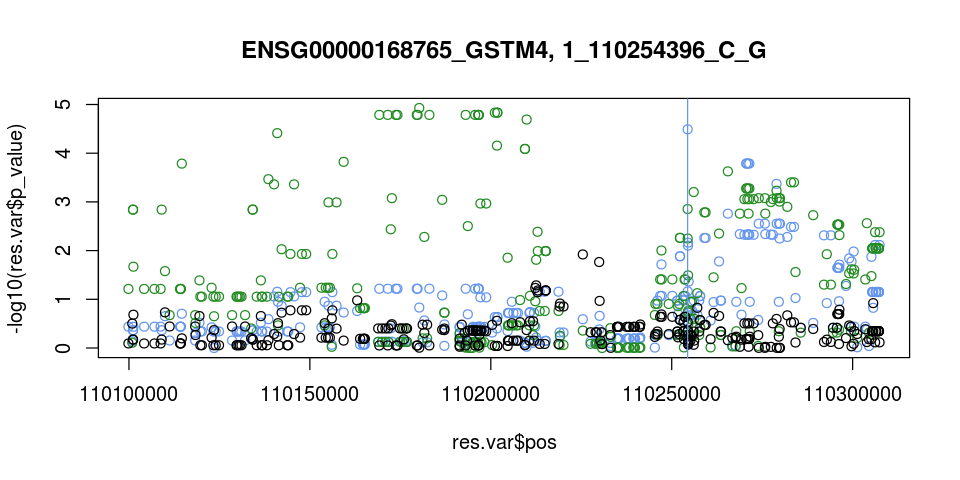

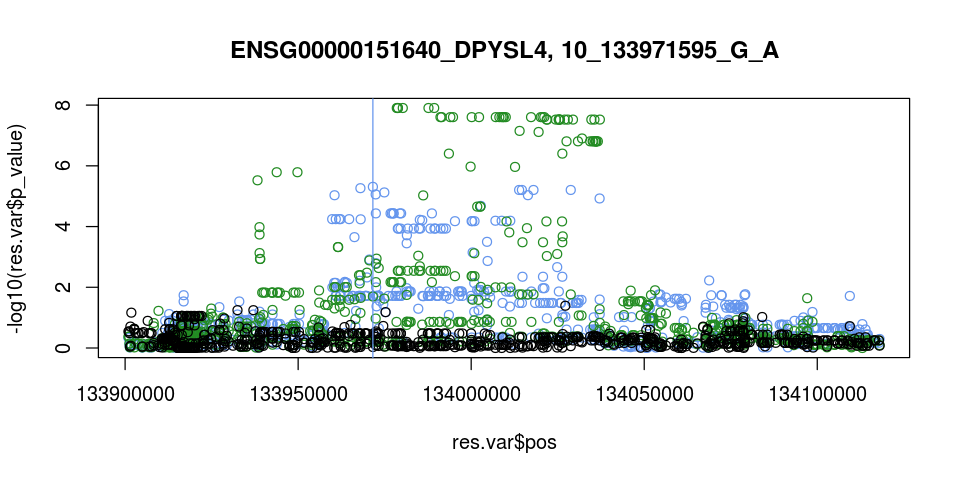

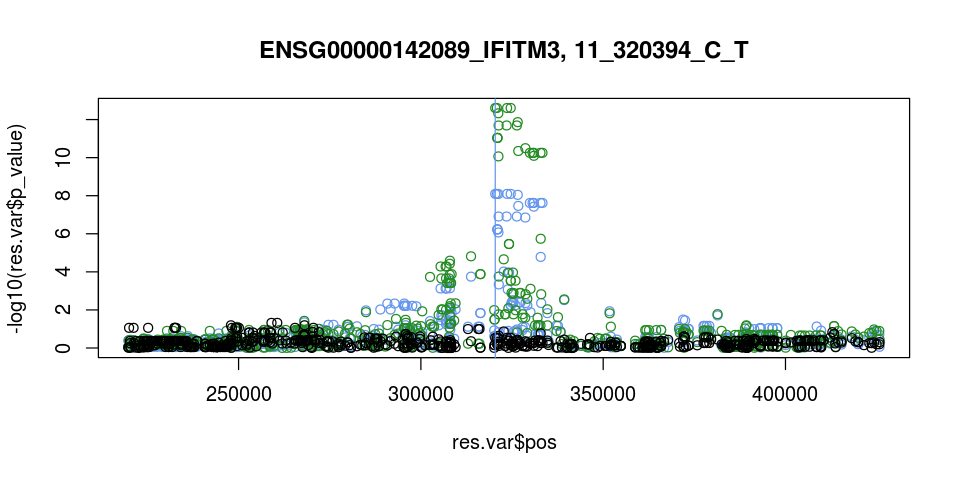

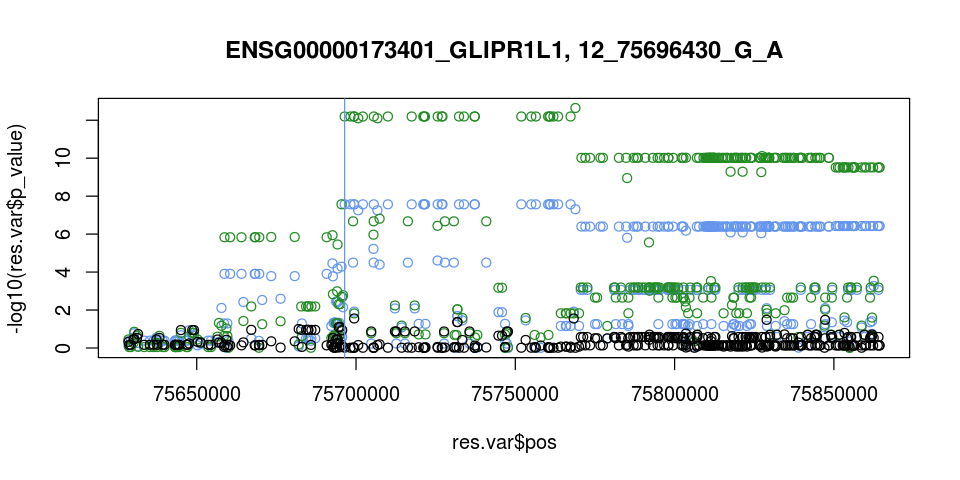

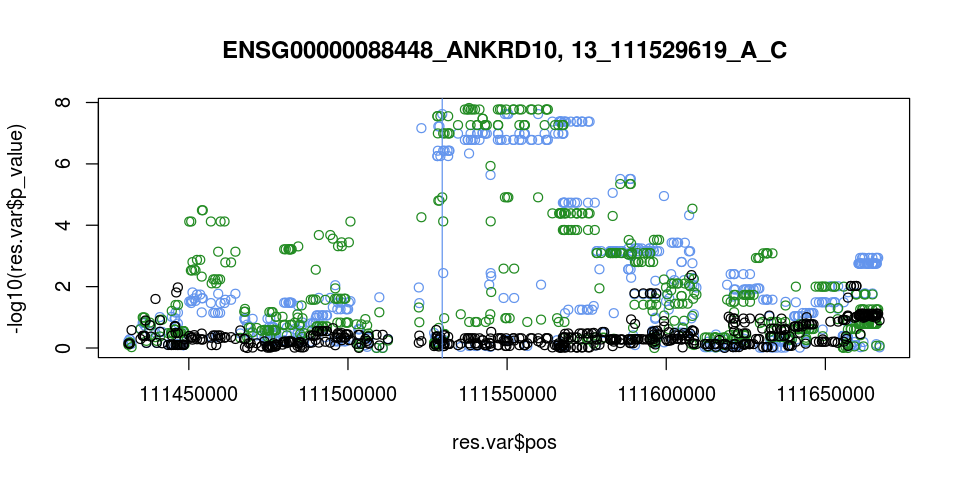

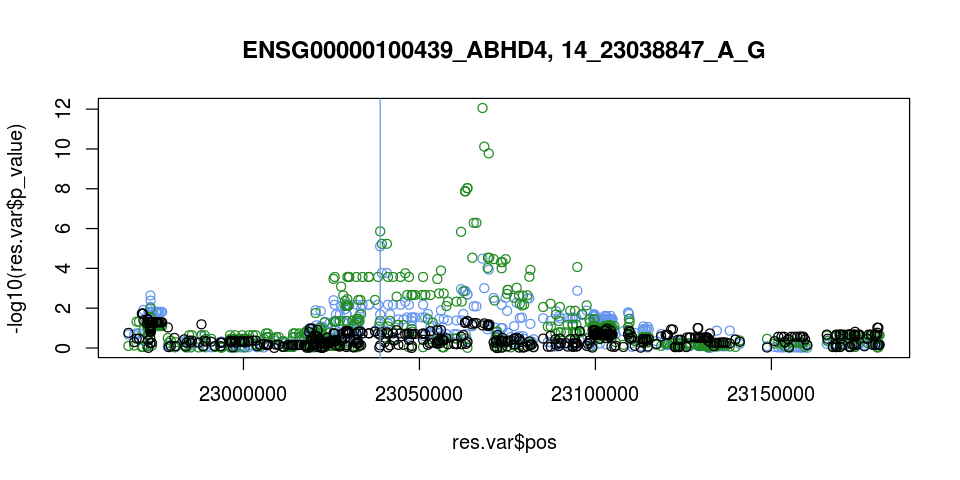

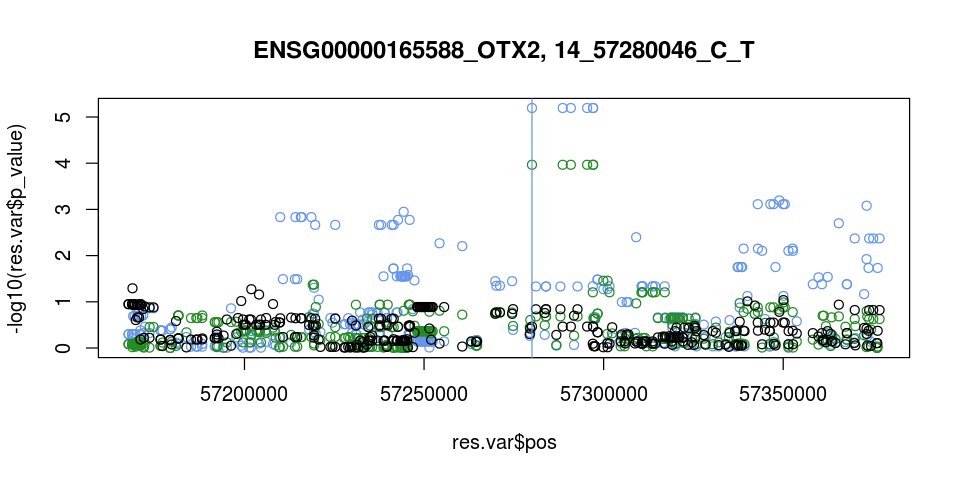

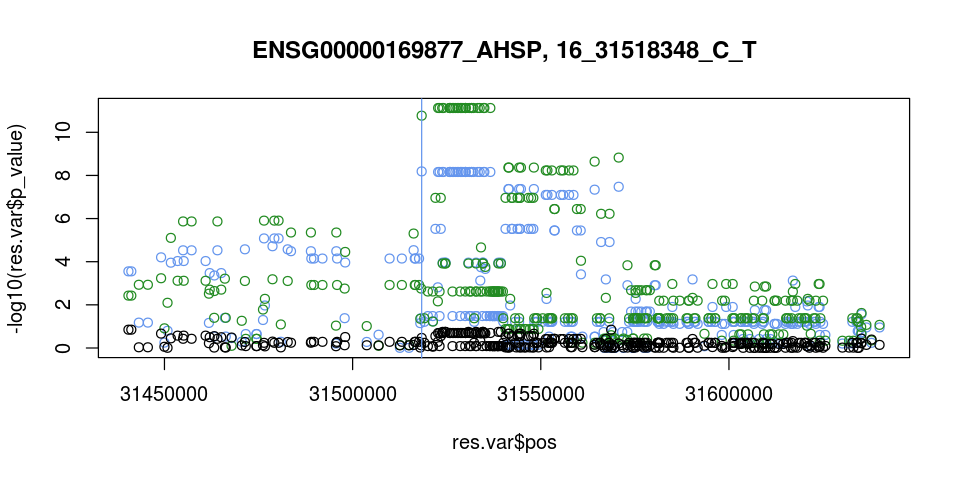

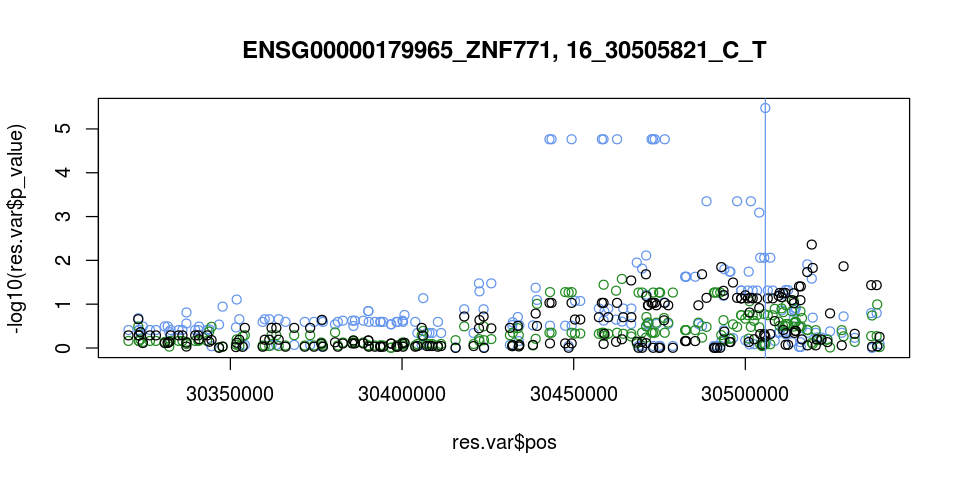

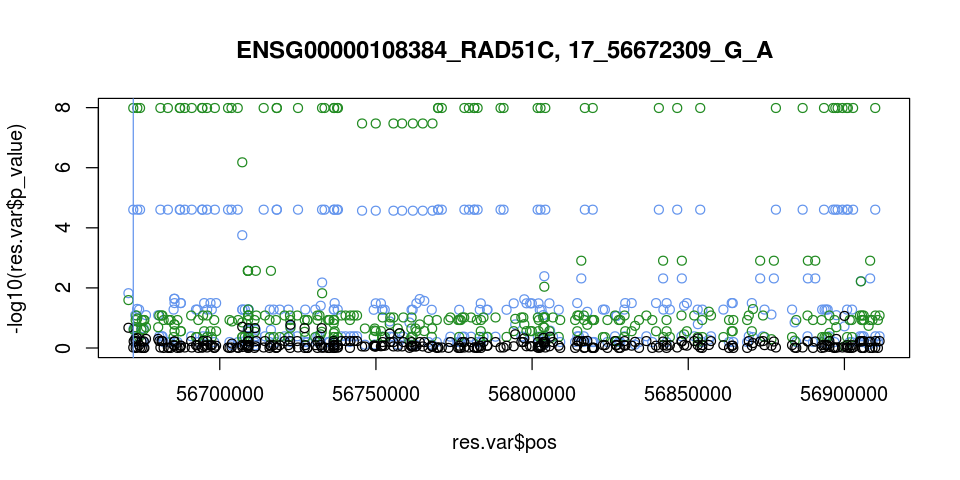

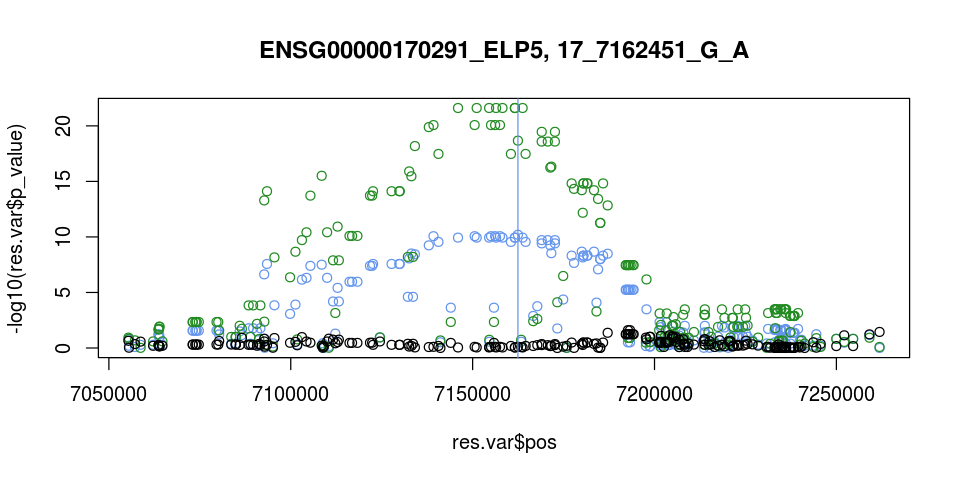

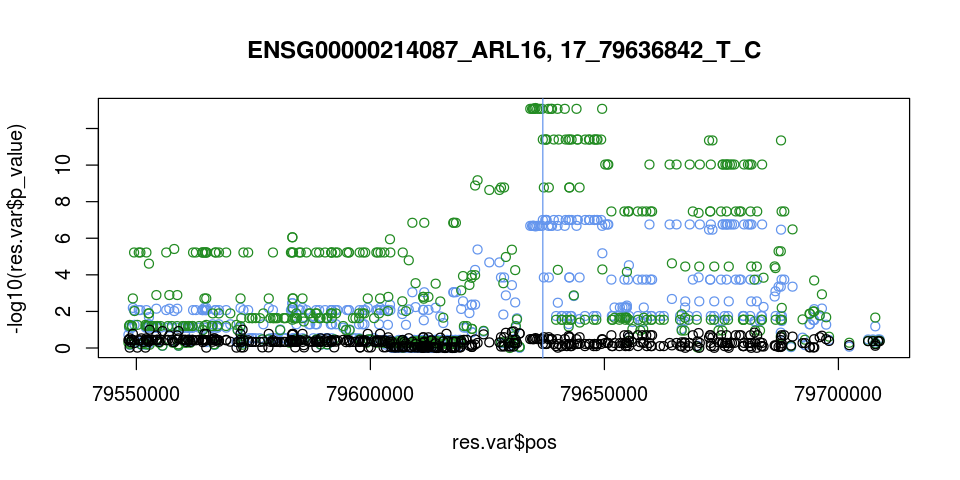

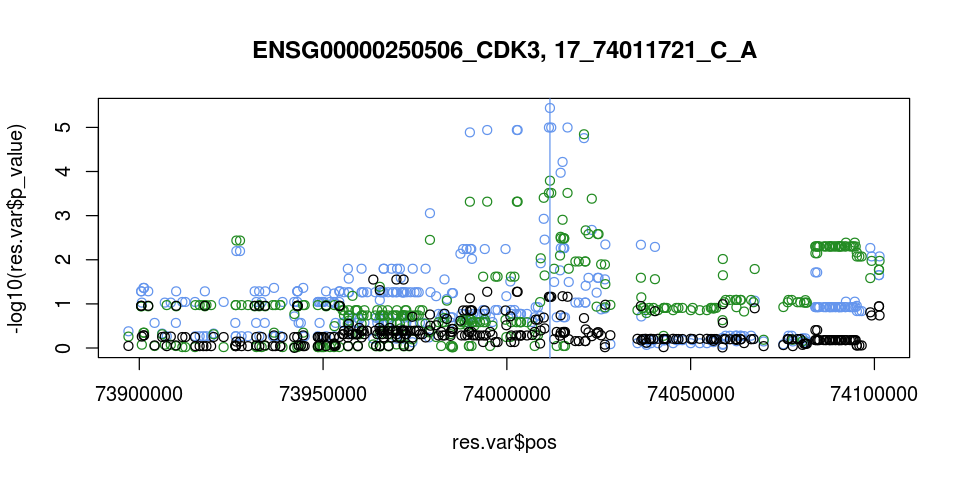

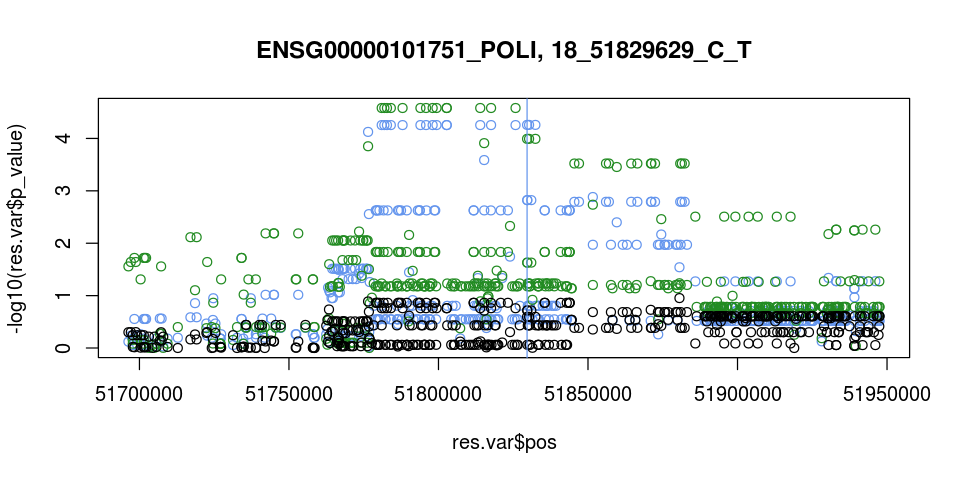

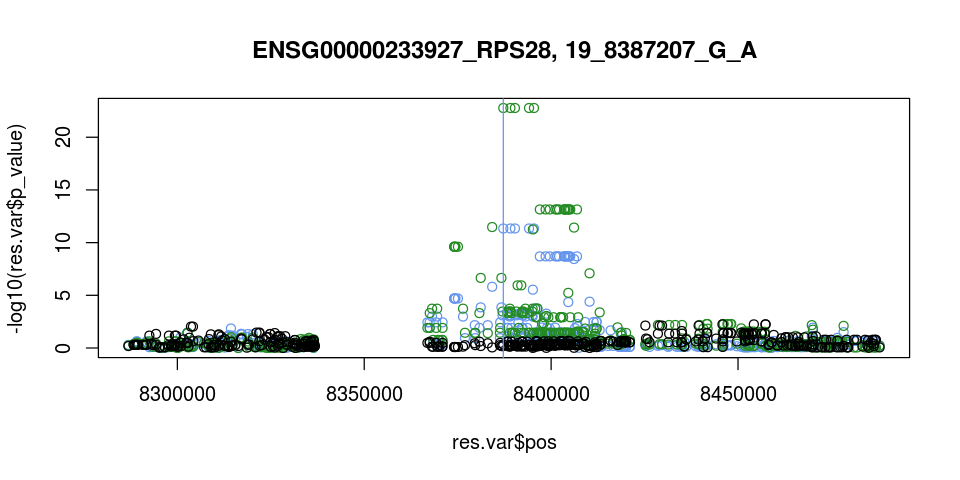

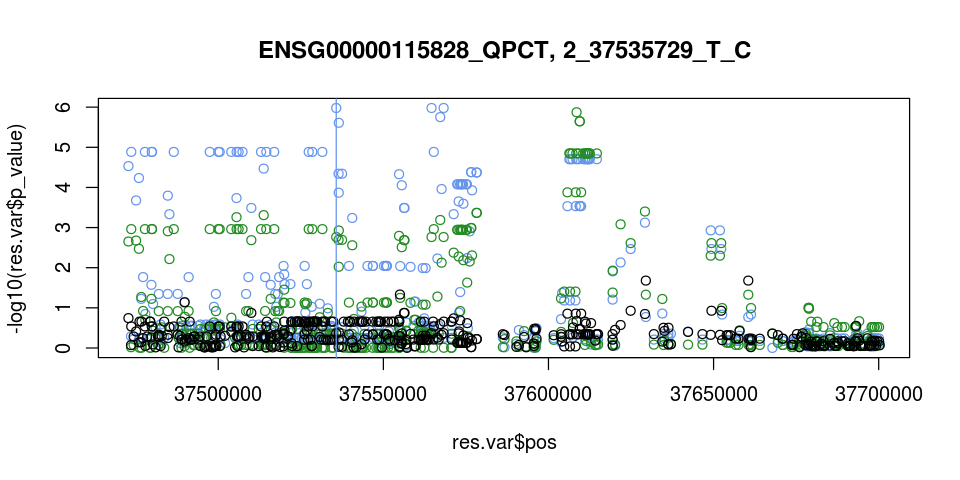

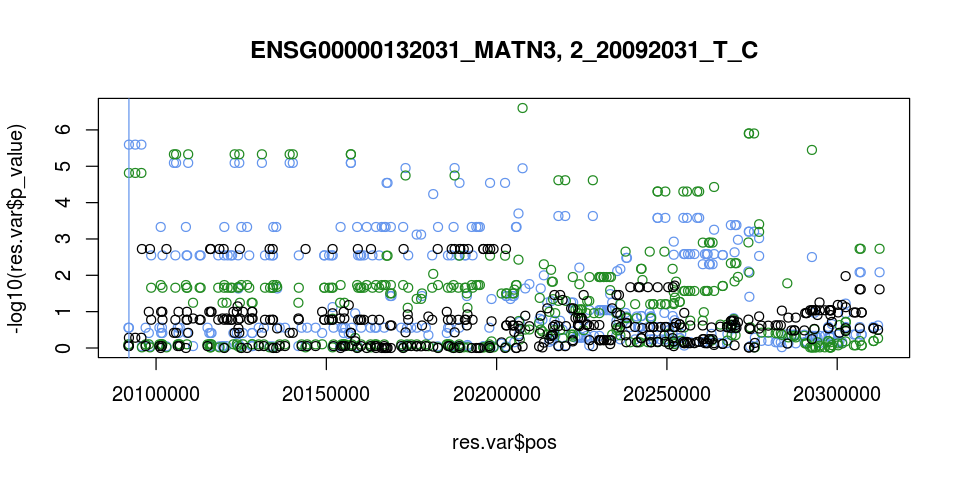

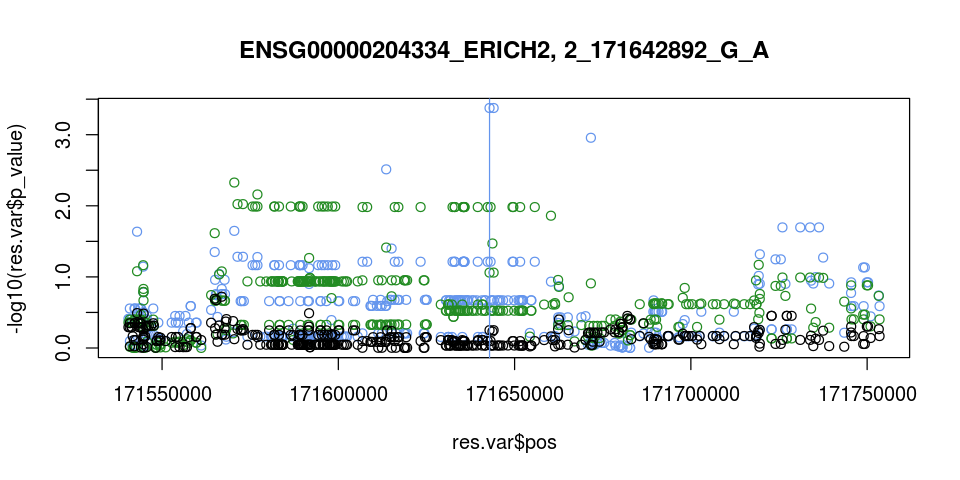

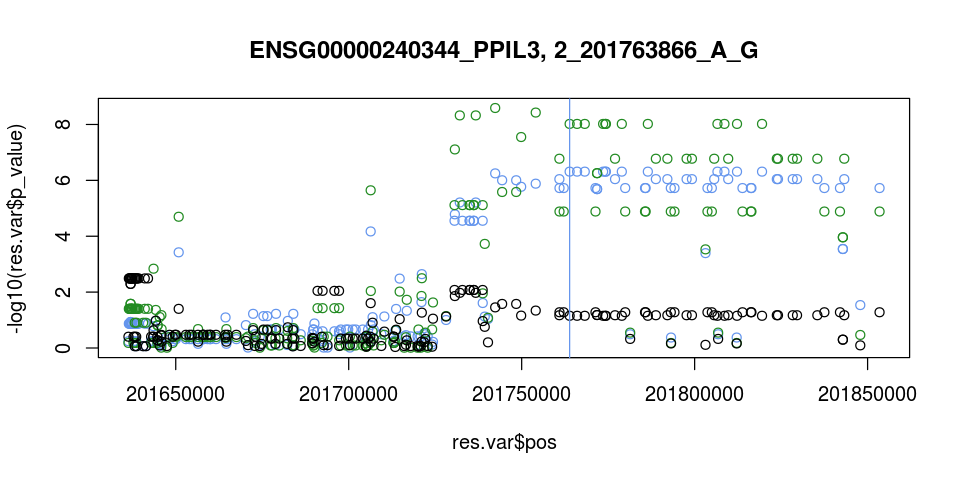

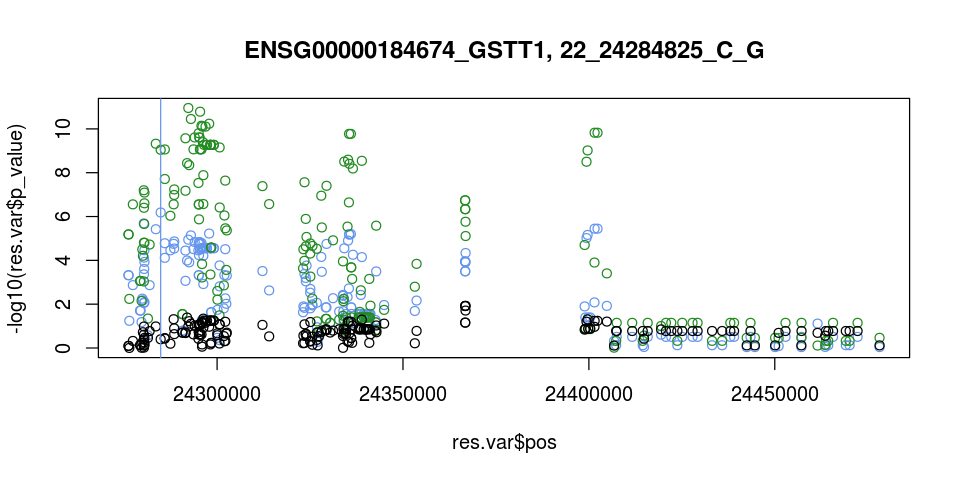

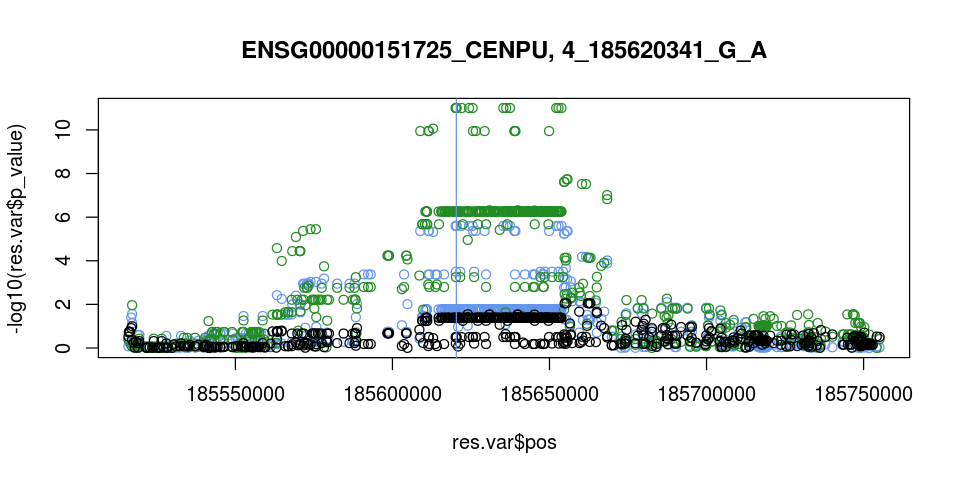

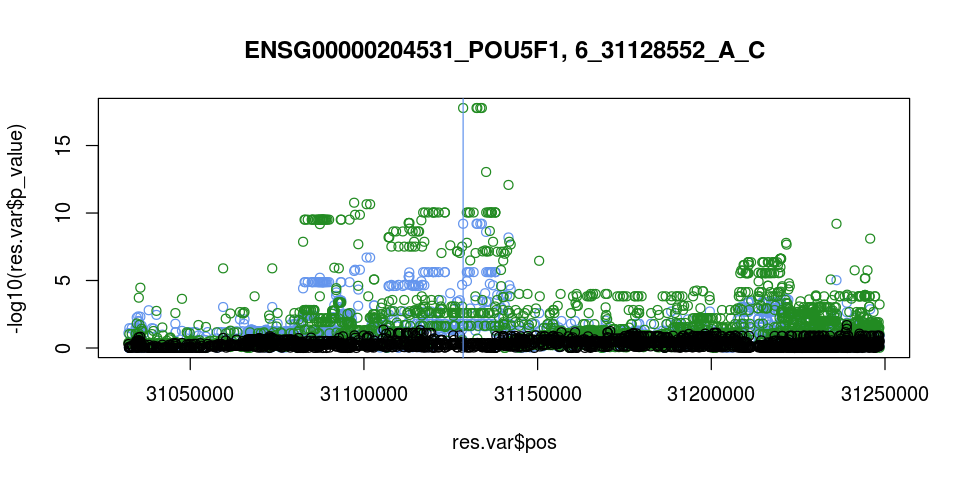

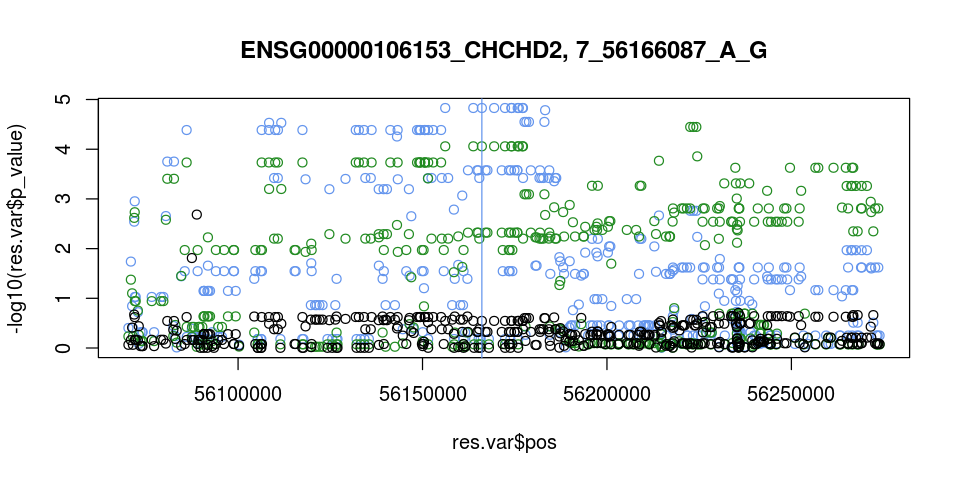

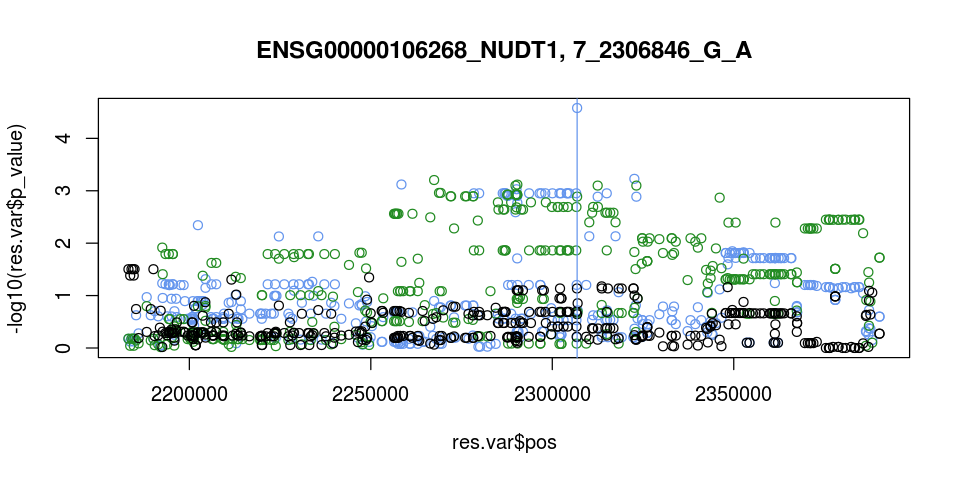

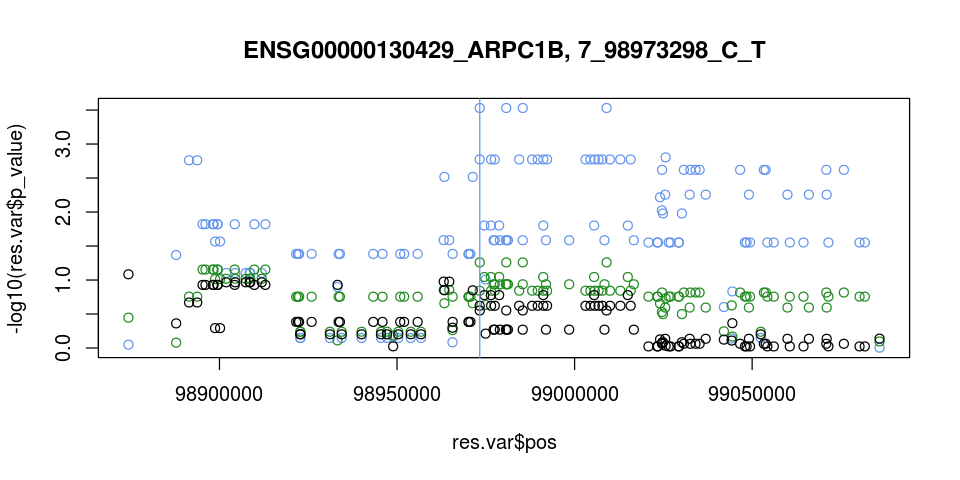

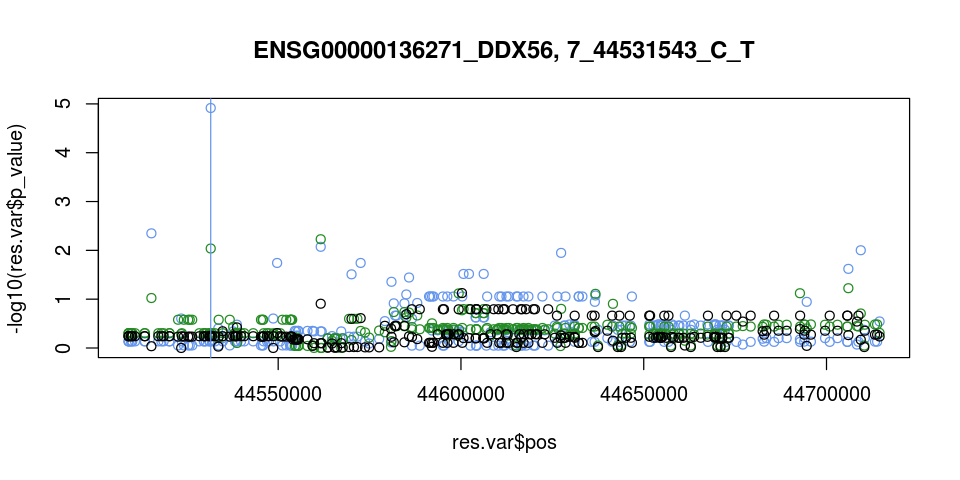

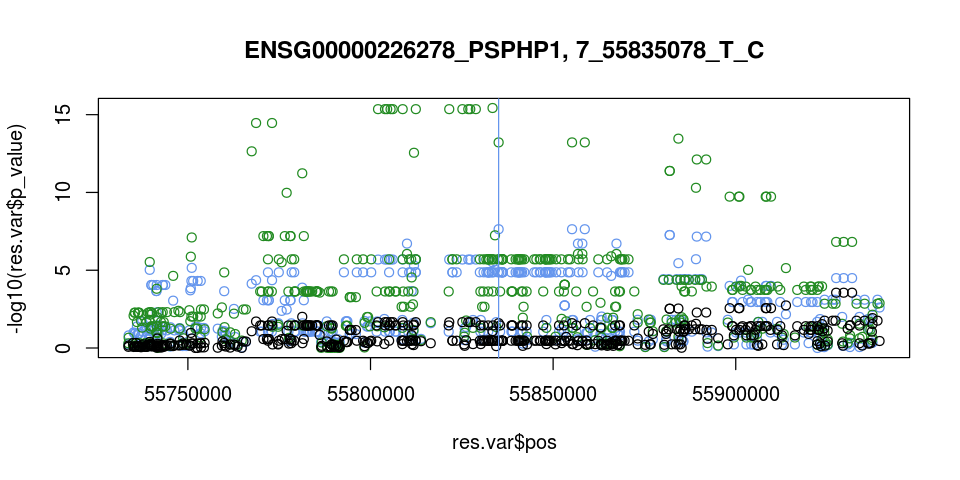

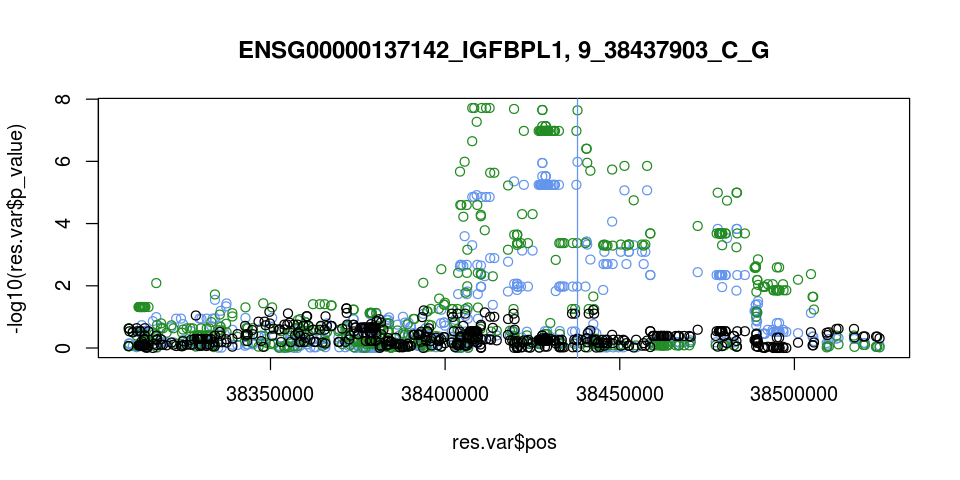

In [57]:
par(mfrow = c(1,1))
options(repr.plot.width = 8, repr.plot.height = 4)
for (i in 1:dim(top)[1]){
    snp_id = top[i,"snp_id"]
    feature = top[i,"feature"]
    if (length(grep("HLA", feature))==0) 
        {PlotManhattan(snp_id, feature)}
}

In [100]:
folder_dxe2 <- "/nfs/leia/research/stegle/acuomo/donor_expt/80donor_expt_mean_2pcs/"
resdxe2 <- GetResults(folder_dxe2)
permsdxe2 <- GetPerms(folder_dxe2)
leadsdxe2 <- GetTopResults(folder_dxe2)
results_dxe2 <- inner_join(permsdxe2, resdxe2, by = c("feature","snp_id"))
leads_dxe2 <- inner_join(permsdxe2, leadsdxe2, by = c("feature","snp_id"))

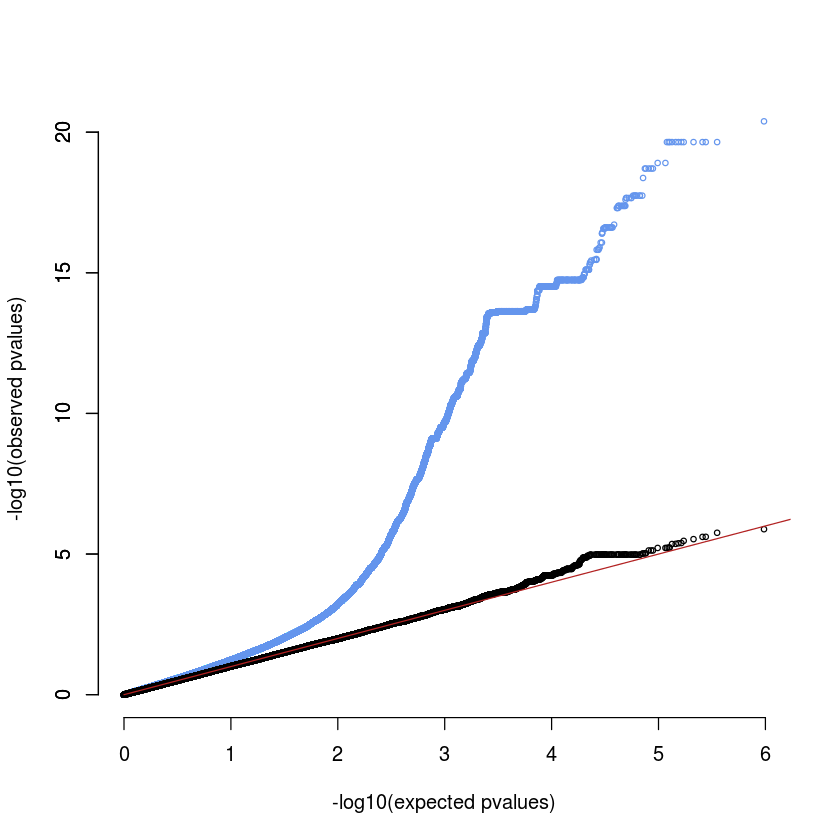

In [85]:
PlotQQ(results_dxe2)

In [101]:
dim(leads_dxe2[leads_dxe2$global_corr_p_value < 0.1,])

[1] 213  21

In [21]:
min(leads_dxe$global_corr_p_value)

[1] 9.383078e-27

In [114]:
write.csv(results_dxe2,"/nfs/leia/research/stegle/acuomo/donor_expt/allresults_donor_expt_80_mean_2pcs.csv")
write.csv(leads_dxe2,"/nfs/leia/research/stegle/acuomo/donor_expt/leads_donor_expt_80_mean_2pcs.csv")

In [67]:
folder_dxe5_qng <- "/nfs/leia/research/stegle/acuomo/donor_expt/qn_genes/80donor_expt_mean_5pcs/"
resdxe5_qng <- GetResults(folder_dxe5_qng)
permsdxe5_qng <- GetPerms(folder_dxe5_qng)
leadsdxe5_qng <- GetTopResults(folder_dxe5_qng)
results_dxe5_qng <- inner_join(permsdxe5_qng, resdxe5_qng, by = c("feature","snp_id"))
leads_dxe5_qng <- inner_join(permsdxe5_qng, leadsdxe5_qng, by = c("feature","snp_id"))

In [68]:
write.csv(results_dxe5_qng,"/nfs/leia/research/stegle/acuomo/donor_expt/qn_genes/allresults_donor_expt_80_mean_5pcs.csv")
write.csv(leads_dxe5_qng,"/nfs/leia/research/stegle/acuomo/donor_expt/qn_genes/leads_donor_expt_80_mean_5pcs.csv")

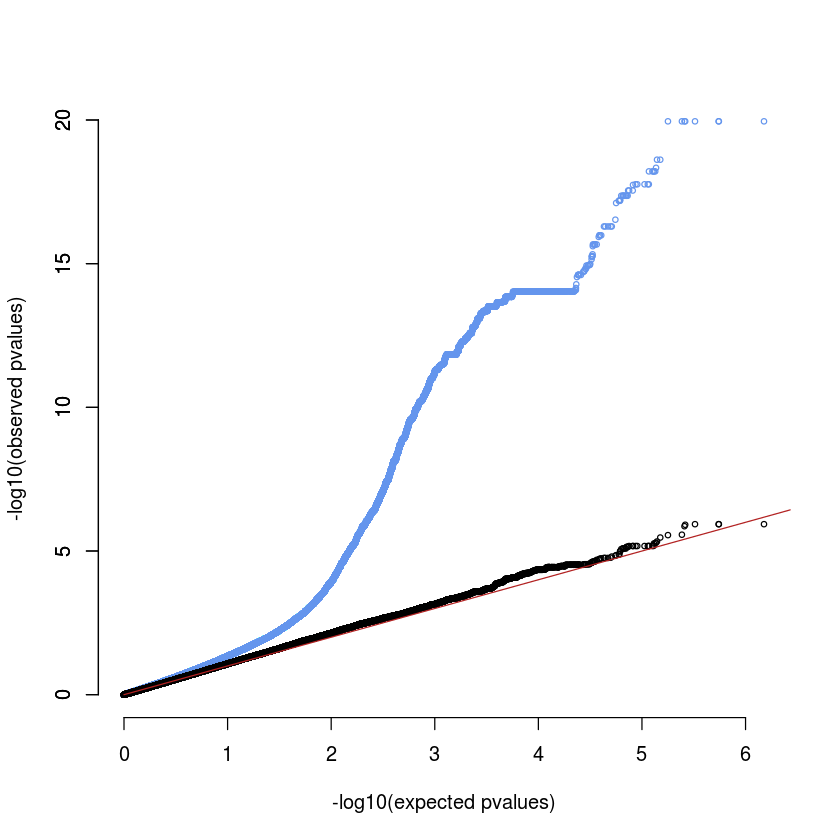

In [14]:
PlotQQ(results_dxe5_qng)

In [13]:
dim(leads_dxe5_qng[leads_dxe5_qng$global_corr_p_value < 0.1,])

[1] 216  21

In [12]:
folder_dxe5 <- "/nfs/leia/research/stegle/acuomo/donor_expt/80donor_expt_mean_5pcs/"
resdxe5 <- GetResults(folder_dxe5)
permsdxe5 <- GetPerms(folder_dxe5)
leadsdxe5 <- GetTopResults(folder_dxe5)
results_dxe5 <- inner_join(permsdxe5, resdxe5, by = c("feature","snp_id"))
leads_dxe5 <- inner_join(permsdxe5, leadsdxe5, by = c("feature","snp_id"))

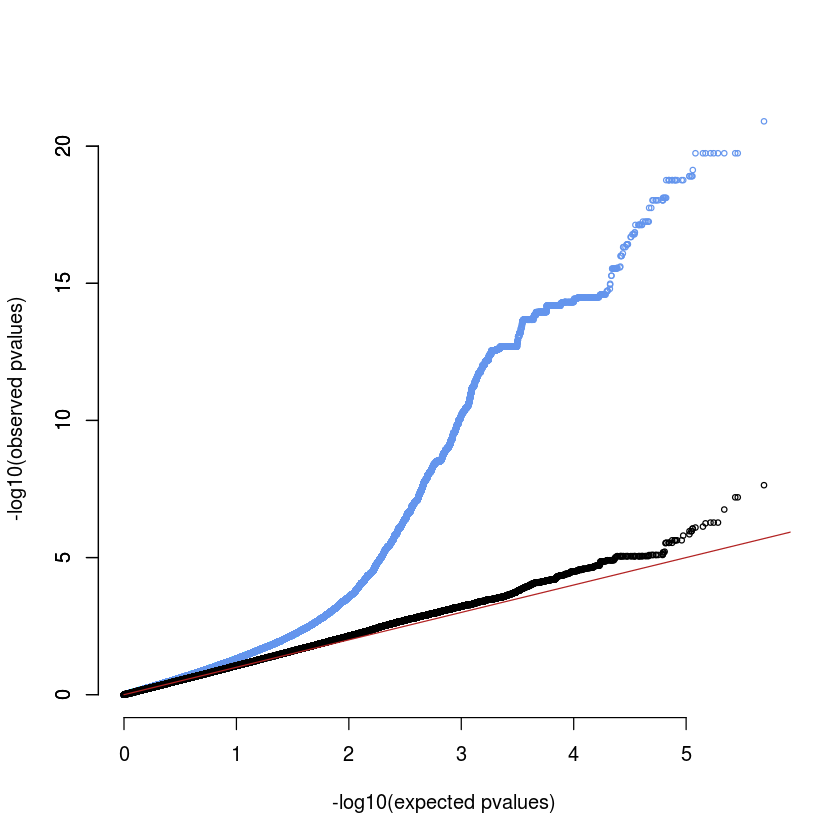

In [86]:
PlotQQ(results_dxe5)

In [13]:
dim(leads_dxe5[leads_dxe5$global_corr_p_value < 0.1,])

[1] 207  21

In [113]:
write.csv(results_dxe5,"/nfs/leia/research/stegle/acuomo/donor_expt/allresults_donor_expt_80_mean_5pcs.csv")
write.csv(leads_dxe5,"/nfs/leia/research/stegle/acuomo/donor_expt/leads_donor_expt_80_mean_5pcs.csv")

In [69]:
folder_dxe10_qng <- "/nfs/leia/research/stegle/acuomo/donor_expt/qn_genes/80donor_expt_mean_10pcs/"
resdxe10_qng <- GetResults(folder_dxe10_qng)
permsdxe10_qng <- GetPerms(folder_dxe10_qng)
leadsdxe10_qng <- GetTopResults(folder_dxe10_qng)
results_dxe10_qng <- inner_join(permsdxe10_qng, resdxe10_qng, by = c("feature","snp_id"))
leads_dxe10_qng <- inner_join(permsdxe10_qng, leadsdxe10_qng, by = c("feature","snp_id"))

In [70]:
write.csv(results_dxe10_qng,"/nfs/leia/research/stegle/acuomo/donor_expt/qn_genes/allresults_donor_expt_80_mean_10pcs.csv")
write.csv(leads_dxe10_qng,"/nfs/leia/research/stegle/acuomo/donor_expt/qn_genes/leads_donor_expt_80_mean_10pcs.csv")

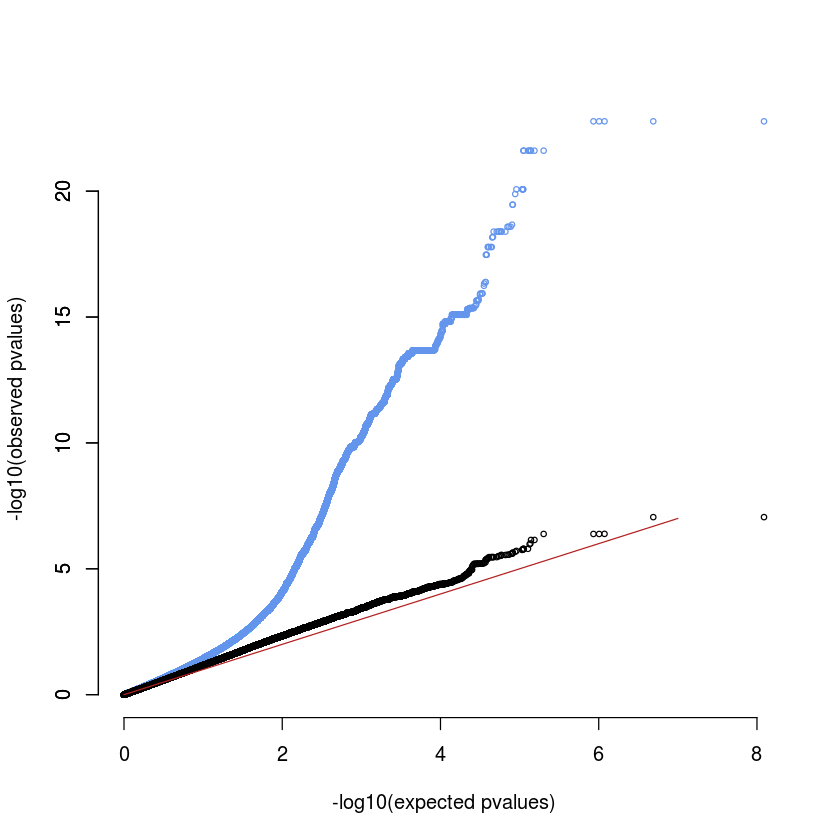

In [55]:
PlotQQ(results_dxe10_qng)

In [15]:
dim(leads_dxe10_qng[leads_dxe10_qng$global_corr_p_value < 0.1,])

[1] 225  21

In [104]:
folder_dxe10 <- "/nfs/leia/research/stegle/acuomo/donor_expt/80donor_expt_mean_10pcs/"
resdxe10 <- GetResults(folder_dxe10)
permsdxe10 <- GetPerms(folder_dxe10)
leadsdxe10 <- GetTopResults(folder_dxe10)
results_dxe10 <- inner_join(permsdxe10, resdxe10, by = c("feature","snp_id"))
leads_dxe10 <- inner_join(permsdxe10, leadsdxe10, by = c("feature","snp_id"))

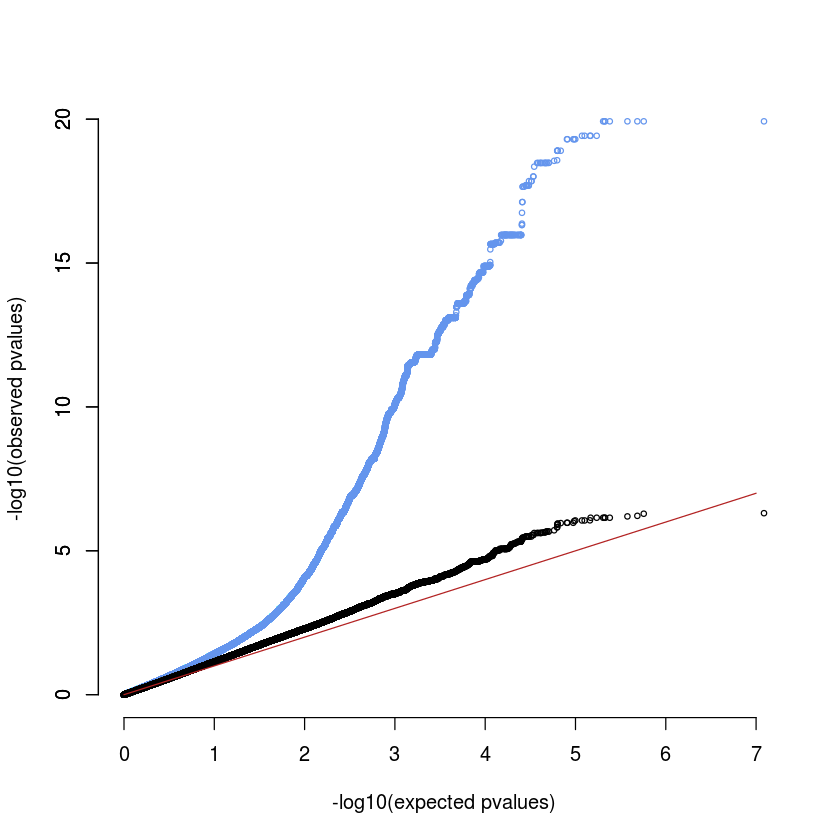

In [89]:
PlotQQ(results_dxe10)

In [105]:
dim(leads_dxe10[leads_dxe10$global_corr_p_value < 0.1,])

[1] 199  21

In [112]:
write.csv(results_dxe10,"/nfs/leia/research/stegle/acuomo/donor_expt/allresults_donor_expt_80_mean_10pcs.csv")
write.csv(leads_dxe10,"/nfs/leia/research/stegle/acuomo/donor_expt/leads_donor_expt_80_mean_10pcs.csv")

In [71]:
folder_dxe20_qng <- "/nfs/leia/research/stegle/acuomo/donor_expt/qn_genes/80donor_expt_mean_20pcs/"
resdxe20_qng <- GetResults(folder_dxe20_qng)
permsdxe20_qng <- GetPerms(folder_dxe20_qng)
leadsdxe20_qng <- GetTopResults(folder_dxe20_qng)
results_dxe20_qng <- inner_join(permsdxe20_qng, resdxe20_qng, by = c("feature","snp_id"))
leads_dxe20_qng <- inner_join(permsdxe20_qng, leadsdxe20_qng, by = c("feature","snp_id"))

In [72]:
write.csv(results_dxe20_qng,"/nfs/leia/research/stegle/acuomo/donor_expt/qn_genes/allresults_donor_expt_80_mean_20pcs.csv")
write.csv(leads_dxe20_qng,"/nfs/leia/research/stegle/acuomo/donor_expt/qn_genes/leads_donor_expt_80_mean_20pcs.csv")

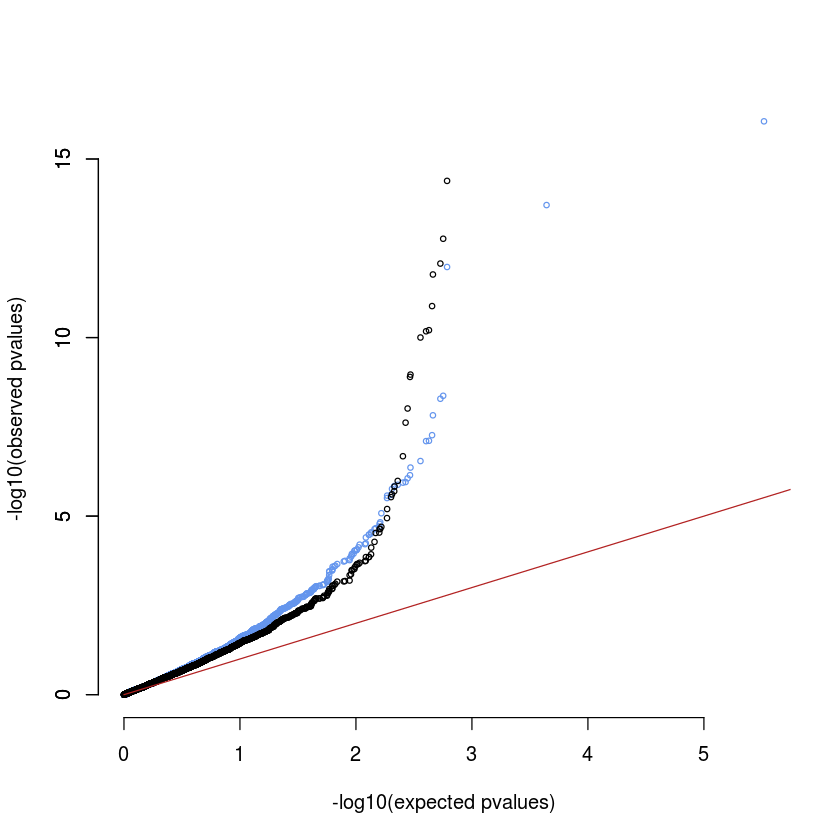

In [28]:
PlotQQ_1snp(results_dxe20_qng)

In [17]:
dim(leads_dxe20_qng[leads_dxe20_qng$global_corr_p_value < 0.1,])

[1] 116  21

In [15]:
folder_dxe <- "/nfs/leia/research/stegle/acuomo/donor_expt/80donor_expt_mean_20pcs/"
resdxe <- GetResults(folder_dxe)
permsdxe <- GetPerms(folder_dxe)
leadsdxe <- GetTopResults(folder_dxe)
results_dxe <- inner_join(permsdxe, resdxe, by = c("feature","snp_id"))
leads_dxe <- inner_join(permsdxe, leadsdxe, by = c("feature","snp_id"))

In [109]:
head(permsdxe)

permutation_0 permutation_1 permutation_2 permutation_3 permutation_4
1 0.03043101    0.10579266    0.9365941     0.7934826     0.7353464    
2 0.06702598    0.08224173    0.8711194     0.9051630     0.5873442    
3 0.02029484    0.13385115    0.9006836     0.8285487     0.9081429    
4 0.02029484    0.13385115    0.9006836     0.8285487     0.9081429    
5 0.02029484    0.13385115    0.9006836     0.8285487     0.9081429    
6 0.02029484    0.13385115    0.9006836     0.8285487     0.9081429    
  permutation_5 permutation_6 permutation_7 permutation_8 permutation_9
1 0.4793098     0.6099668     0.02538252    0.5095166     0.04752269   
2 0.4603600     0.3275197     0.11218248    0.7700252     0.05218586   
3 0.4347220     0.5680092     0.01917657    0.8693498     0.03039470   
4 0.4347220     0.5680092     0.01917657    0.8693498     0.03039470   
5 0.4347220     0.5680092     0.01917657    0.8693498     0.03039470   
6 0.4347220     0.5680092     0.01917657    0.8693498     0.03039470   
  snp_id         feature            
1 1_33374147_T_C ENSG00000004455_AK2
2 1_33376347_C_A ENSG00000004455_AK2
3 1_33376682_T_A ENSG00000004455_AK2
4 1_33377098_G_A ENSG00000004455_AK2
5 1_33377679_T_C ENSG00000004455_AK2
6 1_33379842_C_T ENSG00000004455_AK2

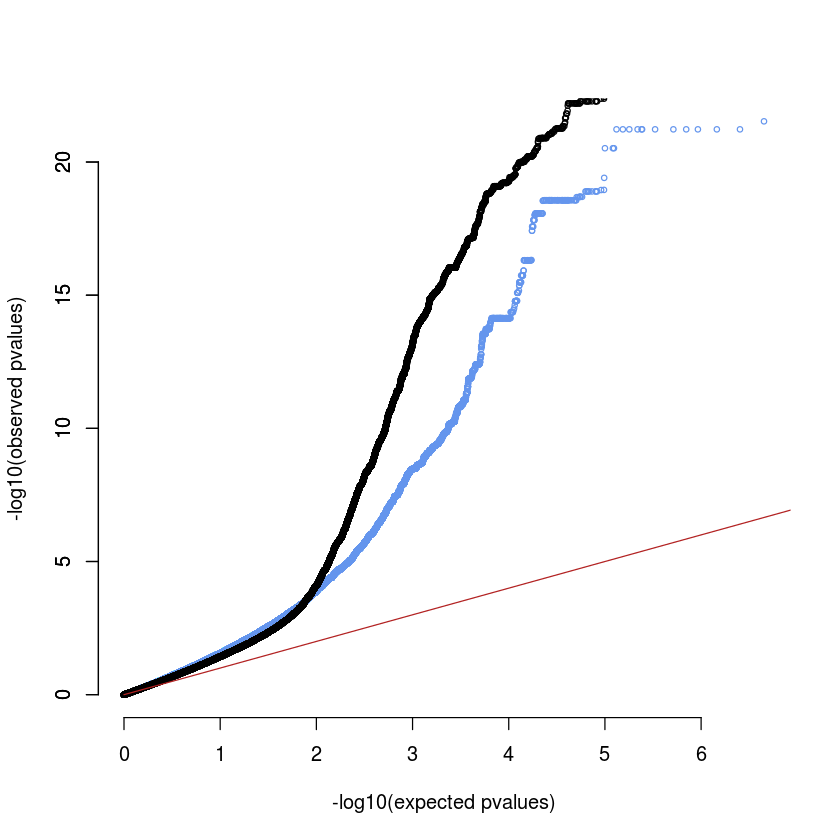

In [8]:
PlotQQ(results_dxe)

In [16]:
dim(leads_dxe[leads_dxe$global_corr_p_value < 0.1,])

[1] 126  21

In [122]:
write.csv(results_dxe,"/nfs/leia/research/stegle/acuomo/donor_expt/allresults_donor_expt_80_mean_20pcs.csv")
write.csv(leads_dxe,"/nfs/leia/research/stegle/acuomo/donor_expt/leads_donor_expt_80_mean_20pcs.csv")

In [12]:
folder_pseudo20 <- "/nfs/leia/research/stegle/acuomo/62samples_day0_hvgs_20pcs_sc_pseudobulk_logcpm/"
respseudo20 <- GetResults(folder_pseudo20)
permspseudo20 <- GetPerms(folder_pseudo20)
leadspseudo20 <- GetTopResults(folder_pseudo20)
results_pseudo20 <- inner_join(permspseudo20, respseudo20, by = c("feature","snp_id"))
leads_pseudo20 <- inner_join(permspseudo20, leadspseudo20, by = c("feature","snp_id"))

In [13]:
write.csv(results_pseudo20,"/nfs/leia/research/stegle/acuomo/allresults_62samples_day0_hvgs_pseudobulk_20PCs.csv")
write.csv(leads_pseudo20,"/nfs/leia/research/stegle/acuomo/leads_62samples_day0_hvgs_pseudobulk_20PCs.csv")

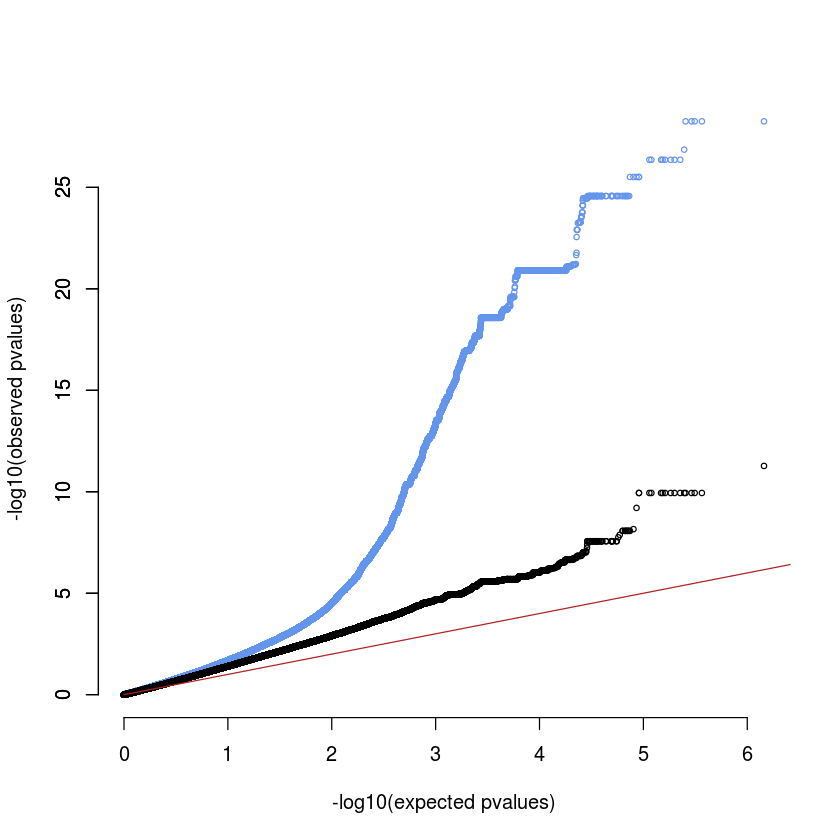

In [14]:
PlotQQ(results_pseudo20)

In [15]:
dim(leads_pseudo20[leads_pseudo20$global_corr_p_value < 0.1,])

[1] 107  13

In [16]:
folder_bcpm20 <- "/nfs/leia/research/stegle/acuomo/62samples_day0_hvgs_20pcs_bulk_logcpm/"
resbcpm20 <- GetResults(folder_bcpm20)
permsbcpm20 <- GetPerms(folder_bcpm20)
leadsbcpm20 <- GetTopResults(folder_bcpm20)
results_bcpm20 <- inner_join(permsbcpm20, resbcpm20, by = c("feature","snp_id"))
leads_bcpm20 <- inner_join(permsbcpm20, leadsbcpm20, by = c("feature","snp_id"))

In [17]:
write.csv(results_bcpm20,"/nfs/leia/research/stegle/acuomo/allresults_62samples_day0_hvgs_bulk_cpm_20PCs.csv")
write.csv(leads_bcpm20,"/nfs/leia/research/stegle/acuomo/leads_62samples_day0_hvgs_bulk_cpm_20PCs.csv")

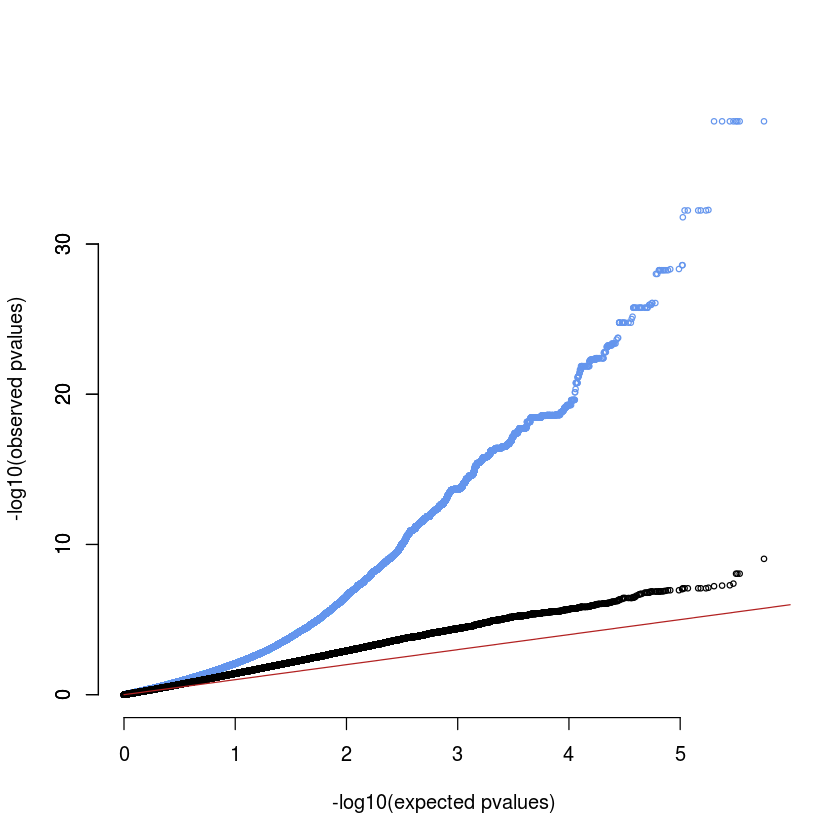

In [18]:
PlotQQ(results_bcpm20)

In [19]:
dim(leads_bcpm20[leads_bcpm20$global_corr_p_value < 0.1,])

[1] 698  13

In [106]:
bulk_leads <- inner_join(leads_bcpm20, results_pseudo20, by = c("snp_id","feature"), suffix = c(".bulk",".pseudo"))
pseudo_leads <- inner_join(results_bcpm20, leads_pseudo20, by = c("snp_id","feature"), suffix = c(".bulk",".pseudo"))

In [107]:
# how many gene-SNP pairs are in common
c(dim(bulk_leads)[1], dim(leads_bcpm20)[1], dim(bulk_leads)[1]/dim(leads_bcpm20)[1])
c(dim(pseudo_leads)[1], dim(leads_pseudo20)[1], dim(pseudo_leads)[1]/dim(leads_pseudo20)[1])

[1] 4079.0000000 4464.0000000    0.9137545

[1] 4078.0000000 4115.0000000    0.9910085

In [130]:
# how many replicating QTLs
b1 = dim(bulk_leads[bulk_leads$global_corr_p_value < 0.1 & bulk_leads$p_value.pseudo < 0.05,])[1]
b = dim(bulk_leads[bulk_leads$global_corr_p_value < 0.1,])[1]
c(b1, b, b1/b)
pb1 = dim(pseudo_leads[pseudo_leads$global_corr_p_value < 0.1 & pseudo_leads$p_value.bulk < 0.05,])[1]
pb = dim(pseudo_leads[pseudo_leads$global_corr_p_value < 0.1,])[1]
c(pb1, pb, pb1/pb)

[1] 326.0000000 639.0000000   0.5101721

[1]  90.0 100.0   0.9

In [123]:
### load single cell datasets 
sce_day0 <- readRDS(file = "/hps/nobackup/hipsci/scratch/singlecell_endodiff/data_processed/merged/sce_merged_qc_hvg_day0_for_qtl.rds")
n_genes = dim(exprs(sce_day0))[1]
ncells = dim(exprs(sce_day0))[2]
ndonors = length(unique(sce_day0$donor_long_id))
c(n_genes, ncells, ndonors)

[1] 4652 3882   62

In [124]:
bulk <- readRDS("/hps/nobackup/stegle/users/acuomo/merged_bulk_salmon_quant.rds")
logcpm_bulk <- cpm(counts(bulk), prior.count = 2, log = TRUE)
newcols <- gsub(".*/quant_salmon/*","",colnames(logcpm_bulk))
cols <- gsub("*.hs.*","",newcols)
colnames(logcpm_bulk) <- cols
head(logcpm_bulk)

HPSI0114i-bezi_1 HPSI0114i-bezi_3 HPSI0114i-eipl_1
ENSG00000000003_TSPAN6    6.7478423        7.3723219        6.6027879      
ENSG00000000005_TNMD      1.2396445        2.6075143        2.7457270      
ENSG00000000419_DPM1      6.4351540        6.5435280        6.4535352      
ENSG00000000457_SCYL3     2.3010799        2.9414570        2.6672173      
ENSG00000000460_C1orf112  4.1690783        4.4894089        4.1502208      
ENSG00000000938_FGR      -0.5687158       -0.4913128       -0.5636239      
                         HPSI0114i-eipl_3 HPSI0114i-fikt_3 HPSI0114i-iisa_1
ENSG00000000003_TSPAN6    6.670467         6.5325557        6.2607908      
ENSG00000000005_TNMD      1.796040         1.8062487        1.4958215      
ENSG00000000419_DPM1      6.488400         6.7655019        6.4641320      
ENSG00000000457_SCYL3     2.182401         2.3778015        2.4083688      
ENSG00000000460_C1orf112  4.383631         4.8552867        4.6337829      
ENSG00000000938_FGR      -1.567461        -0.1777691       -0.6055767      
                         HPSI0114i-iisa_3 HPSI0114i-joxm_1 HPSI0114i-kolf_2
ENSG00000000003_TSPAN6    6.2049043        6.4136346        6.3794240      
ENSG00000000005_TNMD      1.4846523        1.2493527        1.4316536      
ENSG00000000419_DPM1      6.4412406        6.4584660        6.5721151      
ENSG00000000457_SCYL3     2.4962583        2.2587505        1.8163995      
ENSG00000000460_C1orf112  4.6588062        4.2474378        4.6036446      
ENSG00000000938_FGR      -0.6931276       -0.2360887       -0.6081928      
                         HPSI0114i-kolf_3 ⋯ HPSI0516i-eitu_4 HPSI0516i-goek_4
ENSG00000000003_TSPAN6    6.0982380       ⋯  4.7023961        6.1149095      
ENSG00000000005_TNMD      1.4975600       ⋯ -0.6699662        1.6624273      
ENSG00000000419_DPM1      6.4799760       ⋯  4.8197038        6.3267307      
ENSG00000000457_SCYL3     2.2621010       ⋯  1.9565996        1.9252852      
ENSG00000000460_C1orf112  4.0224097       ⋯  2.7470801        4.6034535      
ENSG00000000938_FGR      -0.6951849       ⋯ -1.2646136       -0.9360776      
                         HPSI0516i-hapz_2 HPSI0516i-hapz_3 HPSI0516i-iool_4
ENSG00000000003_TSPAN6    6.57452770       6.1132145        6.2374677      
ENSG00000000005_TNMD      0.05885042       1.5629860        1.9526607      
ENSG00000000419_DPM1      6.40022473       6.5999318        6.5161226      
ENSG00000000457_SCYL3     2.30901525       2.0644377        2.1351029      
ENSG00000000460_C1orf112  4.91861630       4.9475882        4.7577833      
ENSG00000000938_FGR      -0.50224959      -0.9039374       -0.8155414      
                         HPSI0516i-iool_6 HPSI0516i-oazw_3 HPSI0516i-oazw_4
ENSG00000000003_TSPAN6    6.4816297        6.3242236        6.7140318      
ENSG00000000005_TNMD      0.4264122        2.0207997        0.9451023      
ENSG00000000419_DPM1      6.4691210        6.5576157        6.5994284      
ENSG00000000457_SCYL3     2.2461685        2.0773365        2.5382794      
ENSG00000000460_C1orf112  4.9104630        5.0092311        5.1485615      
ENSG00000000938_FGR      -1.1706325       -0.8873781       -0.8635696      
                         HPSI0516i-pews_2 HPSI0516i-pews_3
ENSG00000000003_TSPAN6    6.765941         6.5507389      
ENSG00000000005_TNMD      3.115977         0.7879407      
ENSG00000000419_DPM1      6.660242         6.5900378      
ENSG00000000457_SCYL3     2.181280         2.0659557      
ENSG00000000460_C1orf112  4.999442         4.7960390      
ENSG00000000938_FGR      -1.576341        -1.4254717

In [128]:
sce_day0[gsub(".*_","",rownames(sce_day0)) == "HMBS"]

class: SingleCellExperiment 
dim: 0 3882 
metadata(1): log.exprs.offset
assays(3): tpm counts logcounts
rownames: NULL
rowData names(52): exprs_collapsed_to ensembl_transcript_id ...
  log10_total_counts_control pct_counts_control
colnames(3882): 20759_2#100 20759_2#102 ... 24229_3#93 24229_3#94
colData names(125): salmon_version samp_type ... cell_filter
  size_factor
reducedDimNames(0):
spikeNames(1): ERCC

In [125]:
df_bulk_sc_expt <- function(gene, bulk.set, sc.set){
    # single cell
    exprs.sc <- counts(sc.set)[gene,]
    donor <- gsub("-","_",sc.set$donor_long_id)
    expt <- sc.set$experiment
    donor_expt <- paste0(donor, "-", expt)
    df0 <- as.data.frame(cbind(exprs.sc, donor, expt, donor_expt))
    df <- df0 %>% group_by(donor_expt) %>% summarize(sum.exprs.sc = sum(as.numeric(exprs.sc)))
    df <- as.data.frame(df)
    colnames(df) <- c("donor.expt", "sum.exprs.sc")
    df$sum.exprs.sc <- log2(df$sum.exprs.sc + 1)
    df$donor <- gsub("*-.*","",df$donor.expt)
    df$expt <- gsub(".*-","",df$donor.expt)
    # bulk
    exprs.bulk <- bulk.set[rownames(bulk.set) == gene,]
    df1 <- as.data.frame(exprs.bulk)
    df1 <- cbind(df1,rownames(df1))
    df1 <- as.data.frame(df1)
    colnames(df1) <- c("exprs.bulk", "donor")
    df1$donor <- gsub("-","_",df1$donor)
    # join
    plot_df <- inner_join(df, df1, by = "donor")
    plot_df
}

In [126]:
gene = "ENSG00000111704_NANOG"
# gene = "ENSG00000204531_POU5F1"
gene = "ENSG00000164362_TERT"
gene = "ENSG00000181449_SOX2"
# gene = "ENSG00000121570_DPPA4"
gene = "ENSG00000256269_HMBS"
bulk.set <- logcpm_bulk
sc.set = sce_day0
plot_df <- df_bulk_sc_expt(gene, bulk.set, sc.set)
ggplot(plot_df) + 
          geom_point(aes(x = as.numeric(exprs.bulk), y = sum.exprs.sc, colour = expt)) 

ERROR: Error in counts(sc.set)[gene, ]: subscript out of bounds


In [127]:
gene = "ENSG00000111704_NANOG"
gene = "ENSG00000256269_HMBS"
sc.set = sce_day0
exprs.sc <- counts(sc.set)[gene,]
donor <- gsub("-","_",sc.set$donor_long_id)
expt <- sc.set$experiment
donor_expt <- paste0(donor, "-", expt)
df0 <- as.data.frame(cbind(exprs.sc, donor, expt, donor_expt))
head(df0)

ERROR: Error in counts(sc.set)[gene, ]: subscript out of bounds


In [59]:
df <- df0 %>% group_by(donor_expt) %>% summarize(sum.exprs.sc = sum(as.numeric(exprs.sc)))
df <- as.data.frame(df)
colnames(df) <- c("donor.expt", "sum.exprs.sc")
df$sum.exprs.sc <- log2(df$sum.exprs.sc + 1)
df$donor <- gsub("*-.*","",df$donor.expt)
df$expt <- gsub(".*-","",df$donor.expt)
head(df)

donor.expt               sum.exprs.sc donor            expt   
1 HPSI0114i_iisa_1-expt_24 10.121677    HPSI0114i_iisa_1 expt_24
2 HPSI0114i_vass_1-expt_12 10.335063    HPSI0114i_vass_1 expt_12
3 HPSI0114i_zapk_3-expt_12 11.394349    HPSI0114i_zapk_3 expt_12
4 HPSI0115i_iiyk_4-expt_28 10.792532    HPSI0115i_iiyk_4 expt_28
5 HPSI0115i_vazt_1-expt_27 10.162912    HPSI0115i_vazt_1 expt_27
6 HPSI0214i_datg_2-expt_33  8.893179    HPSI0214i_datg_2 expt_33

In [62]:
bulk.set <- logcpm_bulk
exprs.bulk <- bulk.set[rownames(bulk.set) == gene,]
df1 <- as.data.frame(exprs.bulk)
df1 <- cbind(df1,rownames(df1))
df1 <- as.data.frame(df1)
colnames(df1) <- c("exprs.bulk", "donor")
df1$donor <- gsub("-","_",df1$donor)
head(df1)

exprs.bulk donor           
HPSI0114i-bezi_1 5.857055   HPSI0114i_bezi_1
HPSI0114i-bezi_3 4.887232   HPSI0114i_bezi_3
HPSI0114i-eipl_1 6.861353   HPSI0114i_eipl_1
HPSI0114i-eipl_3 6.915356   HPSI0114i_eipl_3
HPSI0114i-fikt_3 5.209963   HPSI0114i_fikt_3
HPSI0114i-iisa_1 6.015077   HPSI0114i_iisa_1

In [63]:
plot_df <- inner_join(df, df1, by = "donor")
head(plot_df)

donor.expt               sum.exprs.sc donor            expt    exprs.bulk
1 HPSI0114i_iisa_1-expt_24 10.121677    HPSI0114i_iisa_1 expt_24 6.015077  
2 HPSI0114i_vass_1-expt_12 10.335063    HPSI0114i_vass_1 expt_12 5.275948  
3 HPSI0114i_zapk_3-expt_12 11.394349    HPSI0114i_zapk_3 expt_12 6.436609  
4 HPSI0115i_iiyk_4-expt_28 10.792532    HPSI0115i_iiyk_4 expt_28 6.172620  
5 HPSI0115i_vazt_1-expt_27 10.162912    HPSI0115i_vazt_1 expt_27 5.520864  
6 HPSI0214i_datg_2-expt_33  8.893179    HPSI0214i_datg_2 expt_33 6.546282

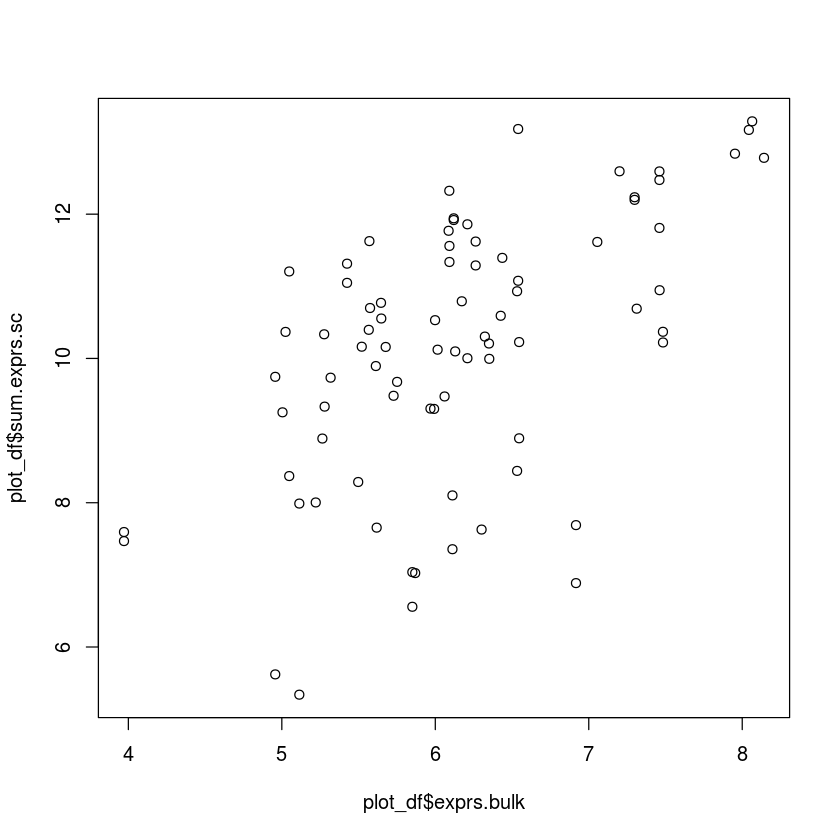

In [65]:
plot(plot_df$exprs.bulk, plot_df$sum.exprs.sc)